In [89]:
# 기본 모듈
import time
import os
import numpy as np 
import pandas as pd

# 시각화 모듈
import seaborn as sns
import matplotlib.pyplot as plt

# 데이터 전처리 모듈
from sklearn.preprocessing import LabelEncoder 
from sklearn.model_selection import train_test_split 

# 데이터 모델링 모듈
from sklearn.ensemble import RandomForestClassifier 

# 데이터 모델 평가 모듈
from sklearn.metrics import accuracy_score

# 2020

## 데이터 전처리

### 설문조사 데이터 전처리

In [ ]:
survey=pd.read_csv('../../user_survey_2020.csv') #수면 관련 설문조사 결과 데이터
survey=survey.sort_values(['userId','date']) #사용자명, 날짜 순으로 배열
survey['amPm']=survey['amPm'].apply(lambda x: 0 if x=='am' else 1) #amPm 수치형으로 변환

# 오전, 오후 데이터 분리
day_data=survey[survey['amPm']==0][survey.columns.difference(['caffeine', 'cAmount(ml)', 'alcohol', 'aAmount(ml)'])]
day_data=day_data[['userId','date','sleep','sleepProblem','dream','amCondition','amEmotion']]
day_data.head()

night_data=survey[survey['amPm']==1]
night_data=night_data[['userId','date','pmEmotion','pmStress','pmFatigue','caffeine', 'cAmount(ml)', 'alcohol', 'aAmount(ml)']]
night_data.head()

# 최종 데이터 구축
total_survey=pd.DataFrame() #전체 데이터 프레임
import numpy as np
df1=day_data # 다음날 아침 데이터
df2=night_data # 전날 저녁 데이터
num=0
for i in sorted(list(df1['userId'].unique())):
    df_1=df1[df1['userId']==i].sort_values('date').iloc[1:,:] 
    df_2=df2[df2['userId']==i].sort_values('date').iloc[:-1,:]
    num+=len(df_1)
    user_data=pd.DataFrame(index=range(len(df_1)),columns=df_1.columns) #사용자별 전체 데이터프레임 생성
    for x in df_2.columns: # 저녁 컬럼 만들기 
        user_data[x]=np.nan
    # 사용자별 데이터프레임 내용 채우기
    for j in range(len(user_data)):
        user_data.loc[j]=pd.concat([df_1.iloc[j][['sleep','endInput', 'sleepProblem', 'dream', 'amCondition',
           'amEmotion']],df_2.iloc[j]])
    total_survey=pd.concat([total_survey,user_data])
    
total_survey=total_survey.reset_index() # 인덱스 재정의
total_survey=total_survey.drop('index',axis=1) # 이전 인덱스 컬럼 삭제
# 결측치 처리
total_survey['cAmount(ml)']=total_survey['cAmount(ml)'].fillna(-1)
total_survey['aAmount(ml)']=total_survey['aAmount(ml)'].fillna(-1)
total_survey.head()

### 설문조사 데이터 + 수면조사 데이터 전처리

In [8]:
survey=pd.read_csv('../last_total_survey.csv')
for i in sorted(list(survey['userId'].unique())):
    print(i)
    #설문
    survey=pd.read_csv('../last_total_survey.csv')
    survey=survey.iloc[:,1:]
    users1=survey[survey['userId']==i] 
    users1=users1.reset_index()
    users1=users1.iloc[:,1:]
    
    #수면 
    data=pd.read_csv('../../jw_data/2020_sleep.csv')
    users2=data[data['userId']==i] 
    users2=users2.fillna(-1)
    users2=users2.drop('Unnamed: 0',axis=1)
    users2=users2.drop(users2[users2['sleep_score']==-1].index)
    users2=users2.reset_index()
    users2=users2.iloc[:,1:]
    users=pd.DataFrame()
    print(users1.shape,users2.shape)
    print(f"수면 데이터 중 중복된 데이터가 {users2.shape[0]-len(users2['date'].unique())}개이다.")
    #설문데이터 날짜,시간이 수면 데이터에 없으면 해당 수면 데이터는 제거해줘라 # 아침 수면 데이터만 남겨라
    for x in users1['endInput']: 
        day=x.split(' ')
        d=users2[users2['endDt'].str.contains(day[0])] #아침 설문 데이터의 날짜와 같은 날짜의 수면 데이터 # 없거나 2개 있을때도 있다
        d=d.reset_index()
        d=d.iloc[:,1:]
        if len(d)==0: #없거나
            continue
        elif len(d)==1: #하나이거나
            # 설문데이터보다 수면데이터가 일찍 끝났으면 수행 아니면 미수행
            t1=day[1].split(':')[0] #설문조사 시간
            t2=d.iloc[0]['endDt'].split(' ')[1].split(':')[0] #수면 데이터 시간
            if int(t1)>=int(t2): #설문데이터보다 수면데이터가 일찍 끝났으면 수행
                aec=users1[users1['endInput']==x]
                aec=aec.reset_index()
                aec=aec.drop('index',axis=1)
                wow=pd.concat([aec,d[d.columns[3:]]],axis=1)
                users=pd.concat([users,wow])
                users=users.reset_index()
                users=users.iloc[:,1:]
            else: #설문데이터보다 수면데이터가 일찍 끝나지 않았으면 미수행
                continue
        else: #두개이거나             
            for y in range(len(d)):
                # 설문데이터보다 수면데이터가 일찍 끝났으면 수행 아니면 미수행
                t1=day[1].split(':')[0] #설문조사 시간
                t2=d.iloc[y]['endDt'].split(' ')[1].split(':')[0] #수면 데이터 시간 
                if int(t1)>=int(t2): #설문데이터보다 수면데이터가 일찍 끝났으면 수행
                    aec=users1[users1['endInput']==x]
                    aec=aec.reset_index()
                    aec=aec.drop('index',axis=1)
                    aa=pd.DataFrame(d.loc[y,d.columns[3:]],index=d.columns[3:]).T
                    aa=aa.reset_index()
                    aa=aa.drop('index',axis=1)
                    wow=pd.concat([aec,aa],axis=1)
                    users=pd.concat([users,wow])
                    users=users.reset_index()
                    users=users.iloc[:,1:]
    display(users)
    ind2=f"../last/{i}.csv"
    users.to_csv(ind2)

user01
(27, 15) (44, 23)
수면 데이터 중 중복된 데이터가 6개이다.


,userId,date,endInput,sleep,sleepProblem,dream,amCondition,amEmotion,pmEmotion,pmStress,...,hr_average,hr_min,hr_max,rr_average,rr_min,rr_max,breathing_disturbances_intensity,snoring,snoringepisodecount,sleep_score
0,user01,2020-08-30,2020-08-31 8:43,3.0,6.0,2.0,3.0,3.0,4.0,2.0,...,69,57,83,16,12,25,18,8880,16,83
1,user01,2020-08-31,2020-09-01 10:18,2.0,3.0,2.0,2.0,3.0,4.0,3.0,...,73,63,82,16,12,22,20,8280,16,82
2,user01,2020-09-02,2020-09-03 11:04,3.0,3.0,2.0,2.0,3.0,4.0,3.0,...,72,64,80,16,11,24,20,11400,11,82
3,user01,2020-09-03,2020-09-04 12:33,4.0,3.0,2.0,3.0,3.0,2.0,2.0,...,72,60,85,16,12,21,14,5280,5,60
4,user01,2020-09-04,2020-09-05 10:25,3.0,3.0,4.0,2.0,3.0,4.0,2.0,...,71,61,82,16,11,22,15,5460,11,79
5,user01,2020-09-06,2020-09-07 10:28,2.0,3.0,2.0,2.0,5.0,5.0,2.0,...,63,53,68,21,14,25,-1,0,0,20
6,user01,2020-09-06,2020-09-07 10:28,2.0,3.0,2.0,2.0,5.0,5.0,2.0,...,69,58,82,17,12,23,-1,0,0,40
7,user01,2020-09-07,2020-09-08 10:45,4.0,3.0,2.0,3.0,4.0,4.0,4.0,...,67,53,81,17,9,27,15,6000,13,83
8,user01,2020-09-08,2020-09-09 10:09,2.0,7.0,1.0,3.0,3.0,5.0,4.0,...,62,55,74,15,11,22,14,1080,2,51
9,user01,2020-09-09,2020-09-10 13:02,1.0,3.0,2.0,2.0,4.0,4.0,4.0,...,61,53,71,15,10,23,-1,0,0,30


user02
(27, 15) (29, 23)
수면 데이터 중 중복된 데이터가 1개이다.


,userId,date,endInput,sleep,sleepProblem,dream,amCondition,amEmotion,pmEmotion,pmStress,...,hr_average,hr_min,hr_max,rr_average,rr_min,rr_max,breathing_disturbances_intensity,snoring,snoringepisodecount,sleep_score
0,user02,2020-08-31,2020-09-01 7:18,3.0,0.0,4.0,1.0,2.0,3.0,2.0,...,71,55,84,18,13,24,13,300,1,70
1,user02,2020-09-01,2020-09-02 7:40,3.0,5.0,2.0,1.0,2.0,3.0,2.0,...,63,56,79,17,11,24,12,0,0,87
2,user02,2020-09-02,2020-09-03 7:35,4.0,5.0,4.0,1.0,3.0,3.0,1.0,...,66,53,87,16,8,24,13,1020,3,75
3,user02,2020-09-03,2020-09-04 7:35,3.0,1.0,2.0,1.0,2.0,3.0,1.0,...,64,57,80,17,12,26,12,720,3,55
4,user02,2020-09-04,2020-09-05 10:37,4.0,0.0,4.0,3.0,3.0,4.0,2.0,...,64,51,84,17,11,23,13,1200,2,83
5,user02,2020-09-05,2020-09-06 11:15,5.0,0.0,4.0,4.0,3.0,4.0,4.0,...,62,46,75,17,9,22,12,0,0,86
6,user02,2020-09-06,2020-09-07 8:14,4.0,1.0,4.0,2.0,3.0,4.0,5.0,...,65,56,75,17,9,22,16,0,0,56
7,user02,2020-09-07,2020-09-08 7:58,2.0,0.0,2.0,2.0,3.0,3.0,2.0,...,68,52,79,16,8,24,15,3540,7,68
8,user02,2020-09-08,2020-09-09 7:55,3.0,0.0,2.0,1.0,1.0,2.0,1.0,...,67,54,75,17,14,24,11,1320,5,40
9,user02,2020-09-09,2020-09-10 7:36,4.0,0.0,2.0,1.0,2.0,2.0,1.0,...,65,58,76,17,13,21,12,5340,6,54


user03
(29, 15) (16, 23)
수면 데이터 중 중복된 데이터가 1개이다.


,userId,date,endInput,sleep,sleepProblem,dream,amCondition,amEmotion,pmEmotion,pmStress,...,hr_average,hr_min,hr_max,rr_average,rr_min,rr_max,breathing_disturbances_intensity,snoring,snoringepisodecount,sleep_score
0,user03,2020-08-29,2020-08-30 13:10,4.0,0.0,2.0,2.0,3.0,4.0,4.0,...,59,52,76,14,11,19,11,0,0,85
1,user03,2020-08-30,2020-08-31 11:21,1.0,1.0,4.0,1.0,2.0,3.0,5.0,...,51,45,73,14,11,20,7,0,0,52
2,user03,2020-08-31,2020-09-01 13:36,1.0,0.0,2.0,2.0,3.0,3.0,2.0,...,57,54,58,16,14,17,-1,0,0,20
3,user03,2020-09-04,2020-09-05 11:52,2.0,0.0,2.0,2.0,3.0,3.0,2.0,...,54,45,75,13,10,18,8,0,0,89
4,user03,2020-09-06,2020-09-07 12:51,2.0,2.0,2.0,1.0,2.0,3.0,4.0,...,52,46,70,13,10,19,12,180,1,75
5,user03,2020-09-10,2020-09-11 11:55,3.0,0.0,3.0,4.0,3.0,3.0,2.0,...,67,51,90,13,10,21,8,4020,4,86
6,user03,2020-09-11,2020-09-12 23:54,2.0,2.0,2.0,2.0,3.0,3.0,5.0,...,58,52,72,15,11,26,-1,0,0,20
7,user03,2020-09-11,2020-09-12 23:54,2.0,2.0,2.0,2.0,3.0,3.0,5.0,...,58,51,73,13,10,26,6,0,0,84
8,user03,2020-09-14,2020-09-15 10:59,4.0,5.0,2.0,2.0,3.0,4.0,3.0,...,59,52,76,13,10,17,8,0,0,77
9,user03,2020-09-15,2020-09-16 10:55,1.0,2.0,1.0,1.0,2.0,3.0,2.0,...,73,63,86,13,10,20,9,1140,5,68


user04
(27, 15) (33, 23)
수면 데이터 중 중복된 데이터가 5개이다.


,userId,date,endInput,sleep,sleepProblem,dream,amCondition,amEmotion,pmEmotion,pmStress,...,hr_average,hr_min,hr_max,rr_average,rr_min,rr_max,breathing_disturbances_intensity,snoring,snoringepisodecount,sleep_score
0,user04,2020-08-31,2020-09-01 7:15,2.0,2.0,2.0,2.0,3.0,4.0,2.0,...,59,51,73,13,9,25,17,4320,7,56
1,user04,2020-09-01,2020-09-02 8:01,3.0,2.0,4.0,4.0,3.0,4.0,2.0,...,54,47,72,13,9,22,21,5460,11,84
2,user04,2020-09-02,2020-09-03 7:36,2.0,7.0,1.0,3.0,3.0,4.0,3.0,...,53,47,81,13,10,20,16,7500,6,91
3,user04,2020-09-03,2020-09-04 8:55,3.0,2.0,4.0,4.0,4.0,4.0,2.0,...,55,48,70,13,10,25,25,4620,7,61
4,user04,2020-09-04,2020-09-05 8:13,4.0,3.0,2.0,4.0,4.0,4.0,4.0,...,53,47,73,12,9,20,16,6900,14,95
5,user04,2020-09-05,2020-09-06 8:20,4.0,0.0,2.0,4.0,5.0,4.0,5.0,...,57,50,73,13,9,26,18,6540,14,90
6,user04,2020-09-06,2020-09-07 7:27,4.0,0.0,4.0,4.0,4.0,4.0,5.0,...,53,47,63,13,10,19,17,1500,4,78
7,user04,2020-09-07,2020-09-08 8:56,1.0,9.0,4.0,2.0,3.0,4.0,3.0,...,64,59,73,14,10,17,-1,0,0,20
8,user04,2020-09-08,2020-09-09 7:27,4.0,0.0,4.0,2.0,3.0,4.0,2.0,...,57,50,70,12,10,18,14,9180,12,99
9,user04,2020-09-09,2020-09-10 7:49,4.0,0.0,4.0,4.0,4.0,4.0,2.0,...,52,48,64,12,9,17,-1,7320,9,20


user05
(27, 15) (29, 23)
수면 데이터 중 중복된 데이터가 1개이다.


,userId,date,endInput,sleep,sleepProblem,dream,amCondition,amEmotion,pmEmotion,pmStress,...,hr_average,hr_min,hr_max,rr_average,rr_min,rr_max,breathing_disturbances_intensity,snoring,snoringepisodecount,sleep_score
0,user05,2020-08-31,2020-09-01 7:45,2.0,2.0,4.0,2.0,3.0,4.0,3.0,...,61,52,87,13,10,24,17,0,0,35
1,user05,2020-09-01,2020-09-02 10:20,2.0,9.0,4.0,2.0,3.0,3.0,2.0,...,62,54,84,13,9,17,13,180,1,49
2,user05,2020-09-02,2020-09-03 7:40,4.0,0.0,4.0,4.0,4.0,3.0,2.0,...,58,50,73,13,9,18,13,0,0,75
3,user05,2020-09-03,2020-09-04 7:45,4.0,5.0,4.0,3.0,3.0,4.0,3.0,...,60,52,75,13,8,26,13,0,0,83
4,user05,2020-09-04,2020-09-05 9:03,4.0,0.0,4.0,3.0,4.0,4.0,4.0,...,62,55,76,13,9,18,13,0,0,77
5,user05,2020-09-05,2020-09-06 8:39,4.0,0.0,4.0,4.0,4.0,4.0,4.0,...,63,48,83,13,9,22,16,660,3,90
6,user05,2020-09-06,2020-09-07 7:31,3.0,0.0,2.0,4.0,4.0,4.0,2.0,...,62,50,82,13,10,19,15,0,0,65
7,user05,2020-09-07,2020-09-08 7:46,3.0,2.0,2.0,3.0,3.0,3.0,3.0,...,62,53,86,13,9,17,14,0,0,66
8,user05,2020-09-08,2020-09-09 7:48,3.0,1.0,4.0,3.0,3.0,4.0,4.0,...,64,52,80,14,9,19,14,0,0,63
9,user05,2020-09-09,2020-09-10 8:07,3.0,0.0,2.0,4.0,3.0,3.0,3.0,...,64,53,84,14,10,28,15,420,1,73


user06
(27, 15) (31, 23)
수면 데이터 중 중복된 데이터가 2개이다.


,userId,date,endInput,sleep,sleepProblem,dream,amCondition,amEmotion,pmEmotion,pmStress,...,hr_average,hr_min,hr_max,rr_average,rr_min,rr_max,breathing_disturbances_intensity,snoring,snoringepisodecount,sleep_score
0,user06,2020-09-11,2020-09-12 9:06,4.0,0.0,4.0,2.0,3.0,4.0,2.0,...,49,43,68,17,10,22,19,540,2,84
1,user06,2020-09-12,2020-09-13 15:08,5.0,0.0,4.0,3.0,3.0,3.0,2.0,...,51,45,71,17,11,23,15,4680,7,94
2,user06,2020-09-13,2020-09-14 9:39,4.0,2.0,2.0,2.0,3.0,3.0,2.0,...,51,46,65,17,11,24,16,1260,1,80
3,user06,2020-09-14,2020-09-15 9:43,4.0,0.0,4.0,2.0,2.0,4.0,2.0,...,49,45,68,16,9,23,-1,4860,5,29
4,user06,2020-09-15,2020-09-16 9:14,3.0,7.0,1.0,2.0,2.0,1.0,1.0,...,52,46,70,17,10,24,13,360,2,85
5,user06,2020-09-16,2020-09-17 10:18,4.0,2.0,1.0,3.0,2.0,3.0,2.0,...,51,44,69,17,8,25,16,420,1,88
6,user06,2020-09-17,2020-09-18 9:20,3.0,2.0,1.0,2.0,3.0,3.0,3.0,...,51,45,75,17,10,22,17,2220,5,87
7,user06,2020-09-18,2020-09-19 11:42,4.0,0.0,3.0,4.0,4.0,4.0,2.0,...,50,45,67,17,9,24,12,180,1,56
8,user06,2020-09-19,2020-09-20 7:08,4.0,0.0,4.0,2.0,2.0,4.0,4.0,...,50,45,67,18,12,22,-1,180,1,20
9,user06,2020-09-20,2020-09-21 9:26,4.0,0.0,4.0,2.0,3.0,3.0,4.0,...,53,47,72,18,13,25,15,3240,4,87


user07
(25, 15) (31, 23)
수면 데이터 중 중복된 데이터가 4개이다.


,userId,date,endInput,sleep,sleepProblem,dream,amCondition,amEmotion,pmEmotion,pmStress,...,hr_average,hr_min,hr_max,rr_average,rr_min,rr_max,breathing_disturbances_intensity,snoring,snoringepisodecount,sleep_score
0,user07,2020-08-31,2020-09-01 11:14,3.0,0.0,4.0,3.0,3.0,5.0,5.0,...,75,66,85,21,10,28,19,1440,3,62
1,user07,2020-09-01,2020-09-02 12:19,5.0,6.0,2.0,4.0,4.0,4.0,3.0,...,70,59,84,20,9,25,19,960,1,96
2,user07,2020-09-02,2020-09-03 7:39,2.0,7.0,1.0,3.0,2.0,3.0,2.0,...,75,67,86,21,10,25,-1,0,0,20
3,user07,2020-09-03,2020-09-04 13:11,5.0,6.0,2.0,4.0,4.0,5.0,3.0,...,76,62,89,20,9,28,16,6840,5,95
4,user07,2020-09-04,2020-09-05 11:52,2.0,6.0,2.0,2.0,3.0,5.0,5.0,...,73,65,85,19,16,25,-1,180,1,20
5,user07,2020-09-08,2020-09-09 19:58,2.0,2.0,4.0,2.0,3.0,4.0,3.0,...,64,55,84,18,13,25,17,0,0,36
6,user07,2020-09-09,2020-09-10 6:42,1.0,0.0,4.0,1.0,2.0,3.0,3.0,...,67,63,70,20,12,22,-1,0,0,20
7,user07,2020-09-10,2020-09-11 18:28,5.0,0.0,4.0,4.0,5.0,5.0,4.0,...,75,56,92,20,14,28,20,1740,2,73
8,user07,2020-09-11,2020-09-12 22:21,2.0,6.0,4.0,2.0,2.0,4.0,5.0,...,75,66,89,20,12,23,13,2520,2,43
9,user07,2020-09-13,2020-09-14 22:27,3.0,0.0,4.0,2.0,3.0,4.0,3.0,...,76,61,86,20,11,24,15,3960,6,82


user08
(25, 15) (21, 23)
수면 데이터 중 중복된 데이터가 2개이다.


,userId,date,endInput,sleep,sleepProblem,dream,amCondition,amEmotion,pmEmotion,pmStress,...,hr_average,hr_min,hr_max,rr_average,rr_min,rr_max,breathing_disturbances_intensity,snoring,snoringepisodecount,sleep_score
0,user08,2020-09-01,2020-09-02 7:03,4.0,0.0,2.0,4.0,4.0,4.0,3.0,...,72,55,90,16,9,19,11,4140,7,35
1,user08,2020-09-05,2020-09-06 12:45,5.0,0.0,4.0,5.0,5.0,4.0,5.0,...,64,58,68,17,14,18,-1,840,2,20
2,user08,2020-09-05,2020-09-06 12:45,5.0,0.0,4.0,5.0,5.0,4.0,5.0,...,60,55,71,15,12,17,-1,0,0,20
3,user08,2020-09-06,2020-09-07 8:01,5.0,0.0,3.0,5.0,5.0,5.0,4.0,...,56,51,72,16,12,22,-1,0,0,29
4,user08,2020-09-07,2020-09-08 9:15,5.0,0.0,2.0,3.0,4.0,5.0,2.0,...,66,53,84,17,9,21,14,0,0,45
5,user08,2020-09-09,2020-09-10 7:20,2.0,2.0,2.0,3.0,3.0,1.0,1.0,...,56,49,71,16,12,20,16,0,0,88
6,user08,2020-09-10,2020-09-11 23:02,3.0,1.0,3.0,3.0,4.0,3.0,3.0,...,55,46,73,16,12,22,16,960,4,63
7,user08,2020-09-14,2020-09-15 7:29,4.0,0.0,3.0,4.0,4.0,4.0,3.0,...,58,51,75,16,13,20,13,840,2,47
8,user08,2020-09-17,2020-09-18 7:17,5.0,0.0,3.0,4.0,4.0,5.0,4.0,...,60,53,69,16,12,19,-1,180,1,20
9,user08,2020-09-18,2020-09-19 21:23,5.0,0.0,2.0,5.0,5.0,4.0,4.0,...,61,53,74,16,12,30,13,1260,4,77


user09
(27, 15) (26, 23)
수면 데이터 중 중복된 데이터가 0개이다.


,userId,date,endInput,sleep,sleepProblem,dream,amCondition,amEmotion,pmEmotion,pmStress,...,hr_average,hr_min,hr_max,rr_average,rr_min,rr_max,breathing_disturbances_intensity,snoring,snoringepisodecount,sleep_score
0,user09,2020-08-31,2020-09-01 9:33,3.0,2.0,4.0,4.0,3.0,3.0,2.0,...,61,49,78,16,10,25,16,3960,4,77
1,user09,2020-09-01,2020-09-02 9:26,2.0,5.0,4.0,2.0,3.0,3.0,2.0,...,59,49,75,17,11,21,26,1860,6,57
2,user09,2020-09-02,2020-09-03 9:09,2.0,2.0,4.0,2.0,3.0,3.0,3.0,...,59,52,71,16,11,20,-1,2280,2,20
3,user09,2020-09-03,2020-09-04 10:06,2.0,2.0,4.0,2.0,2.0,4.0,4.0,...,57,49,74,17,11,23,-1,2100,4,20
4,user09,2020-09-04,2020-09-05 6:49,2.0,2.0,4.0,2.0,3.0,4.0,4.0,...,61,51,84,16,9,24,-1,780,3,23
5,user09,2020-09-05,2020-09-06 8:39,2.0,2.0,1.0,2.0,2.0,2.0,2.0,...,69,58,79,19,14,23,-1,1380,3,25
6,user09,2020-09-06,2020-09-07 11:34,3.0,2.0,3.0,3.0,3.0,3.0,3.0,...,68,56,86,16,12,24,21,3120,5,45
7,user09,2020-09-07,2020-09-08 11:30,2.0,4.0,4.0,2.0,3.0,3.0,4.0,...,61,54,75,16,11,19,17,660,4,34
8,user09,2020-09-08,2020-09-09 10:03,3.0,0.0,4.0,3.0,4.0,4.0,4.0,...,68,57,82,16,10,20,-1,1740,4,28
9,user09,2020-09-09,2020-09-10 12:51,3.0,0.0,3.0,3.0,3.0,4.0,4.0,...,60,50,74,16,11,21,15,1200,2,20


user10
(27, 15) (32, 23)
수면 데이터 중 중복된 데이터가 3개이다.


,userId,date,endInput,sleep,sleepProblem,dream,amCondition,amEmotion,pmEmotion,pmStress,...,hr_average,hr_min,hr_max,rr_average,rr_min,rr_max,breathing_disturbances_intensity,snoring,snoringepisodecount,sleep_score
0,user10,2020-08-30,2020-08-31 6:24,2.0,1.0,4.0,2.0,2.0,3.0,5.0,...,62,42,75,18,11,25,-1,1140,1,20
1,user10,2020-08-31,2020-09-02 6:21,2.0,5.0,2.0,2.0,2.0,4.0,2.0,...,59,44,77,18,11,30,95,1680,1,34
2,user10,2020-09-02,2020-09-03 6:41,3.0,1.0,4.0,3.0,3.0,4.0,2.0,...,65,55,78,17,10,26,-1,0,0,39
3,user10,2020-09-03,2020-09-04 7:05,4.0,5.0,3.0,4.0,4.0,4.0,1.0,...,60,46,76,17,10,28,95,1560,5,69
4,user10,2020-09-04,2020-09-05 15:40,2.0,4.0,3.0,2.0,2.0,4.0,2.0,...,80,58,90,17,11,26,95,960,3,94
5,user10,2020-09-06,2020-09-07 6:28,4.0,1.0,3.0,4.0,4.0,4.0,5.0,...,61,47,71,16,10,22,-1,1080,2,20
6,user10,2020-09-07,2020-09-08 6:45,5.0,1.0,3.0,4.0,5.0,3.0,2.0,...,55,42,75,16,11,28,95,1380,4,71
7,user10,2020-09-08,2020-09-09 7:11,3.0,1.0,4.0,2.0,3.0,3.0,2.0,...,56,44,70,16,10,23,95,3480,4,42
8,user10,2020-09-09,2020-09-10 6:36,3.0,1.0,4.0,2.0,2.0,3.0,3.0,...,58,47,72,16,12,28,95,1080,2,41
9,user10,2020-09-10,2020-09-11 7:20,2.0,4.0,4.0,1.0,1.0,5.0,5.0,...,78,60,90,17,9,25,95,0,0,75


user11
(28, 15) (18, 23)
수면 데이터 중 중복된 데이터가 0개이다.


,userId,date,endInput,sleep,sleepProblem,dream,amCondition,amEmotion,pmEmotion,pmStress,...,hr_average,hr_min,hr_max,rr_average,rr_min,rr_max,breathing_disturbances_intensity,snoring,snoringepisodecount,sleep_score
0,user11,2020-08-30,2020-08-31 10:37,4.0,0.0,4.0,3.0,3.0,4.0,4.0,...,58,44,80,17,12,28,19,1800,6,80
1,user11,2020-08-31,2020-09-01 7:58,2.0,5.0,4.0,2.0,3.0,4.0,3.0,...,52,42,76,16,10,21,20,1260,2,85
2,user11,2020-09-01,2020-09-02 7:51,3.0,2.0,4.0,3.0,3.0,3.0,2.0,...,58,45,93,17,9,24,16,4620,9,88
3,user11,2020-09-02,2020-09-03 8:10,2.0,2.0,2.0,3.0,3.0,3.0,2.0,...,52,41,69,16,10,27,21,120,1,78
4,user11,2020-09-03,2020-09-04 8:18,2.0,2.0,4.0,2.0,3.0,2.0,2.0,...,48,42,63,16,12,24,-1,0,0,20
5,user11,2020-09-04,2020-09-05 10:53,3.0,2.0,2.0,3.0,3.0,3.0,2.0,...,51,44,60,15,12,18,-1,0,0,20
6,user11,2020-09-08,2020-09-09 7:24,2.0,0.0,4.0,3.0,3.0,3.0,3.0,...,54,46,61,15,12,22,-1,900,2,20
7,user11,2020-09-09,2020-09-10 10:09,3.0,0.0,4.0,3.0,4.0,3.0,3.0,...,52,44,59,15,12,18,-1,0,0,20
8,user11,2020-09-11,2020-09-12 10:41,3.0,0.0,4.0,3.0,3.0,4.0,4.0,...,55,46,73,17,13,25,17,180,1,68
9,user11,2020-09-12,2020-09-13 11:43,3.0,3.0,4.0,3.0,3.0,4.0,4.0,...,55,41,70,16,10,24,17,0,0,88


user12
(28, 15) (31, 23)
수면 데이터 중 중복된 데이터가 7개이다.


,userId,date,endInput,sleep,sleepProblem,dream,amCondition,amEmotion,pmEmotion,pmStress,...,hr_average,hr_min,hr_max,rr_average,rr_min,rr_max,breathing_disturbances_intensity,snoring,snoringepisodecount,sleep_score
0,user12,2020-08-30,2020-08-31 6:38,3.0,2.0,2.0,3.0,3.0,4.0,4.0,...,58,54,64,15,12,18,-1,0,0,47
1,user12,2020-08-31,2020-09-01 7:28,4.0,5.0,2.0,4.0,3.0,3.0,4.0,...,67,56,78,15,12,20,-1,0,0,24
2,user12,2020-09-01,2020-09-02 7:35,2.0,2.0,2.0,2.0,3.0,3.0,3.0,...,66,56,82,14,10,25,7,0,0,84
3,user12,2020-09-02,2020-09-03 7:54,3.0,2.0,2.0,2.0,2.0,1.0,1.0,...,75,65,86,15,11,20,4,720,3,82
4,user12,2020-09-03,2020-09-04 7:35,4.0,0.0,2.0,4.0,3.0,4.0,3.0,...,65,56,88,14,8,25,6,0,0,89
5,user12,2020-09-05,2020-09-06 12:44,5.0,5.0,2.0,5.0,5.0,5.0,5.0,...,75,59,88,16,12,21,8,120,1,82
6,user12,2020-09-06,2020-09-07 20:02,5.0,5.0,2.0,2.0,4.0,5.0,5.0,...,69,55,73,17,15,18,-1,0,0,20
7,user12,2020-09-06,2020-09-07 20:02,5.0,5.0,2.0,2.0,4.0,5.0,5.0,...,65,53,71,17,16,18,-1,0,0,20
8,user12,2020-09-07,2020-09-08 17:52,5.0,0.0,2.0,5.0,5.0,4.0,4.0,...,58,51,86,14,10,25,13,0,0,29
9,user12,2020-09-07,2020-09-08 17:52,5.0,0.0,2.0,5.0,5.0,4.0,4.0,...,80,77,81,16,14,17,-1,0,0,20


user21
(29, 15) (24, 23)
수면 데이터 중 중복된 데이터가 1개이다.


,userId,date,endInput,sleep,sleepProblem,dream,amCondition,amEmotion,pmEmotion,pmStress,...,hr_average,hr_min,hr_max,rr_average,rr_min,rr_max,breathing_disturbances_intensity,snoring,snoringepisodecount,sleep_score
0,user21,2020-08-29,2020-08-30 10:00,3.0,5.0,4.0,3.0,4.0,4.0,3.0,...,65,53,76,19,9,26,-1,0,0,51
1,user21,2020-08-30,2020-08-31 8:52,3.0,6.0,2.0,3.0,3.0,3.0,3.0,...,63,52,74,20,13,27,9,0,0,83
2,user21,2020-08-31,2020-09-01 7:48,4.0,0.0,4.0,3.0,3.0,4.0,4.0,...,63,54,79,20,10,25,11,0,0,82
3,user21,2020-09-01,2020-09-02 7:46,4.0,0.0,4.0,4.0,4.0,3.0,2.0,...,67,54,78,20,16,27,10,0,0,66
4,user21,2020-09-02,2020-09-03 7:56,2.0,1.0,4.0,2.0,3.0,5.0,3.0,...,65,48,82,19,9,25,8,420,1,55
5,user21,2020-09-03,2020-09-04 7:50,4.0,0.0,4.0,3.0,4.0,5.0,3.0,...,60,52,75,19,12,25,13,900,2,79
6,user21,2020-09-04,2020-09-05 9:58,3.0,0.0,4.0,3.0,4.0,3.0,2.0,...,68,56,76,23,18,26,-1,0,0,20
7,user21,2020-09-05,2020-09-06 9:33,4.0,0.0,4.0,4.0,5.0,5.0,5.0,...,55,47,73,19,10,25,21,960,4,56
8,user21,2020-09-07,2020-09-08 7:55,4.0,0.0,4.0,4.0,3.0,5.0,4.0,...,56,47,70,19,11,25,16,0,0,80
9,user21,2020-09-08,2020-09-09 8:50,4.0,0.0,4.0,4.0,4.0,3.0,2.0,...,62,49,82,19,11,28,18,0,0,88


user22
(26, 15) (25, 23)
수면 데이터 중 중복된 데이터가 0개이다.


,userId,date,endInput,sleep,sleepProblem,dream,amCondition,amEmotion,pmEmotion,pmStress,...,hr_average,hr_min,hr_max,rr_average,rr_min,rr_max,breathing_disturbances_intensity,snoring,snoringepisodecount,sleep_score
0,user22,2020-09-02,2020-09-03 7:53,3.0,1.0,4.0,1.0,1.0,4.0,4.0,...,64,57,79,16,10,25,17,1860,5,89
1,user22,2020-09-03,2020-09-04 9:27,2.0,1.0,4.0,1.0,1.0,4.0,1.0,...,66,59,78,16,11,23,-1,0,0,20
2,user22,2020-09-04,2020-09-05 8:14,2.0,1.0,4.0,1.0,1.0,3.0,1.0,...,63,47,76,16,12,23,-1,900,2,20
3,user22,2020-09-05,2020-09-06 8:41,2.0,1.0,4.0,1.0,1.0,4.0,4.0,...,62,55,75,16,10,20,-1,180,1,20
4,user22,2020-09-07,2020-09-08 8:05,4.0,5.0,4.0,1.0,1.0,4.0,4.0,...,62,55,75,15,10,22,11,0,0,61
5,user22,2020-09-08,2020-09-09 8:05,2.0,7.0,1.0,1.0,1.0,4.0,3.0,...,63,55,76,16,10,25,-1,900,2,20
6,user22,2020-09-09,2020-09-10 8:00,3.0,1.0,4.0,1.0,1.0,4.0,3.0,...,61,55,79,16,10,24,-1,180,1,41
7,user22,2020-09-10,2020-09-11 13:40,4.0,0.0,4.0,1.0,1.0,1.0,1.0,...,66,54,84,16,11,22,14,3420,3,53
8,user22,2020-09-11,2020-09-12 8:33,3.0,1.0,4.0,1.0,3.0,3.0,2.0,...,63,56,78,15,11,20,-1,0,0,20
9,user22,2020-09-13,2020-09-14 9:24,3.0,5.0,2.0,1.0,1.0,3.0,1.0,...,61,55,73,16,9,24,-1,1140,4,42


user23
(27, 15) (30, 23)
수면 데이터 중 중복된 데이터가 2개이다.


,userId,date,endInput,sleep,sleepProblem,dream,amCondition,amEmotion,pmEmotion,pmStress,...,hr_average,hr_min,hr_max,rr_average,rr_min,rr_max,breathing_disturbances_intensity,snoring,snoringepisodecount,sleep_score
0,user23,2020-08-31,2020-09-01 7:25,4.0,1.0,2.0,2.0,4.0,5.0,2.0,...,58,50,71,15,10,25,35,8040,16,70
1,user23,2020-09-03,2020-09-04 9:33,4.0,1.0,2.0,4.0,4.0,5.0,5.0,...,58,45,69,16,9,23,32,7920,18,81
2,user23,2020-09-04,2020-09-05 10:02,4.0,0.0,4.0,5.0,5.0,5.0,5.0,...,61,50,82,16,11,24,39,5100,8,64
3,user23,2020-09-06,2020-09-07 7:06,3.0,5.0,2.0,1.0,2.0,5.0,4.0,...,60,50,72,15,12,23,31,5040,8,38
4,user23,2020-09-07,2020-09-08 7:31,3.0,8.0,2.0,2.0,4.0,5.0,4.0,...,66,58,81,17,11,22,-1,8100,8,20
5,user23,2020-09-08,2020-09-09 7:48,3.0,8.0,2.0,3.0,3.0,4.0,2.0,...,64,54,77,16,10,21,-1,4500,12,23
6,user23,2020-09-09,2020-09-10 8:01,2.0,7.0,2.0,1.0,1.0,4.0,2.0,...,60,50,72,15,10,24,32,2880,10,64
7,user23,2020-09-10,2020-09-11 8:21,3.0,3.0,2.0,3.0,4.0,5.0,4.0,...,57,48,73,15,9,26,35,9960,19,69
8,user23,2020-09-11,2020-09-12 10:44,4.0,0.0,2.0,4.0,4.0,5.0,4.0,...,61,52,75,15,9,25,37,11100,19,76
9,user23,2020-09-12,2020-09-13 9:31,2.0,9.0,2.0,2.0,4.0,5.0,5.0,...,57,49,69,15,10,22,36,7620,11,36


user24
(29, 15) (31, 23)
수면 데이터 중 중복된 데이터가 1개이다.


,userId,date,endInput,sleep,sleepProblem,dream,amCondition,amEmotion,pmEmotion,pmStress,...,hr_average,hr_min,hr_max,rr_average,rr_min,rr_max,breathing_disturbances_intensity,snoring,snoringepisodecount,sleep_score
0,user24,2020-08-29,2020-08-30 7:41,3.0,2.0,2.0,2.0,3.0,4.0,4.0,...,72,63,82,15,10,20,10,840,1,86
1,user24,2020-08-30,2020-08-31 7:24,3.0,2.0,2.0,3.0,3.0,4.0,5.0,...,69,60,82,15,11,20,8,2700,3,52
2,user24,2020-08-31,2020-09-01 6:20,4.0,0.0,4.0,4.0,3.0,4.0,2.0,...,70,58,94,15,12,23,8,0,0,61
3,user24,2020-09-01,2020-09-02 9:02,4.0,0.0,4.0,2.0,4.0,5.0,4.0,...,68,60,80,15,12,19,-1,240,1,40
4,user24,2020-09-02,2020-09-03 7:33,4.0,0.0,2.0,2.0,3.0,4.0,4.0,...,71,61,83,15,11,25,7,300,1,55
5,user24,2020-09-03,2020-09-04 6:22,3.0,0.0,2.0,2.0,3.0,3.0,2.0,...,67,59,83,15,10,23,7,1620,3,79
6,user24,2020-09-04,2020-09-05 12:08,4.0,0.0,3.0,3.0,5.0,5.0,4.0,...,67,59,78,15,11,30,9,4500,3,72
7,user24,2020-09-05,2020-09-06 9:00,4.0,0.0,2.0,2.0,3.0,5.0,5.0,...,68,58,80,15,9,21,9,1800,2,82
8,user24,2020-09-06,2020-09-07 6:38,4.0,1.0,2.0,4.0,3.0,2.0,1.0,...,71,60,94,16,12,26,-1,0,0,36
9,user24,2020-09-07,2020-09-08 7:13,4.0,0.0,4.0,1.0,4.0,4.0,2.0,...,66,50,78,15,12,18,-1,1260,2,20


user25
(26, 15) (28, 23)
수면 데이터 중 중복된 데이터가 2개이다.


,userId,date,endInput,sleep,sleepProblem,dream,amCondition,amEmotion,pmEmotion,pmStress,...,hr_average,hr_min,hr_max,rr_average,rr_min,rr_max,breathing_disturbances_intensity,snoring,snoringepisodecount,sleep_score
0,user25,2020-09-01,2020-09-02 12:44,4.0,0.0,2.0,4.0,4.0,2.0,2.0,...,57,51,66,14,10,22,-1,540,1,20
1,user25,2020-09-03,2020-09-04 7:43,3.0,6.0,2.0,1.0,2.0,4.0,2.0,...,67,58,79,15,11,27,-1,5100,7,35
2,user25,2020-09-04,2020-09-05 11:54,4.0,0.0,4.0,3.0,3.0,3.0,2.0,...,58,47,80,15,9,24,8,3540,10,94
3,user25,2020-09-05,2020-09-06 14:29,2.0,7.0,2.0,1.0,1.0,3.0,2.0,...,53,46,72,13,9,25,2,1140,2,56
4,user25,2020-09-06,2020-09-07 8:45,3.0,0.0,4.0,2.0,2.0,5.0,2.0,...,66,57,83,15,12,26,-1,840,2,20
5,user25,2020-09-07,2020-09-08 7:25,2.0,2.0,4.0,4.0,3.0,4.0,2.0,...,63,54,79,17,10,20,-1,0,0,20
6,user25,2020-09-08,2020-09-09 7:42,4.0,0.0,4.0,2.0,3.0,4.0,4.0,...,57,46,73,14,9,25,-1,840,3,29
7,user25,2020-09-09,2020-09-10 9:04,4.0,0.0,4.0,4.0,4.0,2.0,1.0,...,58,46,68,14,10,23,-1,4500,8,31
8,user25,2020-09-10,2020-09-11 9:04,5.0,0.0,4.0,5.0,4.0,4.0,4.0,...,60,50,70,15,11,25,-1,3900,5,33
9,user25,2020-09-11,2020-09-12 15:12,5.0,0.0,4.0,5.0,5.0,3.0,2.0,...,54,40,72,14,11,26,7,1320,4,83


user26
(26, 15) (31, 23)
수면 데이터 중 중복된 데이터가 3개이다.


,userId,date,endInput,sleep,sleepProblem,dream,amCondition,amEmotion,pmEmotion,pmStress,...,hr_average,hr_min,hr_max,rr_average,rr_min,rr_max,breathing_disturbances_intensity,snoring,snoringepisodecount,sleep_score
0,user26,2020-09-01,2020-09-02 9:21,3.0,2.0,2.0,3.0,3.0,4.0,4.0,...,78,68,89,19,14,26,4,0,0,79
1,user26,2020-09-02,2020-09-03 10:20,3.0,2.0,2.0,2.0,3.0,5.0,4.0,...,71,61,82,17,8,24,4,780,3,86
2,user26,2020-09-03,2020-09-04 9:58,2.0,0.0,2.0,4.0,3.0,4.0,4.0,...,66,59,78,17,14,23,-1,1320,1,24
3,user26,2020-09-04,2020-09-05 9:24,4.0,5.0,4.0,4.0,3.0,4.0,3.0,...,67,58,82,17,13,24,4,1860,2,72
4,user26,2020-09-05,2020-09-06 11:56,4.0,0.0,2.0,2.0,4.0,5.0,1.0,...,68,59,79,17,10,22,4,120,1,62
5,user26,2020-09-06,2020-09-07 9:56,4.0,0.0,4.0,4.0,4.0,5.0,5.0,...,67,59,75,17,8,21,-1,0,0,20
6,user26,2020-09-07,2020-09-08 12:20,4.0,0.0,2.0,2.0,3.0,4.0,3.0,...,64,53,77,17,8,24,5,360,2,74
7,user26,2020-09-08,2020-09-09 11:17,4.0,0.0,4.0,3.0,3.0,5.0,4.0,...,68,61,78,17,14,20,-1,0,0,20
8,user26,2020-09-09,2020-09-10 12:00,4.0,0.0,4.0,3.0,3.0,4.0,4.0,...,61,53,77,17,11,21,4,1260,3,66
9,user26,2020-09-10,2020-09-11 12:21,4.0,0.0,2.0,2.0,3.0,4.0,4.0,...,63,54,81,17,12,28,4,900,4,90


user27
(26, 15) (40, 23)
수면 데이터 중 중복된 데이터가 8개이다.


,userId,date,endInput,sleep,sleepProblem,dream,amCondition,amEmotion,pmEmotion,pmStress,...,hr_average,hr_min,hr_max,rr_average,rr_min,rr_max,breathing_disturbances_intensity,snoring,snoringepisodecount,sleep_score
0,user27,2020-09-04,2020-09-05 8:52,4.0,0.0,4.0,3.0,2.0,3.0,3.0,...,60,42,77,14,11,19,-1,0,0,47
1,user27,2020-09-05,2020-09-06 10:14,1.0,9.0,4.0,2.0,2.0,2.0,2.0,...,60,51,71,14,9,19,-1,0,0,23
2,user27,2020-09-06,2020-09-07 5:43,5.0,5.0,4.0,4.0,4.0,4.0,4.0,...,62,55,76,14,10,18,-1,0,0,20
3,user27,2020-09-08,2020-09-09 7:28,3.0,1.0,4.0,4.0,3.0,2.0,4.0,...,58,53,82,14,11,16,-1,0,0,20
4,user27,2020-09-09,2020-09-10 18:07,1.0,1.0,4.0,2.0,2.0,3.0,4.0,...,63,55,81,13,10,18,-1,0,0,20
5,user27,2020-09-10,2020-09-11 14:02,4.0,0.0,4.0,3.0,3.0,3.0,2.0,...,60,51,78,13,10,17,4,900,1,35
6,user27,2020-09-10,2020-09-11 14:02,4.0,0.0,4.0,3.0,3.0,3.0,2.0,...,59,52,68,14,10,20,-1,0,0,20
7,user27,2020-09-11,2020-09-12 12:21,3.0,3.0,2.0,3.0,2.0,3.0,2.0,...,64,55,76,14,9,18,-1,0,0,20
8,user27,2020-09-11,2020-09-12 12:21,3.0,3.0,2.0,3.0,2.0,3.0,2.0,...,58,49,70,14,10,28,-1,0,0,20
9,user27,2020-09-12,2020-09-14 12:24,4.0,6.0,4.0,3.0,2.0,2.0,4.0,...,59,49,66,14,11,17,-1,0,0,20


user28
(25, 15) (26, 23)
수면 데이터 중 중복된 데이터가 0개이다.


,userId,date,endInput,sleep,sleepProblem,dream,amCondition,amEmotion,pmEmotion,pmStress,...,hr_average,hr_min,hr_max,rr_average,rr_min,rr_max,breathing_disturbances_intensity,snoring,snoringepisodecount,sleep_score
0,user28,2020-08-31,2020-09-01 5:43,2.0,2.0,4.0,2.0,3.0,3.0,2.0,...,58,52,68,16,13,20,-1,540,3,24
1,user28,2020-09-01,2020-09-02 5:49,3.0,0.0,4.0,2.0,3.0,4.0,3.0,...,59,53,69,17,11,19,-1,300,1,20
2,user28,2020-09-02,2020-09-03 5:38,3.0,2.0,4.0,4.0,3.0,3.0,3.0,...,57,49,68,17,10,25,-1,600,3,22
3,user28,2020-09-03,2020-09-05 7:46,4.0,2.0,2.0,4.0,3.0,3.0,2.0,...,58,53,72,18,14,20,-1,300,2,20
4,user28,2020-09-05,2020-09-06 8:41,5.0,0.0,2.0,4.0,4.0,4.0,5.0,...,57,51,66,17,12,27,32,3060,7,64
5,user28,2020-09-06,2020-09-07 6:40,3.0,0.0,4.0,3.0,3.0,4.0,2.0,...,58,52,66,16,9,21,-1,1560,3,32
6,user28,2020-09-07,2020-09-08 5:41,3.0,9.0,2.0,2.0,3.0,3.0,3.0,...,58,52,75,16,10,18,-1,4380,10,27
7,user28,2020-09-08,2020-09-09 6:21,3.0,2.0,4.0,3.0,3.0,2.0,3.0,...,55,51,65,16,10,18,-1,2580,4,20
8,user28,2020-09-09,2020-09-10 6:53,3.0,2.0,4.0,2.0,3.0,4.0,3.0,...,57,51,72,16,12,20,-1,4740,9,20
9,user28,2020-09-10,2020-09-11 9:13,2.0,2.0,4.0,4.0,3.0,5.0,4.0,...,60,54,61,17,15,18,-1,0,0,20


user29
(28, 15) (11, 23)
수면 데이터 중 중복된 데이터가 0개이다.


,userId,date,endInput,sleep,sleepProblem,dream,amCondition,amEmotion,pmEmotion,pmStress,...,hr_average,hr_min,hr_max,rr_average,rr_min,rr_max,breathing_disturbances_intensity,snoring,snoringepisodecount,sleep_score
0,user29,2020-08-30,2020-08-31 9:09,3.0,0.0,4.0,2.0,3.0,2.0,2.0,...,58,53,75,16,10,25,12,240,1,21
1,user29,2020-09-01,2020-09-02 9:31,4.0,0.0,4.0,2.0,3.0,3.0,2.0,...,58,53,77,16,8,26,12,0,0,96
2,user29,2020-09-03,2020-09-04 9:21,4.0,0.0,4.0,2.0,3.0,3.0,3.0,...,54,49,66,16,12,25,10,0,0,91
3,user29,2020-09-09,2020-09-10 9:15,3.0,0.0,4.0,2.0,3.0,3.0,3.0,...,56,50,76,16,12,27,9,0,0,80
4,user29,2020-09-10,2020-09-11 9:36,3.0,0.0,2.0,2.0,3.0,3.0,3.0,...,55,45,71,17,11,25,23,0,0,81
5,user29,2020-09-11,2020-09-12 11:11,3.0,0.0,4.0,2.0,3.0,4.0,3.0,...,64,55,84,17,12,26,12,0,0,96
6,user29,2020-09-13,2020-09-14 9:13,4.0,0.0,4.0,3.0,4.0,3.0,4.0,...,55,47,65,15,12,25,12,0,0,62
7,user29,2020-09-14,2020-09-15 10:42,3.0,6.0,4.0,3.0,3.0,4.0,2.0,...,58,49,75,16,11,25,8,0,0,75


user30
(27, 15) (28, 23)
수면 데이터 중 중복된 데이터가 1개이다.


,userId,date,endInput,sleep,sleepProblem,dream,amCondition,amEmotion,pmEmotion,pmStress,...,hr_average,hr_min,hr_max,rr_average,rr_min,rr_max,breathing_disturbances_intensity,snoring,snoringepisodecount,sleep_score
0,user30,2020-08-31,2020-09-01 8:03,2.0,5.0,4.0,2.0,2.0,4.0,2.0,...,62,52,75,15,10,23,28,5760,12,56
1,user30,2020-09-01,2020-09-02 8:15,4.0,0.0,4.0,2.0,3.0,4.0,1.0,...,60,51,83,15,10,26,31,9900,16,71
2,user30,2020-09-02,2020-09-03 8:14,4.0,0.0,4.0,2.0,3.0,4.0,2.0,...,60,47,75,15,10,25,30,9540,17,73
3,user30,2020-09-03,2020-09-04 8:07,4.0,0.0,4.0,2.0,3.0,4.0,2.0,...,61,52,71,15,10,23,23,8100,11,50
4,user30,2020-09-04,2020-09-05 8:39,4.0,0.0,4.0,3.0,4.0,4.0,4.0,...,62,51,81,15,9,23,24,12540,13,80
5,user30,2020-09-05,2020-09-06 10:18,4.0,0.0,4.0,3.0,4.0,4.0,4.0,...,61,49,76,14,8,22,26,8820,13,78
6,user30,2020-09-06,2020-09-07 8:08,2.0,1.0,4.0,2.0,2.0,3.0,3.0,...,59,50,72,14,8,23,-1,7980,16,28
7,user30,2020-09-07,2020-09-08 8:16,4.0,0.0,4.0,3.0,3.0,3.0,2.0,...,65,53,89,14,9,21,34,8160,17,63
8,user30,2020-09-08,2020-09-09 8:10,2.0,0.0,1.0,2.0,2.0,3.0,2.0,...,60,48,77,15,9,25,24,10800,15,78
9,user30,2020-09-09,2020-09-10 8:34,2.0,3.0,4.0,2.0,2.0,3.0,3.0,...,61,49,77,14,9,23,27,7980,12,50


### 최종 분석 데이터 구축

In [9]:
last=pd.DataFrame() # survey+sleep 인데 중복 데이터 그대로 둔 거 ex) 새벽에 잠을 쪼개서 잔 경우 중복 & 수면시간 들어있음
for x in list(survey['userId'].unique()):
    ind=f'../last/{x}.csv'
    data=pd.read_csv(ind)
    data=data.drop('Unnamed: 0',axis=1)
    last=pd.concat([last,data])
last.to_csv('../last.csv')

## 데이터로드 및 기초 분석

In [43]:
data=pd.read_csv('../last.csv')
data['total_sleep_time']=data['lightsleepduration']+data['deepsleepduration']+data['remsleepduration']
data=data.drop(['endInput'],axis=1)
data=data[data.columns[1:]]
data.head()

,userId,date,sleep,sleepProblem,dream,amCondition,amEmotion,pmEmotion,pmStress,pmFatigue,...,hr_min,hr_max,rr_average,rr_min,rr_max,breathing_disturbances_intensity,snoring,snoringepisodecount,sleep_score,total_sleep_time
0,user01,2020-08-30,3.0,6.0,2.0,3.0,3.0,4.0,2.0,4.0,...,57,83,16,12,25,18,8880,16,83,25320
1,user01,2020-08-31,2.0,3.0,2.0,2.0,3.0,4.0,3.0,2.0,...,63,82,16,12,22,20,8280,16,82,23640
2,user01,2020-09-02,3.0,3.0,2.0,2.0,3.0,4.0,3.0,4.0,...,64,80,16,11,24,20,11400,11,82,25500
3,user01,2020-09-03,4.0,3.0,2.0,3.0,3.0,2.0,2.0,2.0,...,60,85,16,12,21,14,5280,5,60,21360
4,user01,2020-09-04,3.0,3.0,4.0,2.0,3.0,4.0,2.0,2.0,...,61,82,16,11,22,15,5460,11,79,25380


### 수면 점수 분포 확인

In [47]:
data['sleep_score'].min(),data['sleep_score'].max()
# 전처리된 수면 점수는 20점에서 99점까지 분포되어있다.

(20, 99)

### 수면 점수와 주관적 수면 점수 상호상관도 시각화

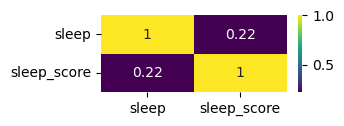

In [46]:
data1=data.set_index('date')
data1=data1.drop(['userId'],axis=1)
corr_df=data1.corr(numeric_only=True,method = 'pearson')
plt.figure(figsize=(3,1))
sns.heatmap(corr_df.loc[['sleep','sleep_score'],['sleep','sleep_score']], cmap='viridis',annot=True)
plt.show()
# 2020년도 수면점수와 주관적 수면 점수는 0.22로 양의 상관관계를 가지고 있다.

## sleep_score 기준 이진분류
- origin : 0.952
    - 기준 : sleep_score 55점 (중앙값)
- origin/total sleep time : 0.862
    - 기준 : sleep_score/total sleep time 0.002595014321518081점 (중앙값)

### origin

In [58]:
data=pd.read_csv('../last.csv')
data=data.drop('Unnamed: 0',axis=1)
data['total_sleep_time']=data['lightsleepduration']+data['deepsleepduration']+data['remsleepduration']
data['sleep_classes'] = data['sleep_score'].apply(lambda x: 1 if x>=55 else 0)

In [59]:
data['sleep_score'].median()
# 중앙값은 55점이다.

55.0

In [60]:
data.value_counts('sleep_classes')
# 클래스 분포는 254 : 250이다.

sleep_classes
1    254
0    250
dtype: int64

1. total_sleep_time (0.410502)
2. breathing_disturbances_intensity (0.155991)
3. remsleepduration (0.134970)
4. lightsleepduration (0.079479)
5. deepsleepduration (0.029469)
6. wakeupduration (0.022531)
7. rr_min (0.020744)
8. rr_max (0.019546)
9. durationtosleep (0.015896)
10. snoringepisodecount (0.011084)
11. snoring (0.009373)
12. hr_min (0.008889)
13. hr_average (0.008252)
14. pmEmotion (0.007929)
15. sleep (0.007643)
16. hr_max (0.007400)
17. cAmount(ml) (0.006604)
18. amEmotion (0.005702)
19. wakeupcount (0.005566)
20. rr_average (0.005434)
21. amCondition (0.005389)
22. sleepProblem (0.005293)
23. pmStress (0.004669)
24. pmFatigue (0.004517)
25. dream (0.003089)
26. durationtowakeup (0.002166)
27. aAmount(ml) (0.001873)


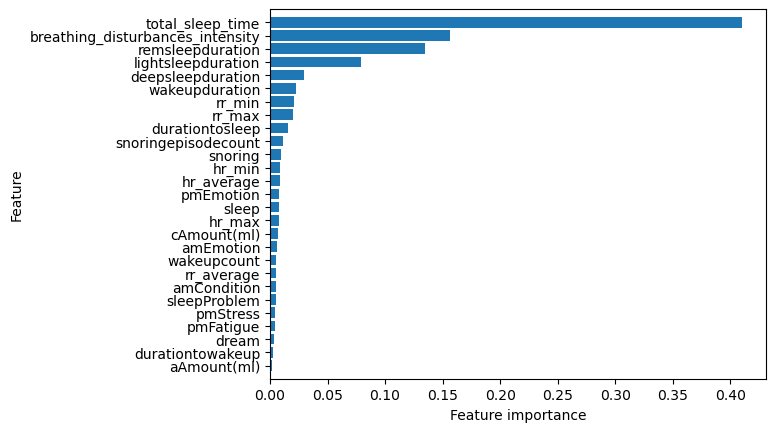

---------------------------------
정확도 :  0.9520958083832335


In [61]:
col=data.columns[3:-1]
X=data[col]
X=X.drop(['caffeine','alcohol','sleep_score','startDt', 'endDt','lastUpdate'],axis=1)
X=X.fillna(-1)
y=data['sleep_classes']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

model = RandomForestClassifier(random_state=100)
model.fit(X_train, y_train)

# 변수 중요도를 계산합니다.
importances = model.feature_importances_
# 변수 중요도를 내림차순으로 정렬합니다.
indices = np.argsort(importances)[::-1]

# 변수 중요도 및 변수 이름을 출력합니다.
for f in range(X_train.shape[1]):
    print("%d. %s (%f)" % (f + 1, X_train.columns[indices[f]], importances[indices[f]]))
n_features = X_train.shape[1]
plt.barh(np.arange(n_features),sorted(model.feature_importances_),align='center')
plt.yticks(np.arange(n_features)[::-1],X.columns[indices])
plt.xlabel("Feature importance")
plt.ylabel('Feature')
plt.ylim(-1,n_features)
plt.show()

predictions=model.predict(X_test)
print("---------------------------------")
print('정확도 : ', accuracy_score(y_test,predictions)) ## 테스트 성능 평가 점수(Accuracy)

### origin/total


In [63]:
data=pd.read_csv('../last.csv')
data=data.drop('Unnamed: 0',axis=1)
data['total_sleep_time']=data['lightsleepduration']+data['deepsleepduration']+data['remsleepduration']
for x in ['wakeupduration','lightsleepduration', 'deepsleepduration', 'wakeupcount','durationtosleep', 'remsleepduration',
       'breathing_disturbances_intensity', 'snoring', 'snoringepisodecount','sleep_score']:
    data[x]=data[x]/data['total_sleep_time']
data['sleep_score'].median()

0.002595014321518081

sleep_classes
0    252
1    252
dtype: int64

1. breathing_disturbances_intensity (0.127099)
2. wakeupduration (0.097892)
3. wakeupcount (0.089322)
4. durationtosleep (0.085237)
5. remsleepduration (0.079929)
6. deepsleepduration (0.064175)
7. lightsleepduration (0.058491)
8. hr_min (0.037089)
9. rr_max (0.034485)
10. hr_average (0.031546)
11. hr_max (0.030298)
12. rr_min (0.024735)
13. snoring (0.024726)
14. snoringepisodecount (0.023617)
15. rr_average (0.021376)
16. cAmount(ml) (0.020800)
17. dream (0.020586)
18. pmEmotion (0.018188)
19. sleep (0.017590)
20. amEmotion (0.016022)
21. sleepProblem (0.015855)
22. pmStress (0.014629)
23. durationtowakeup (0.014456)
24. amCondition (0.014423)
25. pmFatigue (0.012044)
26. aAmount(ml) (0.005390)


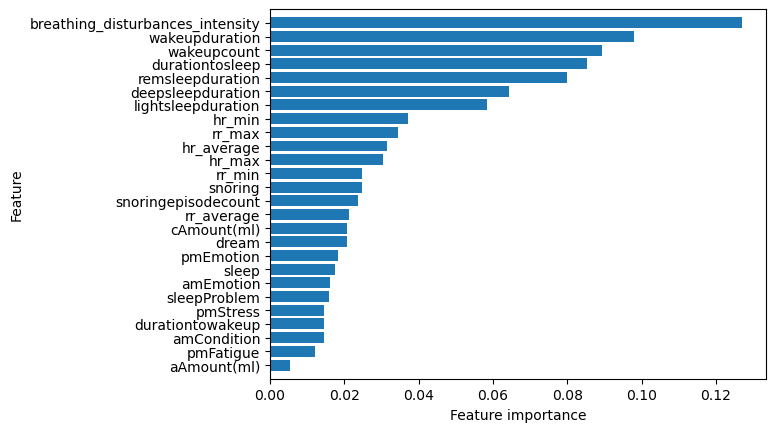

---------------------------------
정확도 :  0.8622754491017964


In [64]:
data=pd.read_csv('../last.csv')
data=data.drop('Unnamed: 0',axis=1)
data['total_sleep_time']=data['lightsleepduration']+data['deepsleepduration']+data['remsleepduration']
for x in ['wakeupduration','lightsleepduration', 'deepsleepduration', 'wakeupcount','durationtosleep', 'remsleepduration',
       'breathing_disturbances_intensity', 'snoring', 'snoringepisodecount','sleep_score']:
    data[x]=data[x]/data['total_sleep_time']
data['sleep_classes'] = data['sleep_score'].apply(lambda x: 1 if x>=0.002595014321518081 else 0)
display(data.value_counts('sleep_classes'))
col=data.columns[3:-1]
X=data[col]
X=X.drop(['caffeine','alcohol','sleep_score','startDt', 'endDt','lastUpdate','total_sleep_time'],axis=1)
X=X.fillna(-1)
X = X.clip(lower=0, upper=1e6)
y=data[data.columns[-1]]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

model = RandomForestClassifier(random_state=100)
model.fit(X_train, y_train)

# 변수 중요도를 계산합니다.
importances = model.feature_importances_
# 변수 중요도를 내림차순으로 정렬합니다.
indices = np.argsort(importances)[::-1]

# 변수 중요도 및 변수 이름을 출력합니다.
for f in range(X_train.shape[1]):
    print("%d. %s (%f)" % (f + 1, X_train.columns[indices[f]], importances[indices[f]]))
n_features = X_train.shape[1]
plt.barh(np.arange(n_features),sorted(model.feature_importances_),align='center')
plt.yticks(np.arange(n_features)[::-1],X_train.columns[indices])
plt.xlabel("Feature importance")
plt.ylabel('Feature')
plt.ylim(-1,n_features)
plt.show()

predictions=model.predict(X_test)
print("---------------------------------")
print('정확도 : ', accuracy_score(y_test,predictions)) ## 테스트 성능 평가 점수(Accuracy)

## deepsleepduration 기준 이진분류
- origin : 0.790
    - 기준 : deepsleepduration 5370 (중앙값)
- origin/total sleep time : 0.862
    - 기준 : deepsleepduration/total sleep time 0.2673794848818764 (중앙값)

### origin

In [65]:
data=pd.read_csv('../last.csv')
data=data.drop('Unnamed: 0',axis=1)
data['deepsleepduration'].median()

5370.0

sleep_classes
0    252
1    252
dtype: int64

1. total_sleep_time (0.112164)
2. lightsleepduration (0.095469)
3. remsleepduration (0.089668)
4. rr_average (0.069967)
5. hr_average (0.067904)
6. breathing_disturbances_intensity (0.056425)
7. hr_min (0.048891)
8. snoring (0.045224)
9. snoringepisodecount (0.042908)
10. rr_max (0.037671)
11. cAmount(ml) (0.037046)
12. durationtosleep (0.034385)
13. wakeupduration (0.032699)
14. hr_max (0.032595)
15. rr_min (0.025763)
16. dream (0.025160)
17. wakeupcount (0.016960)
18. sleepProblem (0.016085)
19. sleep (0.016073)
20. pmFatigue (0.015618)
21. pmStress (0.015612)
22. amCondition (0.015223)
23. aAmount(ml) (0.014505)
24. pmEmotion (0.014144)
25. amEmotion (0.013129)
26. durationtowakeup (0.008712)


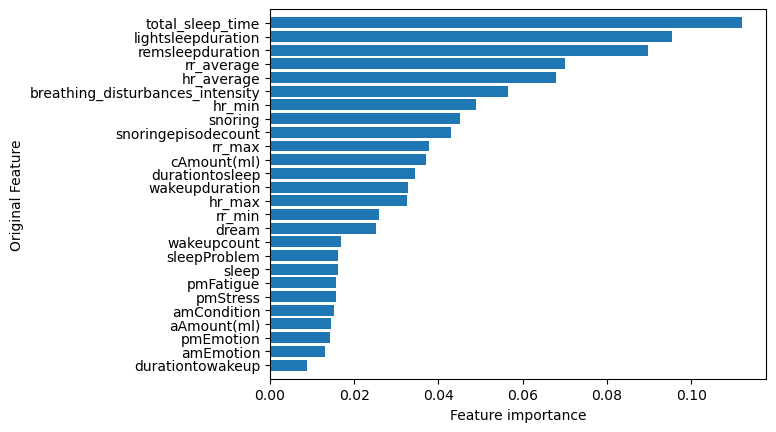

---------------------------------
정확도 :  0.7904191616766467


In [86]:
data=pd.read_csv('../last.csv')
data=data.drop('Unnamed: 0',axis=1)
data['total_sleep_time']=data['lightsleepduration']+data['deepsleepduration']+data['remsleepduration']
data['sleep_classes'] = data['deepsleepduration'].apply(lambda x: 1 if x>5370.0 else 0)
display(data.value_counts('sleep_classes'))
col=data.columns[3:-1]
X=data[col]
X=X.drop(['caffeine','alcohol','deepsleepduration','sleep_score','startDt', 'endDt',
       'lastUpdate'],axis=1)
X=X.fillna(-1)
y=data['sleep_classes']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

model = RandomForestClassifier(random_state=100)
model.fit(X_train, y_train)

# 변수 중요도를 계산합니다.
importances = model.feature_importances_
# 변수 중요도를 내림차순으로 정렬합니다.
indices = np.argsort(importances)[::-1]

# 변수 중요도 및 변수 이름을 출력합니다.
for f in range(X_train.shape[1]):
    print("%d. %s (%f)" % (f + 1, X_train.columns[indices[f]], importances[indices[f]]))
n_features = X_train.shape[1]
plt.barh(np.arange(n_features),sorted(model.feature_importances_),align='center')
plt.yticks(np.arange(n_features)[::-1],X_train.columns[indices])
plt.xlabel("Feature importance")
plt.ylabel('Original Feature')
plt.ylim(-1,n_features)
plt.show()

predictions=model.predict(X_test)
print("---------------------------------")
print('정확도 : ', accuracy_score(y_test,predictions)) ## 테스트 성능 평가 점수(Accuracy)

#### try 1 : not drop
- 기준 : deepsleepduration 5370점 (중앙값)
- 정확도 : 0.79

In [ ]:
data=pd.read_csv('../last.csv')
data=data.drop('Unnamed: 0',axis=1)
data['total_sleep_time']=data['lightsleepduration']+data['deepsleepduration']+data['remsleepduration']
data['deepsleepduration'].median()
data['sleep_classes'] = data['deepsleepduration'].apply(lambda x: 1 if x>5370.0 else 0)
display(data.value_counts('sleep_classes'))

sleep_classes
0    252
1    252
dtype: int64

sleep_classes
0    252
1    252
dtype: int64

1. remsleepduration (0.111302)
2. breathing_disturbances_intensity (0.082637)
3. lightsleepduration (0.075412)
4. rr_average (0.071210)
5. hr_average (0.065234)
6. hr_min (0.052301)
7. snoringepisodecount (0.050823)
8. hr_max (0.048680)
9. snoring (0.044107)
10. rr_max (0.041604)
11. cAmount(ml) (0.040846)
12. wakeupduration (0.040586)
13. durationtosleep (0.039318)
14. rr_min (0.030691)
15. wakeupcount (0.025564)
16. dream (0.023390)
17. sleepProblem (0.020874)
18. pmEmotion (0.020385)
19. amCondition (0.018923)
20. pmFatigue (0.017584)
21. pmStress (0.017503)
22. sleep (0.016210)
23. amEmotion (0.015903)
24. aAmount(ml) (0.015402)
25. durationtowakeup (0.013510)


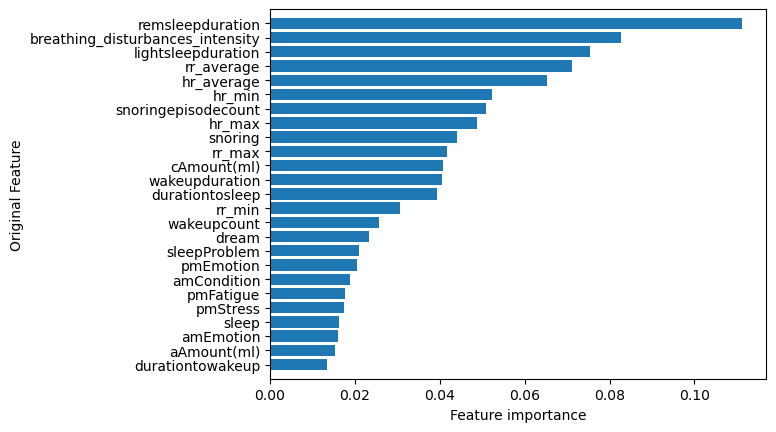

---------------------------------
정확도 :  0.7904191616766467


In [27]:
data=pd.read_csv('../last.csv')
data=data.drop('Unnamed: 0',axis=1)
data['total_sleep_time']=data['lightsleepduration']+data['deepsleepduration']+data['remsleepduration']
data['sleep_classes'] = data['deepsleepduration'].apply(lambda x: 1 if x>5370.0 else 0)
display(data.value_counts('sleep_classes'))
col=data.columns[3:-1]
X=data[col]
X=X.drop(['caffeine','alcohol','deepsleepduration','total_sleep_time','sleep_score','startDt', 'endDt',
       'lastUpdate'],axis=1)
X=X.fillna(-1)
y=data['sleep_classes']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

model = RandomForestClassifier(random_state=100)
model.fit(X_train, y_train)

# 변수 중요도를 계산합니다.
importances = model.feature_importances_
# 변수 중요도를 내림차순으로 정렬합니다.
indices = np.argsort(importances)[::-1]

# 변수 중요도 및 변수 이름을 출력합니다.
for f in range(X_train.shape[1]):
    print("%d. %s (%f)" % (f + 1, X_train.columns[indices[f]], importances[indices[f]]))
n_features = X_train.shape[1]
plt.barh(np.arange(n_features),sorted(model.feature_importances_),align='center')
plt.yticks(np.arange(n_features)[::-1],X_train.columns[indices])
plt.xlabel("Feature importance")
plt.ylabel('Original Feature')
plt.ylim(-1,n_features)
plt.show()

predictions=model.predict(X_test)
print("---------------------------------")
print('정확도 : ', accuracy_score(y_test,predictions)) ## 테스트 성능 평가 점수(Accuracy)

#### try 2 : lightsleepduration drop
- 기준 : deepsleepduration 5370점 (중앙값)
- 정확도 : 0.80

1. remsleepduration (0.114781)
2. hr_average (0.076591)
3. breathing_disturbances_intensity (0.075589)
4. rr_average (0.072664)
5. hr_min (0.056088)
6. durationtosleep (0.053582)
7. rr_max (0.051496)
8. hr_max (0.048645)
9. snoring (0.048441)
10. wakeupduration (0.045237)
11. snoringepisodecount (0.044075)
12. cAmount(ml) (0.043860)
13. rr_min (0.032845)
14. wakeupcount (0.029310)
15. dream (0.028614)
16. sleep (0.026215)
17. sleepProblem (0.022223)
18. pmFatigue (0.021216)
19. amCondition (0.020664)
20. pmEmotion (0.019987)
21. amEmotion (0.019654)
22. pmStress (0.018626)
23. aAmount(ml) (0.017796)
24. durationtowakeup (0.011800)


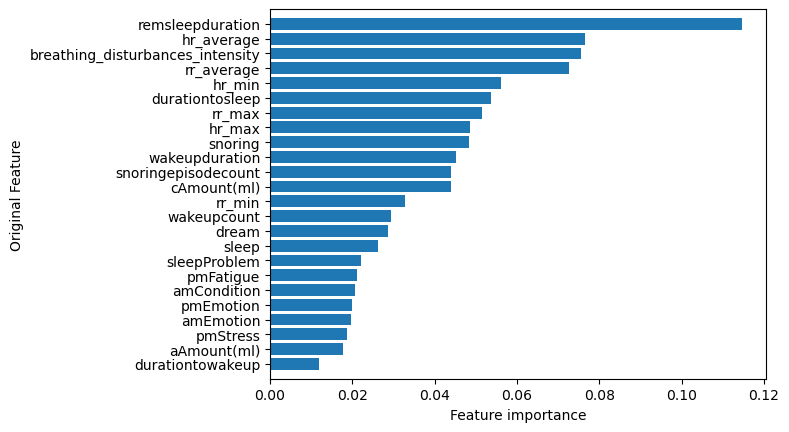

---------------------------------
정확도 :  0.8023952095808383


In [93]:
data=pd.read_csv('../last.csv')
data=data.drop('Unnamed: 0',axis=1)
data['total_sleep_time']=data['lightsleepduration']+data['deepsleepduration']+data['remsleepduration']
data['sleep_classes'] = data['deepsleepduration'].apply(lambda x: 1 if x>=5370.0 else 0)
col=data.columns[3:-1]
X=data[col]
X=X.drop(['caffeine','alcohol','lightsleepduration','deepsleepduration','total_sleep_time','sleep_score','startDt', 'endDt',
       'lastUpdate'],axis=1)
X=X.fillna(-1)
X = X.clip(lower=0, upper=1e6)
y=data['sleep_classes']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

model = RandomForestClassifier(random_state=100)
model.fit(X_train, y_train)

# 변수 중요도를 계산합니다.
importances = model.feature_importances_
# 변수 중요도를 내림차순으로 정렬합니다.
indices = np.argsort(importances)[::-1]

# 변수 중요도 및 변수 이름을 출력합니다.
for f in range(X_train.shape[1]):
    print("%d. %s (%f)" % (f + 1, X_train.columns[indices[f]], importances[indices[f]]))
n_features = X_train.shape[1]
plt.barh(np.arange(n_features),sorted(model.feature_importances_),align='center')
plt.yticks(np.arange(n_features)[::-1],X_train.columns[indices])
plt.xlabel("Feature importance")
plt.ylabel('Original Feature')
plt.ylim(-1,n_features)
plt.show()

predictions=model.predict(X_test)
print("---------------------------------")
print('정확도 : ', accuracy_score(y_test,predictions)) ## 테스트 성능 평가 점수(Accuracy)

#### try 3 : remsleepduration drop
- 기준 : deepsleepduration 5370점 (중앙값)
- 정확도 : 0.814

1. lightsleepduration (0.100893)
2. breathing_disturbances_intensity (0.090022)
3. hr_average (0.074365)
4. rr_average (0.065392)
5. hr_min (0.058362)
6. rr_max (0.052765)
7. snoring (0.052223)
8. hr_max (0.051117)
9. wakeupduration (0.046394)
10. snoringepisodecount (0.046174)
11. durationtosleep (0.045821)
12. cAmount(ml) (0.039141)
13. dream (0.033803)
14. rr_min (0.033055)
15. wakeupcount (0.027749)
16. pmEmotion (0.026250)
17. sleep (0.023233)
18. sleepProblem (0.022471)
19. pmFatigue (0.022445)
20. amEmotion (0.021287)
21. pmStress (0.020116)
22. amCondition (0.018935)
23. aAmount(ml) (0.016682)
24. durationtowakeup (0.011306)


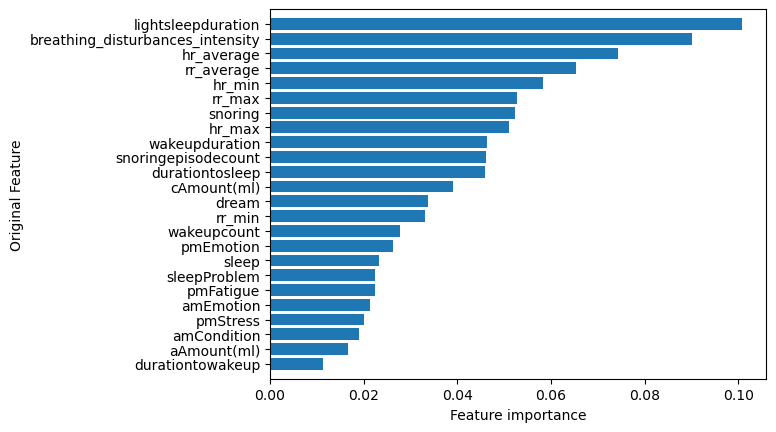

---------------------------------
정확도 :  0.8143712574850299


In [94]:
data=pd.read_csv('../last.csv')
data=data.drop('Unnamed: 0',axis=1)
data['total_sleep_time']=data['lightsleepduration']+data['deepsleepduration']+data['remsleepduration']
data['sleep_classes'] = data['deepsleepduration'].apply(lambda x: 1 if x>=5370.0 else 0)
col=data.columns[3:-1]
X=data[col]
X=X.drop(['caffeine','alcohol','remsleepduration','deepsleepduration','total_sleep_time','sleep_score','startDt', 'endDt',
       'lastUpdate'],axis=1)
X=X.fillna(-1)
X = X.clip(lower=0, upper=1e6)
y=data['sleep_classes']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

model = RandomForestClassifier(random_state=100)
model.fit(X_train, y_train)

# 변수 중요도를 계산합니다.
importances = model.feature_importances_
# 변수 중요도를 내림차순으로 정렬합니다.
indices = np.argsort(importances)[::-1]

# 변수 중요도 및 변수 이름을 출력합니다.
for f in range(X_train.shape[1]):
    print("%d. %s (%f)" % (f + 1, X_train.columns[indices[f]], importances[indices[f]]))
n_features = X_train.shape[1]
plt.barh(np.arange(n_features),sorted(model.feature_importances_),align='center')
plt.yticks(np.arange(n_features)[::-1],X_train.columns[indices])
plt.xlabel("Feature importance")
plt.ylabel('Original Feature')
plt.ylim(-1,n_features)
plt.show()

predictions=model.predict(X_test)
print("---------------------------------")
print('정확도 : ', accuracy_score(y_test,predictions)) ## 테스트 성능 평가 점수(Accuracy)

#### try4 : remsleepduration, lightsleepduration drop
- 기준 : deepsleepduration 5370점 (중앙값)
- 정확도 : 0.736

1. breathing_disturbances_intensity (0.095296)
2. hr_average (0.075148)
3. rr_average (0.074843)
4. rr_max (0.066552)
5. hr_min (0.064347)
6. hr_max (0.060768)
7. wakeupduration (0.054352)
8. snoring (0.054063)
9. durationtosleep (0.049668)
10. snoringepisodecount (0.049404)
11. cAmount(ml) (0.045712)
12. rr_min (0.038451)
13. dream (0.034884)
14. wakeupcount (0.031771)
15. sleep (0.029997)
16. pmEmotion (0.028328)
17. sleepProblem (0.026655)
18. pmFatigue (0.025397)
19. amCondition (0.021019)
20. amEmotion (0.020144)
21. aAmount(ml) (0.019853)
22. pmStress (0.019700)
23. durationtowakeup (0.013648)


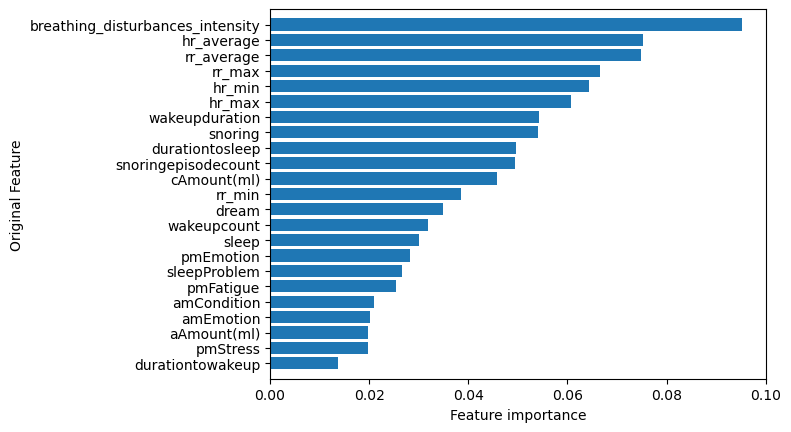

---------------------------------
정확도 :  0.7365269461077845


In [95]:
data=pd.read_csv('../last.csv')
data=data.drop('Unnamed: 0',axis=1)
data['total_sleep_time']=data['lightsleepduration']+data['deepsleepduration']+data['remsleepduration']
data['sleep_classes'] = data['deepsleepduration'].apply(lambda x: 1 if x>=5370.0 else 0)
col=data.columns[3:-1]
X=data[col]
X=X.drop(['caffeine','alcohol','remsleepduration','lightsleepduration','deepsleepduration','total_sleep_time','sleep_score','startDt', 'endDt',
       'lastUpdate'],axis=1)
X=X.fillna(-1)
X = X.clip(lower=0, upper=1e6)
y=data['sleep_classes']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

model = RandomForestClassifier(random_state=100)
model.fit(X_train, y_train)

# 변수 중요도를 계산합니다.
importances = model.feature_importances_
# 변수 중요도를 내림차순으로 정렬합니다.
indices = np.argsort(importances)[::-1]

# 변수 중요도 및 변수 이름을 출력합니다.
for f in range(X_train.shape[1]):
    print("%d. %s (%f)" % (f + 1, X_train.columns[indices[f]], importances[indices[f]]))
n_features = X_train.shape[1]
plt.barh(np.arange(n_features),sorted(model.feature_importances_),align='center')
plt.yticks(np.arange(n_features)[::-1],X_train.columns[indices])
plt.xlabel("Feature importance")
plt.ylabel('Original Feature')
plt.ylim(-1,n_features)
plt.show()

predictions=model.predict(X_test)
print("---------------------------------")
print('정확도 : ', accuracy_score(y_test,predictions)) ## 테스트 성능 평가 점수(Accuracy)

### original/totalsleeptime

sleep_classes
0    252
1    252
dtype: int64

1. lightsleepduration (0.322885)
2. remsleepduration (0.080159)
3. hr_average (0.055610)
4. hr_min (0.049413)
5. snoringepisodecount (0.043052)
6. rr_average (0.042146)
7. breathing_disturbances_intensity (0.040750)
8. durationtosleep (0.039161)
9. snoring (0.038228)
10. wakeupduration (0.037362)
11. rr_min (0.032580)
12. wakeupcount (0.031869)
13. hr_max (0.028300)
14. rr_max (0.026928)
15. pmEmotion (0.018235)
16. cAmount(ml) (0.017535)
17. sleep (0.014497)
18. pmStress (0.013710)
19. pmFatigue (0.012513)
20. sleepProblem (0.010888)
21. amEmotion (0.010495)
22. amCondition (0.009396)
23. aAmount(ml) (0.008562)
24. durationtowakeup (0.008250)
25. dream (0.007475)


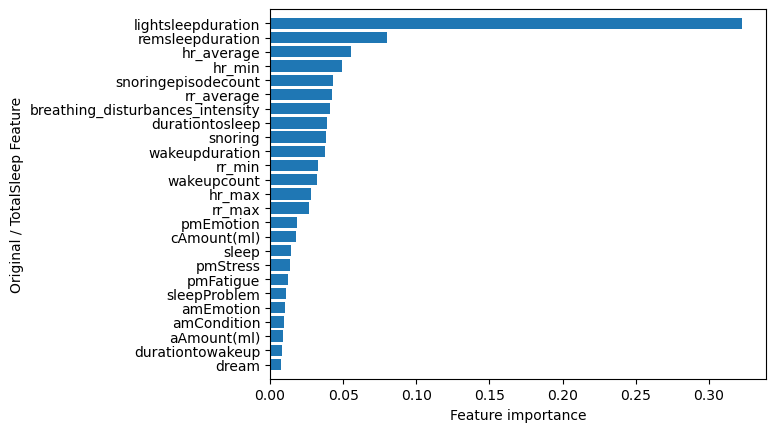

---------------------------------
정확도 :  0.8622754491017964


In [91]:
data=pd.read_csv('../last.csv')
data=data.drop('Unnamed: 0',axis=1)
data['total_sleep_time']=data['lightsleepduration']+data['deepsleepduration']+data['remsleepduration'] 
for x in ['wakeupduration','lightsleepduration', 'deepsleepduration', 'wakeupcount','durationtosleep', 'remsleepduration',
       'breathing_disturbances_intensity', 'snoring', 'snoringepisodecount']:
    data[x]=data[x]/data['total_sleep_time']  
data['sleep_classes'] = data['deepsleepduration'].apply(lambda x: 1 if x>=0.2673794848818764 else 0)
display(data.value_counts('sleep_classes'))
col=data.columns[3:-1]
X=data[col]
X=X.drop(['caffeine','alcohol','deepsleepduration','total_sleep_time','sleep_score','startDt', 'endDt',
       'lastUpdate'],axis=1)
X=X.fillna(-1)
X = X.clip(lower=0, upper=1e6)
y=data['sleep_classes']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

model = RandomForestClassifier(random_state=100)
model.fit(X_train, y_train)

# 변수 중요도를 계산합니다.
importances = model.feature_importances_
# 변수 중요도를 내림차순으로 정렬합니다.
indices = np.argsort(importances)[::-1]

# 변수 중요도 및 변수 이름을 출력합니다.
for f in range(X_train.shape[1]):
    print("%d. %s (%f)" % (f + 1, X_train.columns[indices[f]], importances[indices[f]]))
n_features = X_train.shape[1]
plt.barh(np.arange(n_features),sorted(model.feature_importances_),align='center')
plt.yticks(np.arange(n_features)[::-1],X_train.columns[indices])
plt.xlabel("Feature importance")
plt.ylabel('Original / TotalSleep Feature')
plt.ylim(-1,n_features)
plt.show()

predictions=model.predict(X_test)
print("---------------------------------")
print('정확도 : ', accuracy_score(y_test,predictions)) ## 테스트 성능 평가 점수(Accuracy)


#### try 1 : not drop
- 기준 : deepsleepduration/total sleep time 0.2673794848818764점 (중앙값)
- 정확도 : 0.862

In [67]:
data=pd.read_csv('../last.csv')
data=data.drop('Unnamed: 0',axis=1)
data['total_sleep_time']=data['lightsleepduration']+data['deepsleepduration']+data['remsleepduration'] 
for x in ['wakeupduration','lightsleepduration', 'deepsleepduration', 'wakeupcount','durationtosleep', 'remsleepduration',
       'breathing_disturbances_intensity', 'snoring', 'snoringepisodecount']:
    data[x]=data[x]/data['total_sleep_time']  

data['sleep_classes'] = data['deepsleepduration'].apply(lambda x: 1 if x>=0.2673794848818764 else 0)
data['deepsleepduration'].median()

0.2673794848818764

sleep_classes
0    252
1    252
dtype: int64

1. lightsleepduration (0.322885)
2. remsleepduration (0.080159)
3. hr_average (0.055610)
4. hr_min (0.049413)
5. snoringepisodecount (0.043052)
6. rr_average (0.042146)
7. breathing_disturbances_intensity (0.040750)
8. durationtosleep (0.039161)
9. snoring (0.038228)
10. wakeupduration (0.037362)
11. rr_min (0.032580)
12. wakeupcount (0.031869)
13. hr_max (0.028300)
14. rr_max (0.026928)
15. pmEmotion (0.018235)
16. cAmount(ml) (0.017535)
17. sleep (0.014497)
18. pmStress (0.013710)
19. pmFatigue (0.012513)
20. sleepProblem (0.010888)
21. amEmotion (0.010495)
22. amCondition (0.009396)
23. aAmount(ml) (0.008562)
24. durationtowakeup (0.008250)
25. dream (0.007475)


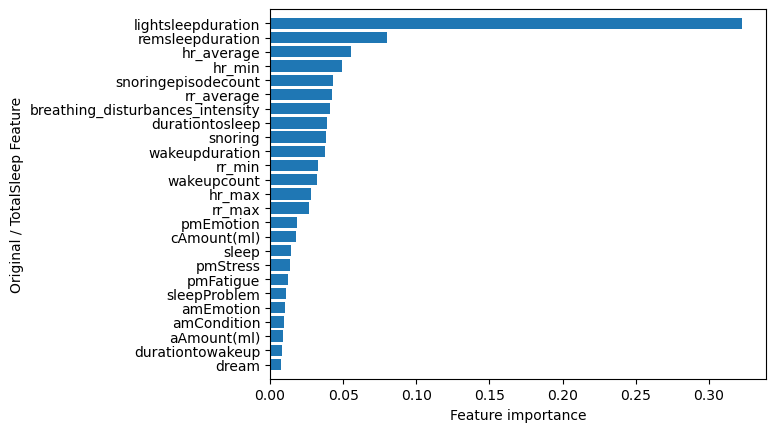

---------------------------------
정확도 :  0.8622754491017964


In [84]:
data=pd.read_csv('../last.csv')
data=data.drop('Unnamed: 0',axis=1)
data['total_sleep_time']=data['lightsleepduration']+data['deepsleepduration']+data['remsleepduration'] 
for x in ['wakeupduration','lightsleepduration', 'deepsleepduration', 'wakeupcount','durationtosleep', 'remsleepduration',
       'breathing_disturbances_intensity', 'snoring', 'snoringepisodecount']:
    data[x]=data[x]/data['total_sleep_time']  
data['sleep_classes'] = data['deepsleepduration'].apply(lambda x: 1 if x>=0.2673794848818764 else 0)
display(data.value_counts('sleep_classes'))
col=data.columns[3:-1]
X=data[col]
X=X.drop(['caffeine','alcohol','deepsleepduration','total_sleep_time','sleep_score','startDt', 'endDt',
       'lastUpdate'],axis=1)
X=X.fillna(-1)
X = X.clip(lower=0, upper=1e6)
y=data['sleep_classes']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

model = RandomForestClassifier(random_state=100)
model.fit(X_train, y_train)

# 변수 중요도를 계산합니다.
importances = model.feature_importances_
# 변수 중요도를 내림차순으로 정렬합니다.
indices = np.argsort(importances)[::-1]

# 변수 중요도 및 변수 이름을 출력합니다.
for f in range(X_train.shape[1]):
    print("%d. %s (%f)" % (f + 1, X_train.columns[indices[f]], importances[indices[f]]))
n_features = X_train.shape[1]
plt.barh(np.arange(n_features),sorted(model.feature_importances_),align='center')
plt.yticks(np.arange(n_features)[::-1],X_train.columns[indices])
plt.xlabel("Feature importance")
plt.ylabel('Original / TotalSleep Feature')
plt.ylim(-1,n_features)
plt.show()

predictions=model.predict(X_test)
print("---------------------------------")
print('정확도 : ', accuracy_score(y_test,predictions)) ## 테스트 성능 평가 점수(Accuracy)


#### try2 : lightsleepduration drop
- 기준 : deepsleepduration/total sleep time 0.2673794848818764점 (중앙값)
- 정확도 : 0.73

1. hr_average (0.088690)
2. hr_min (0.081100)
3. remsleepduration (0.069348)
4. rr_average (0.065212)
5. durationtosleep (0.064899)
6. wakeupduration (0.064102)
7. snoring (0.055799)
8. snoringepisodecount (0.052851)
9. wakeupcount (0.052306)
10. breathing_disturbances_intensity (0.051937)
11. hr_max (0.048760)
12. rr_max (0.044291)
13. rr_min (0.042589)
14. cAmount(ml) (0.030898)
15. pmEmotion (0.028517)
16. pmFatigue (0.020312)
17. pmStress (0.019663)
18. sleep (0.018954)
19. sleepProblem (0.018794)
20. amCondition (0.017919)
21. durationtowakeup (0.016545)
22. dream (0.015850)
23. amEmotion (0.015754)
24. aAmount(ml) (0.014909)


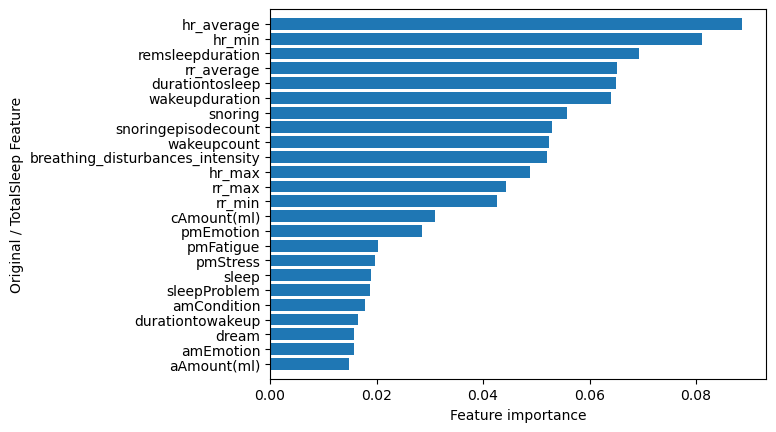

---------------------------------
정확도 :  0.7305389221556886


In [98]:
data=pd.read_csv('../last.csv')
data=data.drop('Unnamed: 0',axis=1)
data['total_sleep_time']=data['lightsleepduration']+data['deepsleepduration']+data['remsleepduration'] 
for x in ['wakeupduration','lightsleepduration', 'deepsleepduration', 'wakeupcount','durationtosleep', 'remsleepduration',
       'breathing_disturbances_intensity', 'snoring', 'snoringepisodecount']:
    data[x]=data[x]/data['total_sleep_time']  
data['sleep_classes'] = data['deepsleepduration'].apply(lambda x: 1 if x>=0.2673794848818764 else 0)

col=data.columns[3:-1]
X=data[col]
X=X.drop(['caffeine','alcohol','lightsleepduration','deepsleepduration','total_sleep_time','sleep_score','startDt', 'endDt',
       'lastUpdate'],axis=1)
X=X.fillna(-1)
X = X.clip(lower=0, upper=1e6)
y=data['sleep_classes']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

model = RandomForestClassifier(random_state=100)
model.fit(X_train, y_train)

# 변수 중요도를 계산합니다.
importances = model.feature_importances_
# 변수 중요도를 내림차순으로 정렬합니다.
indices = np.argsort(importances)[::-1]

# 변수 중요도 및 변수 이름을 출력합니다.
for f in range(X_train.shape[1]):
    print("%d. %s (%f)" % (f + 1, X_train.columns[indices[f]], importances[indices[f]]))
n_features = X_train.shape[1]
plt.barh(np.arange(n_features),sorted(model.feature_importances_),align='center')
plt.yticks(np.arange(n_features)[::-1],X_train.columns[indices])
plt.xlabel("Feature importance")
plt.ylabel('Original / TotalSleep Feature')
plt.ylim(-1,n_features)
plt.show()

predictions=model.predict(X_test)
print("---------------------------------")
print('정확도 : ', accuracy_score(y_test,predictions)) ## 테스트 성능 평가 점수(Accuracy)


#### try3 : remsleepduration drop
- 기준 : deepsleepduration/total sleep time 0.2673794848818764점 (중앙값)
- 정확도 : 0.85

1. lightsleepduration (0.306254)
2. hr_average (0.063069)
3. hr_min (0.055903)
4. snoringepisodecount (0.055606)
5. durationtosleep (0.047411)
6. wakeupduration (0.046076)
7. breathing_disturbances_intensity (0.043852)
8. rr_average (0.043762)
9. wakeupcount (0.039288)
10. snoring (0.038477)
11. hr_max (0.033229)
12. rr_max (0.032684)
13. rr_min (0.029634)
14. cAmount(ml) (0.021499)
15. pmStress (0.018508)
16. sleepProblem (0.017944)
17. pmEmotion (0.017525)
18. amEmotion (0.015393)
19. pmFatigue (0.014696)
20. sleep (0.013521)
21. amCondition (0.013208)
22. durationtowakeup (0.011380)
23. dream (0.011049)
24. aAmount(ml) (0.010033)


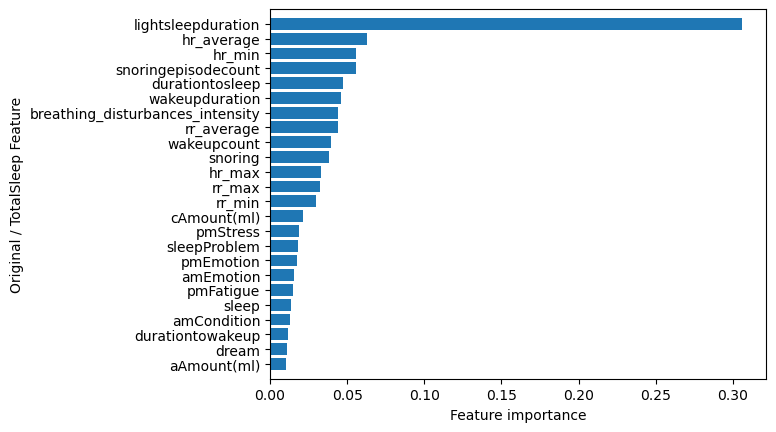

---------------------------------
정확도 :  0.8502994011976048


In [99]:
data=pd.read_csv('../last.csv')
data=data.drop('Unnamed: 0',axis=1)
data['total_sleep_time']=data['lightsleepduration']+data['deepsleepduration']+data['remsleepduration'] 
for x in ['wakeupduration','lightsleepduration', 'deepsleepduration', 'wakeupcount','durationtosleep', 'remsleepduration',
       'breathing_disturbances_intensity', 'snoring', 'snoringepisodecount']:
    data[x]=data[x]/data['total_sleep_time']  
data['sleep_classes'] = data['deepsleepduration'].apply(lambda x: 1 if x>=0.2673794848818764 else 0)

col=data.columns[3:-1]
X=data[col]
X=X.drop(['caffeine','alcohol','remsleepduration','deepsleepduration','total_sleep_time','sleep_score','startDt', 'endDt',
       'lastUpdate'],axis=1)
X=X.fillna(-1)
X = X.clip(lower=0, upper=1e6)
y=data['sleep_classes']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

model = RandomForestClassifier(random_state=100)
model.fit(X_train, y_train)

# 변수 중요도를 계산합니다.
importances = model.feature_importances_
# 변수 중요도를 내림차순으로 정렬합니다.
indices = np.argsort(importances)[::-1]

# 변수 중요도 및 변수 이름을 출력합니다.
for f in range(X_train.shape[1]):
    print("%d. %s (%f)" % (f + 1, X_train.columns[indices[f]], importances[indices[f]]))
n_features = X_train.shape[1]
plt.barh(np.arange(n_features),sorted(model.feature_importances_),align='center')
plt.yticks(np.arange(n_features)[::-1],X_train.columns[indices])
plt.xlabel("Feature importance")
plt.ylabel('Original / TotalSleep Feature')
plt.ylim(-1,n_features)
plt.show()

predictions=model.predict(X_test)
print("---------------------------------")
print('정확도 : ', accuracy_score(y_test,predictions)) ## 테스트 성능 평가 점수(Accuracy)


#### try4 : remsleepduration,lightsleepduration drop
- 기준 : deepsleepduration/total sleep time 0.2673794848818764점 (중앙값)
- 정확도 : 0.676

Index(['sleep', 'sleepProblem', 'dream', 'amCondition', 'amEmotion',
       'pmEmotion', 'pmStress', 'pmFatigue', 'cAmount(ml)', 'aAmount(ml)',
       'wakeupduration', 'wakeupcount', 'durationtosleep', 'durationtowakeup',
       'hr_average', 'hr_min', 'hr_max', 'rr_average', 'rr_min', 'rr_max',
       'breathing_disturbances_intensity', 'snoring', 'snoringepisodecount'],
      dtype='object')
1. hr_average (0.090531)
2. hr_min (0.079805)
3. wakeupduration (0.071166)
4. durationtosleep (0.067509)
5. rr_average (0.063433)
6. hr_max (0.062226)
7. wakeupcount (0.058822)
8. snoringepisodecount (0.058224)
9. snoring (0.054109)
10. breathing_disturbances_intensity (0.053974)
11. rr_max (0.047678)
12. rr_min (0.043265)
13. cAmount(ml) (0.039474)
14. pmEmotion (0.030753)
15. amCondition (0.026185)
16. pmStress (0.022098)
17. pmFatigue (0.022008)
18. sleepProblem (0.019224)
19. aAmount(ml) (0.018917)
20. amEmotion (0.018607)
21. dream (0.018006)
22. sleep (0.017347)
23. durationtowakeup (0.016

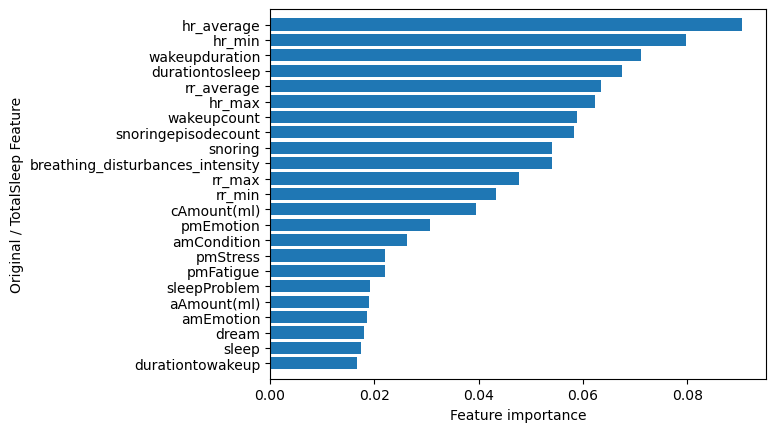

---------------------------------
정확도 :  0.6766467065868264


In [100]:
data=pd.read_csv('../last.csv')
data=data.drop('Unnamed: 0',axis=1)
data['total_sleep_time']=data['lightsleepduration']+data['deepsleepduration']+data['remsleepduration'] 
for x in ['wakeupduration','lightsleepduration', 'deepsleepduration', 'wakeupcount','durationtosleep', 'remsleepduration',
       'breathing_disturbances_intensity', 'snoring', 'snoringepisodecount']:
    data[x]=data[x]/data['total_sleep_time']  
data['sleep_classes'] = data['deepsleepduration'].apply(lambda x: 1 if x>=0.2673794848818764 else 0)

col=data.columns[3:-1]
X=data[col]
X=X.drop(['caffeine','alcohol','remsleepduration','lightsleepduration','deepsleepduration','total_sleep_time','sleep_score','startDt', 'endDt',
       'lastUpdate'],axis=1)
X=X.fillna(-1)
X = X.clip(lower=0, upper=1e6)
y=data['sleep_classes']
print(X.columns)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

model = RandomForestClassifier(random_state=100)
model.fit(X_train, y_train)

# 변수 중요도를 계산합니다.
importances = model.feature_importances_
# 변수 중요도를 내림차순으로 정렬합니다.
indices = np.argsort(importances)[::-1]

# 변수 중요도 및 변수 이름을 출력합니다.
for f in range(X_train.shape[1]):
    print("%d. %s (%f)" % (f + 1, X_train.columns[indices[f]], importances[indices[f]]))
n_features = X_train.shape[1]
plt.barh(np.arange(n_features),sorted(model.feature_importances_),align='center')
plt.yticks(np.arange(n_features)[::-1],X_train.columns[indices])
plt.xlabel("Feature importance")
plt.ylabel('Original / TotalSleep Feature')
plt.ylim(-1,n_features)
plt.show()

predictions=model.predict(X_test)
print("---------------------------------")
print('정확도 : ', accuracy_score(y_test,predictions)) ## 테스트 성능 평가 점수(Accuracy)


# 2018
- **'sleep_score','total_sleep_time', 'time_in_bed'을 제외한 수면관련 컬럼 데이터가 누락되어 있음)**


## 데이터 전처리
- 수면점수가 기록 안된 사람들이 있음. => 2019년도 자료 중 사용자 103,116,117에 대한 수면 데이터 누락
- 중복된 값 살려놓음
- 오전 설문 입력날짜와 수면시간 입력 끝나는 시간의 날짜가 일치하면 데이터 구축
- 거의 하루종일 수면데이터가 기록됨 => 누락시킬 수 없음

In [130]:
total_survey=pd.read_csv('../total_survey_1819.csv').drop('Unnamed: 0',axis=1)
total_survey['date_m']=total_survey['inputDt'].apply(lambda x: x.split(' ')[0])

In [134]:
total=pd.DataFrame()
for i in sorted(list(total_survey['userId'].unique())):
    print(i)
    #설문
    users1=total_survey[total_survey['userId']==i]
    users1=users1.reset_index()
    users1=users1.iloc[:,1:]
    #섭취일 date, 오전 설문 데이터 입력시간 inputDt, 저녁 설문 입력시간 night_inputDt

    #수면 
    data=pd.read_csv('../../user_sleep_2019_2018.csv')
    data['date']=data['endDt'].apply(lambda x : x.split(' ')[0]) #수면기록 끝나는 시간
    users2=data[data['userId']==i] 
    users2=users2.reset_index()
    users2=users2.iloc[:,1:]
    
    users=pd.DataFrame()
    #데이터 입력 시작 시간 startDt , 데이터 입력 종료 시간 endDt, 입력끝나는시간 date
    #print(users1.shape,users2.shape)
    #print(f"수면 데이터 중 중복된 데이터가 {users2.shape[0]-len(users2['date'].unique())}개이다.")

    for x in sorted(users1['date_m'].unique()):
        p=users2[users2['date']==x]
        if len(p)==0:
            continue
        elif len(p)==1:
            p=users2[users2['date']==x].reset_index()
            p=p.drop(['index','date','userId'],axis=1)
            aec1=users1[users1['date_m']==x].reset_index().drop('index',axis=1)
            datas=pd.concat([aec1,p],axis=1)
            users=pd.concat([users,datas])
        elif len(p)>1:
            p=users2[users2['date']==x].reset_index()
            p=p.drop(['index','date','userId'],axis=1)
            display(users1[users1['date_m']==x])
            display(p)
            print("#####")
            for y in range(len(p)):
                aec1=users1[users1['date_m']==x].reset_index().drop('index',axis=1)
                aec2=pd.DataFrame(p.iloc[y,:],index=p.columns).T.reset_index().drop('index',axis=1)
                datas=pd.concat([aec1,aec2],axis=1)
                users=pd.concat([users,datas])
                users=users.reset_index()
                users=users.iloc[:,1:]
    #if len(users)>=1:
    #    inddd=f"../1819_total/{i}.csv"
    #    users.to_csv(inddd)
    display(users.head())
#print(total.head())

1


,userId,night_inputDt,pmEmotion,pmStress,ifUnusual,breakfast,lunch,dinner,lateSnack,amCaffeine,...,device,sleep_score,total_sleep_time,time_in_bed,waso,wakeupcount,aal,movement_index,fragmentation_index,sleep_frag_index
0,1,2018-11-16 0:32,3.0,1.0,2.0,1.0,3.0,3.0,4.0,NaN,...,Fitbit,90.800478,22800,25110,NaN,NaN,NaN,NaN,NaN,NaN
0,1,2018-11-17 3:26,5.0,4.0,2.0,1.0,3.0,3.0,NaN,coffee,...,Fitbit,91.984231,21000,22830,NaN,NaN,NaN,NaN,NaN,NaN
0,1,2018-11-18 23:34,3.0,2.0,2.0,2.0,3.0,3.0,4.0,NaN,...,Fitbit,88.482385,19590,22140,NaN,NaN,NaN,NaN,NaN,NaN
0,1,2018-11-19 22:10,4.0,2.0,2.0,2.0,3.0,3.0,4.0,coffee,...,Fitbit,88.781665,22080,24870,NaN,NaN,NaN,NaN,NaN,NaN
0,1,2018-11-21 22:31,3.0,2.0,2.0,1.0,3.0,3.0,2.0,NaN,...,Fitbit,92.403101,17880,19350,NaN,NaN,NaN,NaN,NaN,NaN


2


,userId,night_inputDt,pmEmotion,pmStress,ifUnusual,breakfast,lunch,dinner,lateSnack,amCaffeine,...,device,sleep_score,total_sleep_time,time_in_bed,waso,wakeupcount,aal,movement_index,fragmentation_index,sleep_frag_index
0,2,2018-11-16 22:36,2.0,1.0,1.0,4.0,2.0,3.0,3.0,NaN,...,Fitbit,91.973970,12720,13830,NaN,NaN,NaN,NaN,NaN,NaN
0,2,2018-11-26 23:20,4.0,3.0,NaN,2.0,2.0,2.0,NaN,NaN,...,Fitbit,93.644068,13260,14160,NaN,NaN,NaN,NaN,NaN,NaN


3


,userId,night_inputDt,pmEmotion,pmStress,ifUnusual,breakfast,lunch,dinner,lateSnack,amCaffeine,...,device,sleep_score,total_sleep_time,time_in_bed,waso,wakeupcount,aal,movement_index,fragmentation_index,sleep_frag_index
0,3,2018-11-01 23:36,3.0,2.0,2.0,4.0,2.0,2.0,4.0,NaN,...,Fitbit,85.691318,15990,18660,NaN,NaN,NaN,NaN,NaN,NaN
0,3,2018-11-06 22:03,3.0,2.0,2.0,2.0,2.0,2.0,2.0,NaN,...,Fitbit,87.311828,24360,27900,NaN,NaN,NaN,NaN,NaN,NaN
0,3,2018-11-07 21:14,2.0,1.0,2.0,4.0,1.0,2.0,NaN,NaN,...,Fitbit,85.878301,22440,26130,NaN,NaN,NaN,NaN,NaN,NaN
0,3,2018-11-08 23:02,3.0,3.0,2.0,4.0,2.0,3.0,4.0,NaN,...,Fitbit,87.336915,34140,39090,NaN,NaN,NaN,NaN,NaN,NaN
0,3,2018-11-09 22:37,3.0,2.0,1.0,4.0,2.0,3.0,4.0,NaN,...,Fitbit,86.771964,26370,30390,NaN,NaN,NaN,NaN,NaN,NaN


4


,userId,night_inputDt,pmEmotion,pmStress,ifUnusual,breakfast,lunch,dinner,lateSnack,amCaffeine,...,device,sleep_score,total_sleep_time,time_in_bed,waso,wakeupcount,aal,movement_index,fragmentation_index,sleep_frag_index
0,4,2018-10-31 22:12,1.0,1.0,2.0,4.0,4.0,1.0,4.0,coffee,...,Fitbit,86.274510,22440,26010,NaN,NaN,NaN,NaN,NaN,NaN
0,4,2018-11-01 19:33,1.0,1.0,2.0,4.0,4.0,3.0,4.0,coffee,...,Fitbit,87.755102,25800,29400,NaN,NaN,NaN,NaN,NaN,NaN
0,4,2018-11-02 20:28,3.0,1.0,2.0,4.0,2.0,3.0,4.0,coffee,...,Fitbit,88.066298,23910,27150,NaN,NaN,NaN,NaN,NaN,NaN
0,4,2018-11-04 20:48,1.0,1.0,1.0,4.0,4.0,3.0,3.0,coffee,...,Fitbit,88.461539,21390,24180,NaN,NaN,NaN,NaN,NaN,NaN
0,4,2018-11-05 19:31,1.0,1.0,2.0,4.0,2.0,2.0,4.0,coffee,...,Fitbit,84.000000,15750,18750,NaN,NaN,NaN,NaN,NaN,NaN


5


,userId,night_inputDt,pmEmotion,pmStress,ifUnusual,breakfast,lunch,dinner,lateSnack,amCaffeine,...,device,sleep_score,total_sleep_time,time_in_bed,waso,wakeupcount,aal,movement_index,fragmentation_index,sleep_frag_index
0,5,2018-10-30 18:17,4.0,2.0,2.0,2.0,2.0,2.0,2.0,NaN,...,Fitbit,90.726817,21720,23940,NaN,NaN,NaN,NaN,NaN,NaN
0,5,2018-10-31 21:04,2.0,1.0,1.0,3.0,4.0,4.0,4.0,coffee,...,Fitbit,85.294118,16530,19380,NaN,NaN,NaN,NaN,NaN,NaN
0,5,2018-11-01 21:14,4.0,4.0,2.0,3.0,2.0,3.0,4.0,NaN,...,Fitbit,84.031008,16260,19350,NaN,NaN,NaN,NaN,NaN,NaN
0,5,2018-11-02 21:20,4.0,3.0,2.0,3.0,2.0,3.0,4.0,coffee,...,Fitbit,91.743119,6000,6540,NaN,NaN,NaN,NaN,NaN,NaN
0,5,2018-11-03 20:28,3.0,1.0,2.0,2.0,3.0,4.0,4.0,coffee,...,Fitbit,83.033932,12480,15030,NaN,NaN,NaN,NaN,NaN,NaN


6


,userId,night_inputDt,pmEmotion,pmStress,ifUnusual,breakfast,lunch,dinner,lateSnack,amCaffeine,...,device,sleep_score,total_sleep_time,time_in_bed,waso,wakeupcount,aal,movement_index,fragmentation_index,sleep_frag_index
0,6,2018-10-31 18:51,3.0,3.0,2.0,2.0,2.0,2.0,2.0,NaN,...,Fitbit,85.748792,21300,24840,NaN,NaN,NaN,NaN,NaN,NaN
0,6,2018-11-04 7:20,3.0,3.0,2.0,2.0,2.0,2.0,4.0,NaN,...,Fitbit,85.363248,23970,28080,NaN,NaN,NaN,NaN,NaN,NaN
0,6,2018-11-05 22:02,3.0,4.0,2.0,2.0,2.0,4.0,4.0,NaN,...,Fitbit,83.612040,22500,26910,NaN,NaN,NaN,NaN,NaN,NaN
0,6,2018-11-06 22:40,3.0,3.0,2.0,2.0,2.0,2.0,NaN,NaN,...,Fitbit,86.030268,22170,25770,NaN,NaN,NaN,NaN,NaN,NaN
0,6,2018-11-09 23:23,3.0,3.0,2.0,2.0,2.0,2.0,NaN,NaN,...,Fitbit,84.822390,23640,27870,NaN,NaN,NaN,NaN,NaN,NaN


7


,userId,night_inputDt,pmEmotion,pmStress,ifUnusual,breakfast,lunch,dinner,lateSnack,amCaffeine,...,device,sleep_score,total_sleep_time,time_in_bed,waso,wakeupcount,aal,movement_index,fragmentation_index,sleep_frag_index
0,7,2018-10-31 19:26,4.0,3.0,2.0,4.0,2.0,2.0,4.0,coffee,...,Fitbit,87.250554,23610,27060,NaN,NaN,NaN,NaN,NaN,NaN
0,7,2018-11-01 19:23,3.0,2.0,2.0,4.0,3.0,3.0,4.0,coffee,...,Fitbit,90.709291,27240,30030,NaN,NaN,NaN,NaN,NaN,NaN
0,7,2018-11-02 19:46,3.0,1.0,2.0,4.0,3.0,3.0,4.0,coffee,...,Fitbit,86.330498,42630,49380,NaN,NaN,NaN,NaN,NaN,NaN
0,7,2018-11-03 20:42,4.0,4.0,2.0,3.0,3.0,3.0,4.0,NaN,...,Fitbit,80.796586,17040,21090,NaN,NaN,NaN,NaN,NaN,NaN
0,7,2018-11-04 19:31,4.0,4.0,2.0,4.0,3.0,3.0,4.0,coffee,...,Fitbit,88.082902,20400,23160,NaN,NaN,NaN,NaN,NaN,NaN


8


,userId,night_inputDt,pmEmotion,pmStress,ifUnusual,breakfast,lunch,dinner,lateSnack,amCaffeine,...,device,sleep_score,total_sleep_time,time_in_bed,waso,wakeupcount,aal,movement_index,fragmentation_index,sleep_frag_index
0,8,2018-10-31 19:54,4.0,2.0,2.0,4.0,2.0,3.0,4.0,NaN,...,Fitbit,89.380531,18180,20340,NaN,NaN,NaN,NaN,NaN,NaN
0,8,2018-11-01 20:27,3.0,3.0,2.0,4.0,3.0,3.0,4.0,NaN,...,Fitbit,88.089330,10650,12090,NaN,NaN,NaN,NaN,NaN,NaN
0,8,2018-11-02 23:41,5.0,3.0,2.0,3.0,2.0,3.0,3.0,coffee,...,Fitbit,92.902542,26310,28320,NaN,NaN,NaN,NaN,NaN,NaN
0,8,2018-11-04 0:31,4.0,4.0,1.0,3.0,3.0,3.0,3.0,NaN,...,Fitbit,89.047098,24390,27390,NaN,NaN,NaN,NaN,NaN,NaN
0,8,2018-11-05 20:48,4.0,2.0,2.0,3.0,3.0,3.0,4.0,coffee,...,Fitbit,90.326633,21570,23880,NaN,NaN,NaN,NaN,NaN,NaN


9


,userId,night_inputDt,pmEmotion,pmStress,ifUnusual,breakfast,lunch,dinner,lateSnack,amCaffeine,...,device,sleep_score,total_sleep_time,time_in_bed,waso,wakeupcount,aal,movement_index,fragmentation_index,sleep_frag_index
0,9,2018-11-01 21:02,3.0,4.0,1.0,2.0,3.0,3.0,4.0,coffee,...,Fitbit,89.806320,26430,29430,NaN,NaN,NaN,NaN,NaN,NaN
0,9,2018-11-02 20:30,3.0,4.0,2.0,2.0,3.0,3.0,4.0,coffee,...,Fitbit,91.852825,20970,22830,NaN,NaN,NaN,NaN,NaN,NaN
0,9,2018-11-03 21:22,4.0,4.0,2.0,1.0,2.0,3.0,3.0,coffee,...,Fitbit,95.070423,20250,21300,NaN,NaN,NaN,NaN,NaN,NaN
0,9,2018-11-04 22:07,2.0,4.0,2.0,3.0,3.0,3.0,NaN,coffee,...,Fitbit,86.817326,27660,31860,NaN,NaN,NaN,NaN,NaN,NaN
0,9,2018-11-05 21:42,3.0,1.0,1.0,2.0,3.0,4.0,2.0,coffee,...,Fitbit,87.121212,20700,23760,NaN,NaN,NaN,NaN,NaN,NaN


10


,userId,night_inputDt,pmEmotion,pmStress,ifUnusual,breakfast,lunch,dinner,lateSnack,amCaffeine,...,device,sleep_score,total_sleep_time,time_in_bed,waso,wakeupcount,aal,movement_index,fragmentation_index,sleep_frag_index
0,10,2018-11-03 12:19,3.0,3.0,2.0,2.0,2.0,2.0,2.0,NaN,...,Fitbit,89.662921,23940,26700,NaN,NaN,NaN,NaN,NaN,NaN
0,10,2018-11-05 22:37,3.0,2.0,2.0,2.0,2.0,2.0,2.0,coffee,...,Fitbit,88.556701,25770,29100,NaN,NaN,NaN,NaN,NaN,NaN
0,10,2018-11-06 21:42,3.0,3.0,2.0,2.0,2.0,2.0,NaN,coffee,...,Fitbit,86.571429,18180,21000,NaN,NaN,NaN,NaN,NaN,NaN


11


,userId,night_inputDt,pmEmotion,pmStress,ifUnusual,breakfast,lunch,dinner,lateSnack,amCaffeine,...,device,sleep_score,total_sleep_time,time_in_bed,waso,wakeupcount,aal,movement_index,fragmentation_index,sleep_frag_index
0,11,2018-11-01 21:50,4.0,2.0,2.0,4.0,4.0,3.0,4.0,coffee,...,Fitbit,88.368984,19830,22440,NaN,NaN,NaN,NaN,NaN,NaN
0,11,2018-11-02 23:34,3.0,2.0,2.0,4.0,3.0,3.0,3.0,NaN,...,Fitbit,83.554377,18900,22620,NaN,NaN,NaN,NaN,NaN,NaN
0,11,2018-11-03 23:55,3.0,1.0,2.0,4.0,3.0,3.0,4.0,NaN,...,Fitbit,87.837838,3900,4440,NaN,NaN,NaN,NaN,NaN,NaN
0,11,2018-11-04 23:50,2.0,2.0,2.0,4.0,3.0,3.0,4.0,NaN,...,Fitbit,91.223022,19020,20850,NaN,NaN,NaN,NaN,NaN,NaN
0,11,2018-11-06 23:28,3.0,2.0,2.0,4.0,4.0,3.0,4.0,NaN,...,Fitbit,88.323917,28140,31860,NaN,NaN,NaN,NaN,NaN,NaN


12


,userId,night_inputDt,pmEmotion,pmStress,ifUnusual,breakfast,lunch,dinner,lateSnack,amCaffeine,...,device,sleep_score,total_sleep_time,time_in_bed,waso,wakeupcount,aal,movement_index,fragmentation_index,sleep_frag_index
0,12,2018-10-31 23:02,5.0,5.0,NaN,4.0,3.0,4.0,4.0,coffee,...,Fitbit,85.556781,23280,27210,NaN,NaN,NaN,NaN,NaN,NaN
0,12,2018-11-01 21:19,4.0,5.0,NaN,4.0,2.0,4.0,4.0,NaN,...,Fitbit,87.100457,22890,26280,NaN,NaN,NaN,NaN,NaN,NaN
0,12,2018-11-05 18:10,4.0,5.0,NaN,4.0,3.0,4.0,4.0,NaN,...,Fitbit,77.829313,25170,32340,NaN,NaN,NaN,NaN,NaN,NaN


13


,userId,night_inputDt,pmEmotion,pmStress,ifUnusual,breakfast,lunch,dinner,lateSnack,amCaffeine,...,device,sleep_score,total_sleep_time,time_in_bed,waso,wakeupcount,aal,movement_index,fragmentation_index,sleep_frag_index
0,13,2018-10-31 23:00,5.0,2.0,2.0,4.0,3.0,3.0,4.0,NaN,...,Fitbit,87.473002,24300,27780,NaN,NaN,NaN,NaN,NaN,NaN
0,13,2018-11-01 22:28,5.0,4.0,2.0,4.0,3.0,3.0,4.0,NaN,...,Fitbit,84.993532,19710,23190,NaN,NaN,NaN,NaN,NaN,NaN


14


,userId,night_inputDt,pmEmotion,pmStress,ifUnusual,breakfast,lunch,dinner,lateSnack,amCaffeine,...,device,sleep_score,total_sleep_time,time_in_bed,waso,wakeupcount,aal,movement_index,fragmentation_index,sleep_frag_index
0,14,2018-10-31 23:21,2.0,1.0,2.0,4.0,2.0,2.0,3.0,coffee,...,Fitbit,96.708861,22920,23700,NaN,NaN,NaN,NaN,NaN,NaN
0,14,2018-11-01 21:38,3.0,2.0,1.0,2.0,2.0,2.0,NaN,coffee,...,Fitbit,86.764706,24780,28560,NaN,NaN,NaN,NaN,NaN,NaN
0,14,2018-11-02 22:08,2.0,1.0,1.0,4.0,2.0,2.0,3.0,coffee,...,Fitbit,86.629526,9330,10770,NaN,NaN,NaN,NaN,NaN,NaN
0,14,2018-11-04 2:24,2.0,1.0,1.0,4.0,2.0,3.0,4.0,coffee,...,Fitbit,88.834952,10980,12360,NaN,NaN,NaN,NaN,NaN,NaN
0,14,2018-11-07 21:26,2.0,1.0,1.0,3.0,3.0,3.0,3.0,coffee,...,Fitbit,93.798450,21780,23220,NaN,NaN,NaN,NaN,NaN,NaN


15


,userId,night_inputDt,pmEmotion,pmStress,ifUnusual,breakfast,lunch,dinner,lateSnack,amCaffeine,...,device,sleep_score,total_sleep_time,time_in_bed,waso,wakeupcount,aal,movement_index,fragmentation_index,sleep_frag_index
0,15,2018-11-01 21:32,3.0,1.0,2.0,4.0,1.0,2.0,4.0,coffee,...,Fitbit,88.187920,19710,22350,NaN,NaN,NaN,NaN,NaN,NaN
0,15,2018-11-02 22:19,3.0,1.0,2.0,2.0,1.0,2.0,4.0,coffee,...,Fitbit,84.588235,21570,25500,NaN,NaN,NaN,NaN,NaN,NaN
0,15,2018-11-03 22:55,3.0,1.0,2.0,4.0,2.0,3.0,4.0,coffee,...,Fitbit,87.215909,18420,21120,NaN,NaN,NaN,NaN,NaN,NaN
0,15,2018-11-04 23:59,2.0,2.0,2.0,1.0,2.0,2.0,NaN,coffee,...,Fitbit,85.190616,17430,20460,NaN,NaN,NaN,NaN,NaN,NaN
0,15,2018-11-06 23:21,3.0,3.0,2.0,1.0,2.0,2.0,NaN,coffee,...,Fitbit,90.780142,26880,29610,NaN,NaN,NaN,NaN,NaN,NaN


16


,userId,night_inputDt,pmEmotion,pmStress,ifUnusual,breakfast,lunch,dinner,lateSnack,amCaffeine,...,device,sleep_score,total_sleep_time,time_in_bed,waso,wakeupcount,aal,movement_index,fragmentation_index,sleep_frag_index
0,16,2018-11-01 23:04,3.0,1.0,2.0,4.0,3.0,2.0,4.0,coffee,...,Fitbit,88.803089,41400,46620,NaN,NaN,NaN,NaN,NaN,NaN
0,16,2018-11-07 22:32,2.0,2.0,2.0,2.0,2.0,2.0,4.0,NaN,...,Fitbit,86.383602,17700,20490,NaN,NaN,NaN,NaN,NaN,NaN


17


,userId,night_inputDt,pmEmotion,pmStress,ifUnusual,breakfast,lunch,dinner,lateSnack,amCaffeine,...,device,sleep_score,total_sleep_time,time_in_bed,waso,wakeupcount,aal,movement_index,fragmentation_index,sleep_frag_index
0,17,2018-10-31 20:02,3.0,3.0,2.0,4.0,2.0,3.0,4.0,NaN,...,Fitbit,75.409836,2760,3660,NaN,NaN,NaN,NaN,NaN,NaN


18


,userId,night_inputDt,pmEmotion,pmStress,ifUnusual,breakfast,lunch,dinner,lateSnack,amCaffeine,...,device,sleep_score,total_sleep_time,time_in_bed,waso,wakeupcount,aal,movement_index,fragmentation_index,sleep_frag_index
0,18,2018-11-16 23:43,3.0,3.0,2.0,3.0,3.0,4.0,4.0,NaN,...,Fitbit,85.992218,19890,23130,NaN,NaN,NaN,NaN,NaN,NaN
0,18,2018-11-17 21:14,4.0,2.0,2.0,4.0,2.0,2.0,3.0,NaN,...,Fitbit,96.328294,26760,27780,NaN,NaN,NaN,NaN,NaN,NaN
0,18,2018-11-23 22:18,4.0,2.0,2.0,4.0,2.0,4.0,3.0,NaN,...,Fitbit,89.936102,16890,18780,NaN,NaN,NaN,NaN,NaN,NaN
0,18,2018-11-27 23:14,4.0,4.0,2.0,4.0,3.0,3.0,4.0,NaN,...,Fitbit,86.357243,18420,21330,NaN,NaN,NaN,NaN,NaN,NaN


19


,userId,night_inputDt,pmEmotion,pmStress,ifUnusual,breakfast,lunch,dinner,lateSnack,amCaffeine,...,device,sleep_score,total_sleep_time,time_in_bed,waso,wakeupcount,aal,movement_index,fragmentation_index,sleep_frag_index
0,19,2018-11-19 0:40,4.0,4.0,2.0,4.0,2.0,2.0,NaN,NaN,...,Fitbit,91.746411,23010,25080,NaN,NaN,NaN,NaN,NaN,NaN
0,19,2018-11-20 21:25,3.0,2.0,2.0,4.0,3.0,3.0,NaN,NaN,...,Fitbit,89.189189,3960,4440,NaN,NaN,NaN,NaN,NaN,NaN
0,19,2018-11-24 23:42,3.0,2.0,2.0,4.0,3.0,3.0,3.0,NaN,...,Fitbit,86.323851,23670,27420,NaN,NaN,NaN,NaN,NaN,NaN
0,19,2018-11-26 22:16,3.0,1.0,2.0,3.0,3.0,3.0,NaN,NaN,...,Fitbit,85.637823,28800,33630,NaN,NaN,NaN,NaN,NaN,NaN
0,19,2018-11-27 20:14,3.0,2.0,2.0,2.0,2.0,2.0,NaN,NaN,...,Fitbit,86.239782,18990,22020,NaN,NaN,NaN,NaN,NaN,NaN


20


,userId,night_inputDt,pmEmotion,pmStress,ifUnusual,breakfast,lunch,dinner,lateSnack,amCaffeine,...,device,sleep_score,total_sleep_time,time_in_bed,waso,wakeupcount,aal,movement_index,fragmentation_index,sleep_frag_index
0,20,2018-11-15 23:53,3.0,3.0,2.0,4.0,2.0,2.0,2.0,coffee,...,Fitbit,86.526316,24660,28500,NaN,NaN,NaN,NaN,NaN,NaN
0,20,2018-11-17 23:13,5.0,4.0,1.0,2.0,4.0,3.0,2.0,coffee,...,Fitbit,86.161880,19800,22980,NaN,NaN,NaN,NaN,NaN,NaN
0,20,2018-11-26 23:37,3.0,3.0,2.0,4.0,2.0,2.0,4.0,NaN,...,Fitbit,88.532676,21540,24330,NaN,NaN,NaN,NaN,NaN,NaN
0,20,2018-11-27 23:31,4.0,4.0,2.0,2.0,2.0,2.0,2.0,coffee,...,Fitbit,87.022016,22530,25890,NaN,NaN,NaN,NaN,NaN,NaN


21


,userId,night_inputDt,pmEmotion,pmStress,ifUnusual,breakfast,lunch,dinner,lateSnack,amCaffeine,...,device,sleep_score,total_sleep_time,time_in_bed,waso,wakeupcount,aal,movement_index,fragmentation_index,sleep_frag_index
0,21,2018-11-16 21:24,4.0,3.0,1.0,1.0,2.0,4.0,4.0,coffee,...,Fitbit,93.323217,18450,19770,NaN,NaN,NaN,NaN,NaN,NaN
0,21,2018-11-19 22:46,5.0,2.0,2.0,4.0,3.0,3.0,4.0,NaN,...,Fitbit,86.555698,20280,23430,NaN,NaN,NaN,NaN,NaN,NaN
0,21,2018-11-21 21:36,4.0,2.0,2.0,4.0,3.0,3.0,4.0,NaN,...,Fitbit,84.714549,13800,16290,NaN,NaN,NaN,NaN,NaN,NaN
0,21,2018-11-26 23:31,3.0,4.0,2.0,4.0,3.0,3.0,4.0,NaN,...,Fitbit,84.648188,23820,28140,NaN,NaN,NaN,NaN,NaN,NaN


22


,userId,night_inputDt,pmEmotion,pmStress,ifUnusual,breakfast,lunch,dinner,lateSnack,amCaffeine,...,device,sleep_score,total_sleep_time,time_in_bed,waso,wakeupcount,aal,movement_index,fragmentation_index,sleep_frag_index
0,22,2018-11-15 21:49,3.0,2.0,2.0,2.0,2.0,2.0,4.0,NaN,...,Fitbit,91.425390,24630,26940,NaN,NaN,NaN,NaN,NaN,NaN
0,22,2018-11-16 21:42,3.0,2.0,2.0,2.0,2.0,2.0,4.0,NaN,...,Fitbit,88.107037,26670,30270,NaN,NaN,NaN,NaN,NaN,NaN
0,22,2018-11-17 22:02,3.0,1.0,1.0,2.0,2.0,2.0,4.0,NaN,...,Fitbit,89.884089,25590,28470,NaN,NaN,NaN,NaN,NaN,NaN
0,22,2018-11-19 22:13,2.0,3.0,2.0,2.0,2.0,2.0,NaN,NaN,...,Fitbit,91.704649,30180,32910,NaN,NaN,NaN,NaN,NaN,NaN
0,22,2018-11-20 21:57,3.0,3.0,2.0,2.0,2.0,2.0,NaN,NaN,...,Fitbit,91.730981,24960,27210,NaN,NaN,NaN,NaN,NaN,NaN


23


,userId,night_inputDt,pmEmotion,pmStress,ifUnusual,breakfast,lunch,dinner,lateSnack,amCaffeine,...,device,sleep_score,total_sleep_time,time_in_bed,waso,wakeupcount,aal,movement_index,fragmentation_index,sleep_frag_index
0,23,2018-11-15 21:54,4.0,2.0,2.0,2.0,3.0,3.0,NaN,NaN,...,Fitbit,84.426230,18540,21960,NaN,NaN,NaN,NaN,NaN,NaN
0,23,2018-11-16 21:37,2.0,2.0,2.0,4.0,3.0,3.0,4.0,NaN,...,Fitbit,91.086691,22380,24570,NaN,NaN,NaN,NaN,NaN,NaN
0,23,2018-11-17 23:24,3.0,5.0,2.0,4.0,2.0,3.0,3.0,NaN,...,Fitbit,87.421384,33360,38160,NaN,NaN,NaN,NaN,NaN,NaN
0,23,2018-11-18 22:49,3.0,3.0,2.0,2.0,2.0,3.0,NaN,NaN,...,Fitbit,84.787736,21570,25440,NaN,NaN,NaN,NaN,NaN,NaN
0,23,2018-11-19 20:50,3.0,3.0,2.0,4.0,1.0,3.0,NaN,NaN,...,Fitbit,79.948586,18660,23340,NaN,NaN,NaN,NaN,NaN,NaN


24


,userId,night_inputDt,pmEmotion,pmStress,ifUnusual,breakfast,lunch,dinner,lateSnack,amCaffeine,...,device,sleep_score,total_sleep_time,time_in_bed,waso,wakeupcount,aal,movement_index,fragmentation_index,sleep_frag_index
0,24,2018-11-17 23:23,4.0,5.0,2.0,4.0,4.0,2.0,4.0,NaN,...,Fitbit,89.986825,20490,22770,NaN,NaN,NaN,NaN,NaN,NaN
0,24,2018-11-18 23:49,4.0,3.0,2.0,4.0,2.0,3.0,4.0,NaN,...,Fitbit,93.696581,26310,28080,NaN,NaN,NaN,NaN,NaN,NaN
0,24,2018-11-19 23:11,4.0,4.0,2.0,4.0,1.0,2.0,2.0,tea,...,Fitbit,92.700730,19050,20550,NaN,NaN,NaN,NaN,NaN,NaN
0,24,2018-11-20 23:15,3.0,3.0,NaN,4.0,3.0,2.0,4.0,tea,...,Fitbit,94.191919,22380,23760,NaN,NaN,NaN,NaN,NaN,NaN
0,24,2018-11-21 23:13,3.0,1.0,2.0,4.0,3.0,2.0,4.0,NaN,...,Fitbit,84.133916,17340,20610,NaN,NaN,NaN,NaN,NaN,NaN


25


,userId,night_inputDt,pmEmotion,pmStress,ifUnusual,breakfast,lunch,dinner,lateSnack,amCaffeine,...,device,sleep_score,total_sleep_time,time_in_bed,waso,wakeupcount,aal,movement_index,fragmentation_index,sleep_frag_index
0,25,2018-11-17 0:17,4.0,4.0,2.0,3.0,3.0,3.0,NaN,NaN,...,Fitbit,94.785847,30540,32220,NaN,NaN,NaN,NaN,NaN,NaN
0,25,2018-11-18 22:49,2.0,2.0,2.0,3.0,2.0,3.0,NaN,NaN,...,Fitbit,93.865031,18360,19560,NaN,NaN,NaN,NaN,NaN,NaN
0,25,2018-11-20 0:39,3.0,2.0,2.0,3.0,3.0,3.0,NaN,NaN,...,Fitbit,84.689922,26220,30960,NaN,NaN,NaN,NaN,NaN,NaN
0,25,2018-11-22 23:22,4.0,4.0,2.0,2.0,2.0,2.0,2.0,NaN,...,Fitbit,98.177083,22620,23040,NaN,NaN,NaN,NaN,NaN,NaN
0,25,2018-11-24 23:39,3.0,3.0,1.0,3.0,3.0,1.0,3.0,NaN,...,Fitbit,89.455782,31560,35280,NaN,NaN,NaN,NaN,NaN,NaN


26


,userId,night_inputDt,pmEmotion,pmStress,ifUnusual,breakfast,lunch,dinner,lateSnack,amCaffeine,...,device,sleep_score,total_sleep_time,time_in_bed,waso,wakeupcount,aal,movement_index,fragmentation_index,sleep_frag_index
0,26,2018-11-15 22:17,2.0,3.0,2.0,1.0,2.0,3.0,3.0,NaN,...,Fitbit,88.328388,26790,30330,NaN,NaN,NaN,NaN,NaN,NaN
0,26,2018-11-16 20:19,3.0,2.0,1.0,4.0,3.0,3.0,2.0,NaN,...,Fitbit,89.428263,24870,27810,NaN,NaN,NaN,NaN,NaN,NaN
0,26,2018-11-17 23:00,3.0,2.0,2.0,2.0,2.0,3.0,4.0,NaN,...,Fitbit,86.907217,25290,29100,NaN,NaN,NaN,NaN,NaN,NaN
0,26,2018-11-18 19:51,4.0,4.0,2.0,4.0,2.0,3.0,NaN,NaN,...,Fitbit,88.004484,23550,26760,NaN,NaN,NaN,NaN,NaN,NaN
0,26,2018-11-19 22:11,4.0,3.0,2.0,4.0,3.0,3.0,2.0,NaN,...,Fitbit,87.081340,16380,18810,NaN,NaN,NaN,NaN,NaN,NaN


27


,userId,night_inputDt,pmEmotion,pmStress,ifUnusual,breakfast,lunch,dinner,lateSnack,amCaffeine,...,aAmount,date,sleep,inputDt,sleepProblem,dream,amCondition,amEmotion,total_CaffAmount,date_m
5,27,2018-11-20 22:34,2.0,1.0,2.0,4.0,3.0,3.0,4.0,NaN,...,NaN,2018-11-20,3.0,2018-11-21 10:25,4.0,2.0,1.0,1.0,NaN,2018-11-21


,startDt,endDt,device,sleep_score,total_sleep_time,time_in_bed,waso,wakeupcount,aal,movement_index,fragmentation_index,sleep_frag_index
0,2018-11-21 0:55,2018-11-21 8:29,Fitbit,85.333333,3840,4500,NaN,NaN,NaN,NaN,NaN,NaN
1,2018-11-21 3:25,2018-11-21 12:54,Fitbit,89.575290,20880,23310,NaN,NaN,NaN,NaN,NaN,NaN


#####


,userId,night_inputDt,pmEmotion,pmStress,ifUnusual,breakfast,lunch,dinner,lateSnack,amCaffeine,...,aAmount,date,sleep,inputDt,sleepProblem,dream,amCondition,amEmotion,total_CaffAmount,date_m
6,27,2018-11-21 22:37,1.0,1.0,NaN,4.0,2.0,1.0,4.0,NaN,...,NaN,2018-11-21,2.0,2018-11-22 10:28,4.0,2.0,1.0,2.0,NaN,2018-11-22


,startDt,endDt,device,sleep_score,total_sleep_time,time_in_bed,waso,wakeupcount,aal,movement_index,fragmentation_index,sleep_frag_index
0,2018-11-22 1:02,2018-11-22 8:28,Fitbit,87.617066,25260,28830,NaN,NaN,NaN,NaN,NaN,NaN
1,2018-11-22 0:11,2018-11-22 6:31,Fitbit,83.533448,14610,17490,NaN,NaN,NaN,NaN,NaN,NaN


#####


,userId,night_inputDt,pmEmotion,pmStress,ifUnusual,breakfast,lunch,dinner,lateSnack,amCaffeine,...,device,sleep_score,total_sleep_time,time_in_bed,waso,wakeupcount,aal,movement_index,fragmentation_index,sleep_frag_index
0,27,2018-11-15 22:33,1.0,1.0,2.0,4.0,1.0,2.0,4.0,NaN,...,Fitbit,90.44665,21870,24180,NaN,NaN,NaN,NaN,NaN,NaN
1,27,2018-11-16 22:43,1.0,1.0,2.0,4.0,2.0,1.0,4.0,NaN,...,Fitbit,88.061617,20580,23370,NaN,NaN,NaN,NaN,NaN,NaN
2,27,2018-11-17 22:34,2.0,1.0,2.0,4.0,4.0,2.0,4.0,NaN,...,Fitbit,86.913849,23910,27510,NaN,NaN,NaN,NaN,NaN,NaN
3,27,2018-11-18 23:45,1.0,1.0,2.0,4.0,4.0,3.0,4.0,NaN,...,Fitbit,91.025641,17040,18720,NaN,NaN,NaN,NaN,NaN,NaN
4,27,2018-11-19 22:44,1.0,1.0,NaN,4.0,2.0,3.0,4.0,NaN,...,Fitbit,89.900427,18960,21090,NaN,NaN,NaN,NaN,NaN,NaN


28


,userId,night_inputDt,pmEmotion,pmStress,ifUnusual,breakfast,lunch,dinner,lateSnack,amCaffeine,...,device,sleep_score,total_sleep_time,time_in_bed,waso,wakeupcount,aal,movement_index,fragmentation_index,sleep_frag_index
0,28,2018-11-15 23:59,4.0,2.0,2.0,4.0,3.0,3.0,3.0,NaN,...,Fitbit,88.509317,17100,19320,NaN,NaN,NaN,NaN,NaN,NaN
0,28,2018-11-17 21:27,4.0,2.0,1.0,2.0,1.0,2.0,NaN,caffeinated drink,...,Fitbit,91.501104,24870,27180,NaN,NaN,NaN,NaN,NaN,NaN
0,28,2018-11-18 22:55,4.0,4.0,1.0,2.0,3.0,3.0,NaN,coffee,...,Fitbit,88.582183,21180,23910,NaN,NaN,NaN,NaN,NaN,NaN
0,28,2018-11-19 22:59,4.0,4.0,2.0,2.0,3.0,3.0,1.0,NaN,...,Fitbit,87.987013,24390,27720,NaN,NaN,NaN,NaN,NaN,NaN
0,28,2018-11-20 23:29,3.0,2.0,2.0,4.0,2.0,4.0,3.0,NaN,...,Fitbit,87.817259,20760,23640,NaN,NaN,NaN,NaN,NaN,NaN


29


,userId,night_inputDt,pmEmotion,pmStress,ifUnusual,breakfast,lunch,dinner,lateSnack,amCaffeine,...,device,sleep_score,total_sleep_time,time_in_bed,waso,wakeupcount,aal,movement_index,fragmentation_index,sleep_frag_index
0,29,2018-11-16 21:40,3.0,1.0,2.0,4.0,3.0,4.0,4.0,NaN,...,Fitbit,87.117347,20490,23520,NaN,NaN,NaN,NaN,NaN,NaN
0,29,2018-11-17 23:23,3.0,1.0,2.0,4.0,4.0,3.0,4.0,NaN,...,Fitbit,80.054645,8790,10980,NaN,NaN,NaN,NaN,NaN,NaN
0,29,2018-11-20 23:29,2.0,1.0,2.0,3.0,2.0,4.0,4.0,NaN,...,Fitbit,83.210784,20370,24480,NaN,NaN,NaN,NaN,NaN,NaN
0,29,2018-11-23 21:25,3.0,2.0,2.0,4.0,2.0,4.0,4.0,NaN,...,Fitbit,91.208791,19920,21840,NaN,NaN,NaN,NaN,NaN,NaN
0,29,2018-11-26 23:15,4.0,3.0,2.0,3.0,2.0,2.0,4.0,coffee,...,Fitbit,97.074468,21900,22560,NaN,NaN,NaN,NaN,NaN,NaN


30


,userId,night_inputDt,pmEmotion,pmStress,ifUnusual,breakfast,lunch,dinner,lateSnack,amCaffeine,...,device,sleep_score,total_sleep_time,time_in_bed,waso,wakeupcount,aal,movement_index,fragmentation_index,sleep_frag_index
0,30,2018-11-15 23:23,3.0,2.0,2.0,4.0,1.0,3.0,4.0,NaN,...,Fitbit,88.925620,16140,18150,NaN,NaN,NaN,NaN,NaN,NaN
0,30,2018-11-16 22:26,3.0,2.0,1.0,3.0,3.0,1.0,1.0,NaN,...,Fitbit,90.866511,23280,25620,NaN,NaN,NaN,NaN,NaN,NaN
0,30,2018-11-17 21:26,4.0,3.0,1.0,3.0,3.0,2.0,4.0,NaN,...,Fitbit,86.547085,28950,33450,NaN,NaN,NaN,NaN,NaN,NaN
0,30,2018-11-18 22:55,4.0,4.0,1.0,3.0,3.0,3.0,4.0,NaN,...,Fitbit,85.731707,21090,24600,NaN,NaN,NaN,NaN,NaN,NaN
0,30,2018-11-20 22:49,3.0,3.0,2.0,3.0,3.0,3.0,4.0,NaN,...,Fitbit,88.324324,24510,27750,NaN,NaN,NaN,NaN,NaN,NaN


101


""


102


,userId,night_inputDt,pmEmotion,pmStress,ifUnusual,breakfast,lunch,dinner,lateSnack,amCaffeine,...,aAmount,date,sleep,inputDt,sleepProblem,dream,amCondition,amEmotion,total_CaffAmount,date_m
6,102,2019-12-15 22:16,4.0,5.0,1.0,3.0,3.0,3.0,3.0,NaN,...,NaN,2019-12-15,2.0,2019-12-16 9:20,2.0,2.0,2.0,3.0,NaN,2019-12-16


,startDt,endDt,device,sleep_score,total_sleep_time,time_in_bed,waso,wakeupcount,aal,movement_index,fragmentation_index,sleep_frag_index
0,2019-12-16 0:23,2019-12-16 9:23,Actigraph,82.44,26760,32460,5700.0,3.0,31.67,6.412,25.0,31.412
1,2019-12-16 10:41,2019-12-16 20:56,Actigraph,97.89,36120,36900,780.0,2.0,6.50,12.060,0.0,12.060


#####


,userId,night_inputDt,pmEmotion,pmStress,ifUnusual,breakfast,lunch,dinner,lateSnack,amCaffeine,...,device,sleep_score,total_sleep_time,time_in_bed,waso,wakeupcount,aal,movement_index,fragmentation_index,sleep_frag_index
0,102,2019-12-15 22:16,4.0,5.0,1.0,3.0,3.0,3.0,3.0,NaN,...,Actigraph,82.44,26760,32460,5700.0,3.0,31.67,6.412,25.0,31.412
1,102,2019-12-15 22:16,4.0,5.0,1.0,3.0,3.0,3.0,3.0,NaN,...,Actigraph,97.89,36120,36900,780.0,2.0,6.5,12.06,0.0,12.06


103


""


104


,userId,night_inputDt,pmEmotion,pmStress,ifUnusual,breakfast,lunch,dinner,lateSnack,amCaffeine,...,aAmount,date,sleep,inputDt,sleepProblem,dream,amCondition,amEmotion,total_CaffAmount,date_m
0,104,2019-12-04 23:55,2.0,2.0,2.0,3.0,2.0,4.0,4.0,NaN,...,NaN,2019-12-04,3.0,2019-12-05 7:15,1.0,4.0,2.0,2.0,NaN,2019-12-05


,startDt,endDt,device,sleep_score,total_sleep_time,time_in_bed,waso,wakeupcount,aal,movement_index,fragmentation_index,sleep_frag_index
0,2019-12-05 2:21,2019-12-05 7:05,Actigraph,96.48,16440,17040,600.0,8.0,1.25,4.930,0.0,4.930
1,2019-12-05 8:10,2019-12-05 17:29,Actigraph,98.03,32880,33540,660.0,4.0,2.75,1.431,0.0,1.431


#####


,userId,night_inputDt,pmEmotion,pmStress,ifUnusual,breakfast,lunch,dinner,lateSnack,amCaffeine,...,aAmount,date,sleep,inputDt,sleepProblem,dream,amCondition,amEmotion,total_CaffAmount,date_m
1,104,2019-12-05 23:41,3.0,3.0,2.0,3.0,3.0,4.0,4.0,tea,...,NaN,2019-12-05,3.0,2019-12-06 7:53,0.0,4.0,2.0,3.0,2.0,2019-12-06


,startDt,endDt,device,sleep_score,total_sleep_time,time_in_bed,waso,wakeupcount,aal,movement_index,fragmentation_index,sleep_frag_index
0,2019-12-05 18:16,2019-12-06 1:20,Actigraph,99.53,25320,25440,120.0,2.0,1.00,2.358,0.000,2.358
1,2019-12-06 1:45,2019-12-06 7:10,Actigraph,86.15,16800,19500,2700.0,20.0,2.25,6.769,14.286,21.055


#####


,userId,night_inputDt,pmEmotion,pmStress,ifUnusual,breakfast,lunch,dinner,lateSnack,amCaffeine,...,aAmount,date,sleep,inputDt,sleepProblem,dream,amCondition,amEmotion,total_CaffAmount,date_m
2,104,2019-12-07 0:08,5.0,3.0,2.0,3.0,4.0,4.0,3.0,tea,...,NaN,2019-12-07,3.0,2019-12-08 9:32,5.0,4.0,4.0,3.0,NaN,2019-12-08


,startDt,endDt,device,sleep_score,total_sleep_time,time_in_bed,waso,wakeupcount,aal,movement_index,fragmentation_index,sleep_frag_index
0,2019-12-07 13:51,2019-12-08 0:29,Actigraph,100.00,38280,38280,0.0,0.0,0.00,0.157,0.000,0.157
1,2019-12-08 1:15,2019-12-08 9:12,Actigraph,91.82,26280,28620,2340.0,22.0,1.77,7.547,8.696,16.243


#####


,userId,night_inputDt,pmEmotion,pmStress,ifUnusual,breakfast,lunch,dinner,lateSnack,amCaffeine,...,aAmount,date,sleep,inputDt,sleepProblem,dream,amCondition,amEmotion,total_CaffAmount,date_m
3,104,2019-12-08 23:17,4.0,4.0,2.0,4.0,3.0,3.0,4.0,NaN,...,NaN,2019-12-08,4.0,2019-12-09 8:46,1.0,2.0,4.0,3.0,NaN,2019-12-09


,startDt,endDt,device,sleep_score,total_sleep_time,time_in_bed,waso,wakeupcount,aal,movement_index,fragmentation_index,sleep_frag_index
0,2019-12-08 9:38,2019-12-09 1:10,Actigraph,100.00,55920,55920,0.0,0.0,0.00,1.180,0.000,1.180
1,2019-12-09 1:40,2019-12-09 7:23,Actigraph,92.13,18960,20580,1620.0,11.0,2.45,8.455,8.333,16.788
2,2019-12-09 9:03,2019-12-09 17:33,Actigraph,97.06,29700,30600,900.0,5.0,3.00,2.549,16.667,19.216
3,2019-12-09 18:46,2019-12-09 23:58,Actigraph,99.36,18600,18720,120.0,2.0,1.00,2.885,33.333,36.218


#####


,userId,night_inputDt,pmEmotion,pmStress,ifUnusual,breakfast,lunch,dinner,lateSnack,amCaffeine,...,aAmount,date,sleep,inputDt,sleepProblem,dream,amCondition,amEmotion,total_CaffAmount,date_m
4,104,2019-12-10 21:15,4.0,2.0,2.0,4.0,3.0,2.0,4.0,NaN,...,NaN,2019-12-10,4.0,2019-12-11 8:15,0.0,4.0,2.0,3.0,NaN,2019-12-11


,startDt,endDt,device,sleep_score,total_sleep_time,time_in_bed,waso,wakeupcount,aal,movement_index,fragmentation_index,sleep_frag_index
0,2019-12-10 7:26,2019-12-11 1:38,Actigraph,100.00,65520,65520,0.0,0.0,0.00,0.092,0.0,0.092
1,2019-12-11 2:03,2019-12-11 7:08,Actigraph,90.49,16560,18300,1740.0,11.0,2.64,11.803,0.0,11.803


#####


,userId,night_inputDt,pmEmotion,pmStress,ifUnusual,breakfast,lunch,dinner,lateSnack,amCaffeine,...,aAmount,date,sleep,inputDt,sleepProblem,dream,amCondition,amEmotion,total_CaffAmount,date_m
5,104,2019-12-11 23:40,4.0,2.0,2.0,3.0,3.0,4.0,3.0,coffee,...,NaN,2019-12-11,4.0,2019-12-12 9:01,2.0,2.0,4.0,3.0,2.0,2019-12-12


,startDt,endDt,device,sleep_score,total_sleep_time,time_in_bed,waso,wakeupcount,aal,movement_index,fragmentation_index,sleep_frag_index
0,2019-12-11 7:30,2019-12-12 0:48,Actigraph,100.00,62280,62280,0.0,0.0,0.00,0.000,0.000,0.000
1,2019-12-12 1:02,2019-12-12 6:30,Actigraph,96.95,19080,19680,600.0,6.0,1.67,5.183,14.286,19.469


#####


,userId,night_inputDt,pmEmotion,pmStress,ifUnusual,breakfast,lunch,dinner,lateSnack,amCaffeine,...,aAmount,date,sleep,inputDt,sleepProblem,dream,amCondition,amEmotion,total_CaffAmount,date_m
6,104,2019-12-14 21:44,4.0,4.0,1.0,4.0,2.0,3.0,4.0,NaN,...,2.0,2019-12-14,3.0,2019-12-15 7:53,2.0,1.0,4.0,4.0,NaN,2019-12-15


,startDt,endDt,device,sleep_score,total_sleep_time,time_in_bed,waso,wakeupcount,aal,movement_index,fragmentation_index,sleep_frag_index
0,2019-12-15 3:48,2019-12-15 7:06,Actigraph,94.44,11220,11880,660.0,7.0,1.57,10.606,0.000,10.606
1,2019-12-15 7:22,2019-12-15 17:51,Actigraph,96.03,36240,37740,1500.0,8.0,3.13,4.134,22.222,26.356
2,2019-12-15 20:05,2019-12-15 23:18,Actigraph,100.00,11580,11580,0.0,0.0,0.00,0.518,0.000,0.518


#####


,userId,night_inputDt,pmEmotion,pmStress,ifUnusual,breakfast,lunch,dinner,lateSnack,amCaffeine,...,aAmount,date,sleep,inputDt,sleepProblem,dream,amCondition,amEmotion,total_CaffAmount,date_m
8,104,2019-12-16 23:01,4.0,3.0,2.0,4.0,2.0,2.0,3.0,NaN,...,NaN,2019-12-16,4.0,2019-12-17 7:58,0.0,4.0,2.0,3.0,NaN,2019-12-17


,startDt,endDt,device,sleep_score,total_sleep_time,time_in_bed,waso,wakeupcount,aal,movement_index,fragmentation_index,sleep_frag_index
0,2019-12-16 7:05,2019-12-17 1:38,Actigraph,99.46,66420,66780,360.0,3.0,2.00,2.156,0.000,2.156
1,2019-12-17 3:11,2019-12-17 23:53,Actigraph,97.50,72660,74520,1860.0,14.0,2.21,3.060,6.667,9.727


#####


,userId,night_inputDt,pmEmotion,pmStress,ifUnusual,breakfast,lunch,dinner,lateSnack,amCaffeine,...,aAmount,date,sleep,inputDt,sleepProblem,dream,amCondition,amEmotion,total_CaffAmount,date_m
9,104,2019-12-17 23:29,4.0,4.0,1.0,4.0,2.0,4.0,4.0,NaN,...,NaN,2019-12-17,2.0,2019-12-18 8:31,2.0,4.0,1.0,4.0,NaN,2019-12-18


,startDt,endDt,device,sleep_score,total_sleep_time,time_in_bed,waso,wakeupcount,aal,movement_index,fragmentation_index,sleep_frag_index
0,2019-12-18 1:02,2019-12-18 4:58,Actigraph,97.46,13800,14160,360.0,6.0,1.0,11.017,14.286,25.303
1,2019-12-18 7:55,2019-12-18 17:50,Actigraph,100.00,35700,35700,0.0,0.0,0.0,4.706,0.000,4.706


#####


,userId,night_inputDt,pmEmotion,pmStress,ifUnusual,breakfast,lunch,dinner,lateSnack,amCaffeine,...,aAmount,date,sleep,inputDt,sleepProblem,dream,amCondition,amEmotion,total_CaffAmount,date_m
10,104,2019-12-18 23:37,4.0,4.0,2.0,4.0,3.0,4.0,2.0,coffee,...,NaN,2019-12-18,4.0,2019-12-19 13:15,0.0,4.0,2.0,4.0,2.0,2019-12-19


,startDt,endDt,device,sleep_score,total_sleep_time,time_in_bed,waso,wakeupcount,aal,movement_index,fragmentation_index,sleep_frag_index
0,2019-12-19 1:43,2019-12-19 6:51,Actigraph,89.29,16500,18480,1980.0,9.0,3.67,7.792,10.000,17.792
1,2019-12-19 7:03,2019-12-19 21:32,Actigraph,99.77,52020,52140,120.0,2.0,1.00,0.230,33.333,33.563


#####


,userId,night_inputDt,pmEmotion,pmStress,ifUnusual,breakfast,lunch,dinner,lateSnack,amCaffeine,...,aAmount,date,sleep,inputDt,sleepProblem,dream,amCondition,amEmotion,total_CaffAmount,date_m
14,104,2019-12-23 22:55,3.0,4.0,2.0,4.0,2.0,3.0,4.0,coffee,...,3.0,2019-12-23,3.0,2019-12-24 13:54,5.0,4.0,2.0,3.0,NaN,2019-12-24


,startDt,endDt,device,sleep_score,total_sleep_time,time_in_bed,waso,wakeupcount,aal,movement_index,fragmentation_index,sleep_frag_index
0,2019-12-24 0:09,2019-12-24 7:15,Actigraph,99.77,25500,25560,60.0,1.0,1.0,1.174,0.0,1.174
1,2019-12-24 13:00,2019-12-24 17:32,Actigraph,100.00,16320,16320,0.0,0.0,0.0,5.882,0.0,5.882
2,2019-12-24 19:35,2019-12-24 22:24,Actigraph,100.00,10140,10140,0.0,0.0,0.0,0.592,0.0,0.592


#####


,userId,night_inputDt,pmEmotion,pmStress,ifUnusual,breakfast,lunch,dinner,lateSnack,amCaffeine,...,device,sleep_score,total_sleep_time,time_in_bed,waso,wakeupcount,aal,movement_index,fragmentation_index,sleep_frag_index
0,104,2019-12-04 23:55,2.0,2.0,2.0,3.0,2.0,4.0,4.0,NaN,...,Actigraph,96.48,16440,17040,600.0,8.0,1.25,4.93,0.0,4.93
1,104,2019-12-04 23:55,2.0,2.0,2.0,3.0,2.0,4.0,4.0,NaN,...,Actigraph,98.03,32880,33540,660.0,4.0,2.75,1.431,0.0,1.431
2,104,2019-12-05 23:41,3.0,3.0,2.0,3.0,3.0,4.0,4.0,tea,...,Actigraph,99.53,25320,25440,120.0,2.0,1.0,2.358,0.0,2.358
3,104,2019-12-05 23:41,3.0,3.0,2.0,3.0,3.0,4.0,4.0,tea,...,Actigraph,86.15,16800,19500,2700.0,20.0,2.25,6.769,14.286,21.055
4,104,2019-12-07 0:08,5.0,3.0,2.0,3.0,4.0,4.0,3.0,tea,...,Actigraph,100.0,38280,38280,0.0,0.0,0.0,0.157,0.0,0.157


105


,userId,night_inputDt,pmEmotion,pmStress,ifUnusual,breakfast,lunch,dinner,lateSnack,amCaffeine,...,aAmount,date,sleep,inputDt,sleepProblem,dream,amCondition,amEmotion,total_CaffAmount,date_m
6,105,2019-12-10 23:32,5.0,4.0,2.0,3.0,4.0,3.0,4.0,NaN,...,NaN,2019-12-10,5.0,2019-12-11 8:30,0.0,4.0,3.0,3.0,NaN,2019-12-11


,startDt,endDt,device,sleep_score,total_sleep_time,time_in_bed,waso,wakeupcount,aal,movement_index,fragmentation_index,sleep_frag_index
0,2019-12-10 10:22,2019-12-11 4:56,Actigraph,98.03,65520,66840,1320.0,8.0,2.75,2.065,11.111,13.176
1,2019-12-11 5:15,2019-12-11 7:58,Actigraph,83.44,8160,9780,1620.0,10.0,2.70,11.656,18.182,29.838


#####


,userId,night_inputDt,pmEmotion,pmStress,ifUnusual,breakfast,lunch,dinner,lateSnack,amCaffeine,...,aAmount,date,sleep,inputDt,sleepProblem,dream,amCondition,amEmotion,total_CaffAmount,date_m
13,105,2019-12-17 23:40,5.0,5.0,2.0,3.0,3.0,3.0,4.0,NaN,...,NaN,2019-12-17,5.0,2019-12-18 11:58,0.0,4.0,5.0,5.0,NaN,2019-12-18


,startDt,endDt,device,sleep_score,total_sleep_time,time_in_bed,waso,wakeupcount,aal,movement_index,fragmentation_index,sleep_frag_index
0,2019-12-17 2:39,2019-12-18 1:45,Actigraph,95.17,79140,83160,4020.0,24.0,2.79,3.752,24.000,27.752
1,2019-12-18 2:01,2019-12-18 9:49,Actigraph,80.13,22500,28080,5580.0,26.0,3.58,10.897,14.815,25.712


#####


,userId,night_inputDt,pmEmotion,pmStress,ifUnusual,breakfast,lunch,dinner,lateSnack,amCaffeine,...,device,sleep_score,total_sleep_time,time_in_bed,waso,wakeupcount,aal,movement_index,fragmentation_index,sleep_frag_index
0,105,2019-12-08 23:32,3.0,5.0,1.0,4.0,3.0,4.0,4.0,NaN,...,Actigraph,92.7,63240,68220,4980.0,27.0,3.07,5.101,21.429,26.53
1,105,2019-12-09 22:38,5.0,5.0,2.0,3.0,4.0,3.0,4.0,coffee,...,Actigraph,97.05,82980,85500,2520.0,16.0,2.63,2.386,0.0,2.386
2,105,2019-12-10 23:32,5.0,4.0,2.0,3.0,4.0,3.0,4.0,NaN,...,Actigraph,98.03,65520,66840,1320.0,8.0,2.75,2.065,11.111,13.176
3,105,2019-12-10 23:32,5.0,4.0,2.0,3.0,4.0,3.0,4.0,NaN,...,Actigraph,83.44,8160,9780,1620.0,10.0,2.7,11.656,18.182,29.838
4,105,2019-12-11 23:18,5.0,5.0,2.0,3.0,3.0,3.0,4.0,NaN,...,Actigraph,97.42,61140,62760,1620.0,6.0,4.5,1.434,14.286,15.72


106


,userId,night_inputDt,pmEmotion,pmStress,ifUnusual,breakfast,lunch,dinner,lateSnack,amCaffeine,...,aAmount,date,sleep,inputDt,sleepProblem,dream,amCondition,amEmotion,total_CaffAmount,date_m
0,106,2020-02-01 4:05,5.0,4.0,2.0,3.0,3.0,3.0,4.0,NaN,...,NaN,2020-02-01,5.0,2020-02-02 12:52,0.0,4.0,5.0,4.0,NaN,2020-02-02


,startDt,endDt,device,sleep_score,total_sleep_time,time_in_bed,waso,wakeupcount,aal,movement_index,fragmentation_index,sleep_frag_index
0,2020-02-01 13:15,2020-02-02 3:40,Actigraph,100.00,51900,51900,0.0,0.0,0.00,0.578,0.0,0.578
1,2020-02-02 4:18,2020-02-02 10:45,Actigraph,92.76,21540,23220,1680.0,24.0,1.17,8.269,12.0,20.269


#####


,userId,night_inputDt,pmEmotion,pmStress,ifUnusual,breakfast,lunch,dinner,lateSnack,amCaffeine,...,aAmount,date,sleep,inputDt,sleepProblem,dream,amCondition,amEmotion,total_CaffAmount,date_m
2,106,2020-02-03 6:36,5.0,5.0,1.0,3.0,3.0,3.0,4.0,NaN,...,3.0,2020-02-03,5.0,2020-02-04 6:45,0.0,4.0,5.0,5.0,NaN,2020-02-04


,startDt,endDt,device,sleep_score,total_sleep_time,time_in_bed,waso,wakeupcount,aal,movement_index,fragmentation_index,sleep_frag_index
0,2020-02-03 7:02,2020-02-04 0:22,Actigraph,100.00,62400,62400,0.0,0.0,0.00,0.000,0.0,0.000
1,2020-02-04 1:00,2020-02-04 6:42,Actigraph,90.06,18480,20520,2040.0,12.0,2.83,15.497,0.0,15.497
2,2020-02-04 8:05,2020-02-04 12:52,Actigraph,75.26,12960,17220,4260.0,24.0,2.96,23.693,24.0,47.693
3,2020-02-04 13:10,2020-02-04 23:58,Actigraph,98.92,38460,38880,420.0,1.0,7.00,0.463,0.0,0.463


#####


,userId,night_inputDt,pmEmotion,pmStress,ifUnusual,breakfast,lunch,dinner,lateSnack,amCaffeine,...,aAmount,date,sleep,inputDt,sleepProblem,dream,amCondition,amEmotion,total_CaffAmount,date_m
3,106,2020-02-07 1:19,5.0,5.0,2.0,3.0,3.0,3.0,3.0,NaN,...,NaN,2020-02-07,5.0,2020-02-08 8:49,0.0,4.0,5.0,5.0,NaN,2020-02-08


,startDt,endDt,device,sleep_score,total_sleep_time,time_in_bed,waso,wakeupcount,aal,movement_index,fragmentation_index,sleep_frag_index
0,2020-02-07 8:19,2020-02-08 2:02,Actigraph,100.00,63780,63780,0.0,0.0,0.00,0.094,0.000,0.094
1,2020-02-08 2:25,2020-02-08 8:07,Actigraph,90.94,18660,20520,1860.0,14.0,2.21,12.573,6.667,19.240
2,2020-02-08 8:18,2020-02-08 23:20,Actigraph,99.00,53580,54120,540.0,1.0,9.00,1.330,50.000,51.330


#####


,userId,night_inputDt,pmEmotion,pmStress,ifUnusual,breakfast,lunch,dinner,lateSnack,amCaffeine,...,aAmount,date,sleep,inputDt,sleepProblem,dream,amCondition,amEmotion,total_CaffAmount,date_m
5,106,2020-02-09 0:20,5.0,5.0,2.0,3.0,3.0,3.0,4.0,NaN,...,NaN,2020-02-09,5.0,2020-02-10 7:48,0.0,4.0,5.0,5.0,NaN,2020-02-10


,startDt,endDt,device,sleep_score,total_sleep_time,time_in_bed,waso,wakeupcount,aal,movement_index,fragmentation_index,sleep_frag_index
0,2020-02-09 15:07,2020-02-10 1:57,Actigraph,98.77,38520,39000,480.0,1.0,8.00,1.077,0.000,1.077
1,2020-02-10 2:14,2020-02-10 6:49,Actigraph,88.00,14520,16500,1980.0,18.0,1.83,12.727,15.789,28.516


#####


,userId,night_inputDt,pmEmotion,pmStress,ifUnusual,breakfast,lunch,dinner,lateSnack,amCaffeine,...,aAmount,date,sleep,inputDt,sleepProblem,dream,amCondition,amEmotion,total_CaffAmount,date_m
6,106,2020-02-10 1:44,5.0,5.0,2.0,3.0,3.0,3.0,4.0,NaN,...,NaN,2020-02-10,5.0,2020-02-11 11:30,0.0,4.0,5.0,5.0,NaN,2020-02-11


,startDt,endDt,device,sleep_score,total_sleep_time,time_in_bed,waso,wakeupcount,aal,movement_index,fragmentation_index,sleep_frag_index
0,2020-02-10 7:46,2020-02-11 0:24,Actigraph,99.30,59460,59880,420.0,1.0,7.00,0.701,0.000,0.701
1,2020-02-11 0:39,2020-02-11 5:31,Actigraph,96.92,16980,17520,540.0,5.0,1.80,5.822,0.000,5.822
2,2020-02-11 5:44,2020-02-11 11:27,Actigraph,87.17,17940,20580,2640.0,16.0,2.75,17.493,11.765,29.258


#####


,userId,night_inputDt,pmEmotion,pmStress,ifUnusual,breakfast,lunch,dinner,lateSnack,amCaffeine,...,device,sleep_score,total_sleep_time,time_in_bed,waso,wakeupcount,aal,movement_index,fragmentation_index,sleep_frag_index
0,106,2020-02-01 4:05,5.0,4.0,2.0,3.0,3.0,3.0,4.0,NaN,...,Actigraph,100.0,51900,51900,0.0,0.0,0.0,0.578,0.0,0.578
1,106,2020-02-01 4:05,5.0,4.0,2.0,3.0,3.0,3.0,4.0,NaN,...,Actigraph,92.76,21540,23220,1680.0,24.0,1.17,8.269,12.0,20.269
2,106,2020-02-02 4:12,5.0,5.0,2.0,3.0,3.0,3.0,4.0,NaN,...,Actigraph,92.55,60360,65220,4860.0,35.0,2.31,9.2,30.556,39.756
3,106,2020-02-03 6:36,5.0,5.0,1.0,3.0,3.0,3.0,4.0,NaN,...,Actigraph,100.0,62400,62400,0.0,0.0,0.0,0.0,0.0,0.0
4,106,2020-02-03 6:36,5.0,5.0,1.0,3.0,3.0,3.0,4.0,NaN,...,Actigraph,90.06,18480,20520,2040.0,12.0,2.83,15.497,0.0,15.497


107


,userId,night_inputDt,pmEmotion,pmStress,ifUnusual,breakfast,lunch,dinner,lateSnack,amCaffeine,...,aAmount,date,sleep,inputDt,sleepProblem,dream,amCondition,amEmotion,total_CaffAmount,date_m
3,107,2019-12-31 22:12,4.0,4.0,2.0,4.0,3.0,3.0,4.0,NaN,...,NaN,2019-12-31,4.0,2020-01-01 13:27,4.0,4.0,2.0,3.0,NaN,2020-01-01


,startDt,endDt,device,sleep_score,total_sleep_time,time_in_bed,waso,wakeupcount,aal,movement_index,fragmentation_index,sleep_frag_index
0,2020-01-01 4:12,2020-01-01 8:52,Actigraph,89.64,15060,16800,1740.0,21.0,1.38,7.857,18.182,26.039
1,2020-01-01 9:10,2020-01-01 12:13,Actigraph,81.42,8940,10980,2040.0,10.0,3.40,12.022,27.273,39.295


#####


,userId,night_inputDt,pmEmotion,pmStress,ifUnusual,breakfast,lunch,dinner,lateSnack,amCaffeine,...,aAmount,date,sleep,inputDt,sleepProblem,dream,amCondition,amEmotion,total_CaffAmount,date_m
5,107,2020-01-03 23:37,3.0,2.0,2.0,3.0,3.0,3.0,4.0,NaN,...,NaN,2020-01-03,4.0,2020-01-04 10:11,4.0,4.0,4.0,4.0,NaN,2020-01-04


,startDt,endDt,device,sleep_score,total_sleep_time,time_in_bed,waso,wakeupcount,aal,movement_index,fragmentation_index,sleep_frag_index
0,2020-01-03 6:35,2020-01-04 0:34,Actigraph,99.35,64320,64740,420.0,1.0,7.00,0.278,0.000,0.278
1,2020-01-04 1:17,2020-01-04 9:01,Actigraph,84.91,23640,27840,4200.0,29.0,2.41,10.345,23.333,33.678


#####


,userId,night_inputDt,pmEmotion,pmStress,ifUnusual,breakfast,lunch,dinner,lateSnack,amCaffeine,...,aAmount,date,sleep,inputDt,sleepProblem,dream,amCondition,amEmotion,total_CaffAmount,date_m
6,107,2020-01-04 23:17,5.0,4.0,2.0,4.0,3.0,3.0,3.0,NaN,...,1.0,2020-01-04,4.0,2020-01-05 11:02,4.0,3.0,3.0,4.0,NaN,2020-01-05


,startDt,endDt,device,sleep_score,total_sleep_time,time_in_bed,waso,wakeupcount,aal,movement_index,fragmentation_index,sleep_frag_index
0,2020-01-04 10:21,2020-01-05 2:20,Actigraph,99.90,57480,57540,60.0,1.0,1.00,0.521,0.000,0.521
1,2020-01-05 3:07,2020-01-05 9:24,Actigraph,92.57,20940,22620,1680.0,18.0,1.56,9.284,15.789,25.073


#####


,userId,night_inputDt,pmEmotion,pmStress,ifUnusual,breakfast,lunch,dinner,lateSnack,amCaffeine,...,aAmount,date,sleep,inputDt,sleepProblem,dream,amCondition,amEmotion,total_CaffAmount,date_m
7,107,2020-01-05 23:41,4.0,4.0,2.0,3.0,3.0,3.0,3.0,NaN,...,NaN,2020-01-05,4.0,2020-01-06 8:36,0.0,3.0,4.0,4.0,NaN,2020-01-06


,startDt,endDt,device,sleep_score,total_sleep_time,time_in_bed,waso,wakeupcount,aal,movement_index,fragmentation_index,sleep_frag_index
0,2020-01-05 12:28,2020-01-06 1:06,Actigraph,99.08,45060,45480,420.0,1.0,7.00,0.132,0.0,0.132
1,2020-01-06 1:35,2020-01-06 6:14,Actigraph,92.47,15480,16740,1260.0,16.0,1.31,10.036,0.0,10.036


#####


,userId,night_inputDt,pmEmotion,pmStress,ifUnusual,breakfast,lunch,dinner,lateSnack,amCaffeine,...,aAmount,date,sleep,inputDt,sleepProblem,dream,amCondition,amEmotion,total_CaffAmount,date_m
8,107,2020-01-06 22:50,5.0,5.0,2.0,3.0,3.0,3.0,3.0,NaN,...,NaN,2020-01-06,5.0,2020-01-07 7:26,0.0,4.0,5.0,5.0,NaN,2020-01-07


,startDt,endDt,device,sleep_score,total_sleep_time,time_in_bed,waso,wakeupcount,aal,movement_index,fragmentation_index,sleep_frag_index
0,2020-01-06 7:32,2020-01-07 0:49,Actigraph,100.00,62220,62220,0.0,0.0,0.0,0.000,0.0,0.000
1,2020-01-07 1:24,2020-01-07 6:14,Actigraph,96.21,16740,17400,660.0,5.0,2.2,4.828,0.0,4.828
2,2020-01-07 6:50,2020-01-07 23:23,Actigraph,99.90,59520,59580,60.0,1.0,1.0,0.101,0.0,0.101


#####


,userId,night_inputDt,pmEmotion,pmStress,ifUnusual,breakfast,lunch,dinner,lateSnack,amCaffeine,...,aAmount,date,sleep,inputDt,sleepProblem,dream,amCondition,amEmotion,total_CaffAmount,date_m
9,107,2020-01-07 22:27,4.0,4.0,2.0,3.0,3.0,3.0,4.0,coffee,...,NaN,2020-01-07,3.0,2020-01-08 8:03,5.0,4.0,3.0,3.0,2.0,2020-01-08


,startDt,endDt,device,sleep_score,total_sleep_time,time_in_bed,waso,wakeupcount,aal,movement_index,fragmentation_index,sleep_frag_index
0,2020-01-08 0:11,2020-01-08 6:13,Actigraph,94.48,20520,21720,1200.0,16.0,1.25,6.906,11.765,18.671
1,2020-01-08 6:57,2020-01-08 22:53,Actigraph,100.00,57360,57360,0.0,0.0,0.00,0.209,0.000,0.209


#####


,userId,night_inputDt,pmEmotion,pmStress,ifUnusual,breakfast,lunch,dinner,lateSnack,amCaffeine,...,aAmount,date,sleep,inputDt,sleepProblem,dream,amCondition,amEmotion,total_CaffAmount,date_m
11,107,2020-01-13 0:00,4.0,4.0,2.0,2.0,2.0,2.0,4.0,NaN,...,NaN,2020-01-13,5.0,2020-01-14 7:26,0.0,4.0,4.0,2.0,NaN,2020-01-14


,startDt,endDt,device,sleep_score,total_sleep_time,time_in_bed,waso,wakeupcount,aal,movement_index,fragmentation_index,sleep_frag_index
0,2020-01-13 6:41,2020-01-14 0:34,Actigraph,100.0,64380,64380,0.0,0.0,0.00,0.000,0.0,0.000
1,2020-01-14 1:10,2020-01-14 6:15,Actigraph,91.8,16800,18300,1500.0,19.0,1.32,6.557,15.0,21.557


#####


,userId,night_inputDt,pmEmotion,pmStress,ifUnusual,breakfast,lunch,dinner,lateSnack,amCaffeine,...,aAmount,date,sleep,inputDt,sleepProblem,dream,amCondition,amEmotion,total_CaffAmount,date_m
12,107,2020-01-14 23:56,4.0,4.0,2.0,3.0,3.0,3.0,3.0,coffee,...,NaN,2020-01-14,4.0,2020-01-15 7:21,0.0,2.0,4.0,4.0,3.0,2020-01-15


,startDt,endDt,device,sleep_score,total_sleep_time,time_in_bed,waso,wakeupcount,aal,movement_index,fragmentation_index,sleep_frag_index
0,2020-01-14 6:42,2020-01-15 0:10,Actigraph,100.00,62880,62880,0.0,0.0,0.00,0.095,0.0,0.095
1,2020-01-15 0:45,2020-01-15 6:14,Actigraph,91.19,18000,19740,1740.0,14.0,2.07,6.991,0.0,6.991
2,2020-01-15 7:11,2020-01-15 22:16,Actigraph,100.00,54300,54300,0.0,0.0,0.00,0.000,0.0,0.000


#####


,userId,night_inputDt,pmEmotion,pmStress,ifUnusual,breakfast,lunch,dinner,lateSnack,amCaffeine,...,aAmount,date,sleep,inputDt,sleepProblem,dream,amCondition,amEmotion,total_CaffAmount,date_m
14,107,2020-01-16 23:27,4.0,4.0,2.0,3.0,3.0,3.0,3.0,NaN,...,NaN,2020-01-16,2.0,2020-01-17 6:41,0.0,2.0,1.0,3.0,NaN,2020-01-17


,startDt,endDt,device,sleep_score,total_sleep_time,time_in_bed,waso,wakeupcount,aal,movement_index,fragmentation_index,sleep_frag_index
0,2020-01-16 6:43,2020-01-17 0:13,Actigraph,100.00,63000,63000,0.0,0.0,0.00,0.095,0.000,0.095
1,2020-01-17 0:57,2020-01-17 6:11,Actigraph,88.54,16680,18840,2160.0,13.0,2.77,7.006,7.143,14.149
2,2020-01-17 8:06,2020-01-17 17:32,Actigraph,100.00,33960,33960,0.0,0.0,0.00,1.237,0.000,1.237


#####


,userId,night_inputDt,pmEmotion,pmStress,ifUnusual,breakfast,lunch,dinner,lateSnack,amCaffeine,...,device,sleep_score,total_sleep_time,time_in_bed,waso,wakeupcount,aal,movement_index,fragmentation_index,sleep_frag_index
0,107,2019-12-31 22:12,4.0,4.0,2.0,4.0,3.0,3.0,4.0,NaN,...,Actigraph,89.64,15060,16800,1740.0,21.0,1.38,7.857,18.182,26.039
1,107,2019-12-31 22:12,4.0,4.0,2.0,4.0,3.0,3.0,4.0,NaN,...,Actigraph,81.42,8940,10980,2040.0,10.0,3.4,12.022,27.273,39.295
2,107,2020-01-02 22:15,5.0,4.0,2.0,3.0,2.0,3.0,4.0,coffee,...,Actigraph,90.81,20160,22200,2040.0,15.0,2.27,11.622,6.25,17.872
3,107,2020-01-03 23:37,3.0,2.0,2.0,3.0,3.0,3.0,4.0,NaN,...,Actigraph,99.35,64320,64740,420.0,1.0,7.0,0.278,0.0,0.278
4,107,2020-01-03 23:37,3.0,2.0,2.0,3.0,3.0,3.0,4.0,NaN,...,Actigraph,84.91,23640,27840,4200.0,29.0,2.41,10.345,23.333,33.678


108


,userId,night_inputDt,pmEmotion,pmStress,ifUnusual,breakfast,lunch,dinner,lateSnack,amCaffeine,...,aAmount,date,sleep,inputDt,sleepProblem,dream,amCondition,amEmotion,total_CaffAmount,date_m
1,108,2019-12-10 21:44,2.0,1.0,1.0,1.0,2.0,3.0,4.0,NaN,...,NaN,2019-12-10,3.0,2019-12-11 9:13,6.0,4.0,3.0,3.0,NaN,2019-12-11


,startDt,endDt,device,sleep_score,total_sleep_time,time_in_bed,waso,wakeupcount,aal,movement_index,fragmentation_index,sleep_frag_index
0,2019-12-10 8:27,2019-12-11 0:30,Actigraph,99.79,57660,57780,120.0,2.0,1.00,0.623,0.0,0.623
1,2019-12-11 4:08,2019-12-11 8:40,Actigraph,87.13,14220,16320,2100.0,15.0,2.33,7.353,0.0,7.353


#####


,userId,night_inputDt,pmEmotion,pmStress,ifUnusual,breakfast,lunch,dinner,lateSnack,amCaffeine,...,aAmount,date,sleep,inputDt,sleepProblem,dream,amCondition,amEmotion,total_CaffAmount,date_m
2,108,2019-12-11 22:19,2.0,4.0,2.0,3.0,1.0,2.0,4.0,NaN,...,NaN,2019-12-11,4.0,2019-12-12 11:11,6.0,4.0,4.0,2.0,NaN,2019-12-12


,startDt,endDt,device,sleep_score,total_sleep_time,time_in_bed,waso,wakeupcount,aal,movement_index,fragmentation_index,sleep_frag_index
0,2019-12-11 9:19,2019-12-12 2:31,Actigraph,98.45,60960,61920,960.0,6.0,2.67,1.841,14.286,16.127
1,2019-12-12 2:42,2019-12-12 5:32,Actigraph,82.94,8460,10200,1740.0,10.0,2.90,9.412,9.091,18.503


#####


,userId,night_inputDt,pmEmotion,pmStress,ifUnusual,breakfast,lunch,dinner,lateSnack,amCaffeine,...,aAmount,date,sleep,inputDt,sleepProblem,dream,amCondition,amEmotion,total_CaffAmount,date_m
3,108,2019-12-12 23:39,4.0,4.0,2.0,4.0,2.0,4.0,2.0,NaN,...,NaN,2019-12-12,2.0,2019-12-13 11:23,0.0,4.0,1.0,2.0,NaN,2019-12-13


,startDt,endDt,device,sleep_score,total_sleep_time,time_in_bed,waso,wakeupcount,aal,movement_index,fragmentation_index,sleep_frag_index
0,2019-12-12 10:06,2019-12-13 3:36,Actigraph,98.76,62220,63000,780.0,5.0,2.60,1.048,0.000,1.048
1,2019-12-13 7:25,2019-12-13 11:18,Actigraph,87.12,12180,13980,1800.0,13.0,2.31,9.442,14.286,23.728


#####


,userId,night_inputDt,pmEmotion,pmStress,ifUnusual,breakfast,lunch,dinner,lateSnack,amCaffeine,...,aAmount,date,sleep,inputDt,sleepProblem,dream,amCondition,amEmotion,total_CaffAmount,date_m
4,108,2019-12-13 23:28,3.0,4.0,2.0,4.0,3.0,3.0,4.0,NaN,...,NaN,2019-12-13,2.0,2019-12-14 12:09,6.0,4.0,2.0,4.0,NaN,2019-12-14


,startDt,endDt,device,sleep_score,total_sleep_time,time_in_bed,waso,wakeupcount,aal,movement_index,fragmentation_index,sleep_frag_index
0,2019-12-13 11:30,2019-12-14 2:59,Actigraph,99.68,55560,55740,180.0,3.0,1.00,2.476,0.000,2.476
1,2019-12-14 6:39,2019-12-14 11:12,Actigraph,79.85,13080,16380,3300.0,16.0,3.44,10.623,23.529,34.152


#####


,userId,night_inputDt,pmEmotion,pmStress,ifUnusual,breakfast,lunch,dinner,lateSnack,amCaffeine,...,aAmount,date,sleep,inputDt,sleepProblem,dream,amCondition,amEmotion,total_CaffAmount,date_m
5,108,2019-12-14 23:37,3.0,2.0,1.0,4.0,2.0,2.0,4.0,coffee,...,NaN,2019-12-14,3.0,2019-12-15 11:39,5.0,4.0,3.0,4.0,NaN,2019-12-15


,startDt,endDt,device,sleep_score,total_sleep_time,time_in_bed,waso,wakeupcount,aal,movement_index,fragmentation_index,sleep_frag_index
0,2019-12-14 11:24,2019-12-15 3:28,Actigraph,98.13,56760,57840,1080.0,3.0,6.00,1.452,0.000,1.452
1,2019-12-15 3:57,2019-12-15 10:06,Actigraph,75.34,16680,22140,5460.0,23.0,3.96,13.821,20.833,34.654


#####


,userId,night_inputDt,pmEmotion,pmStress,ifUnusual,breakfast,lunch,dinner,lateSnack,amCaffeine,...,aAmount,date,sleep,inputDt,sleepProblem,dream,amCondition,amEmotion,total_CaffAmount,date_m
6,108,2019-12-15 23:44,3.0,2.0,1.0,4.0,3.0,3.0,4.0,NaN,...,NaN,2019-12-15,2.0,2019-12-16 11:15,0.0,2.0,1.0,2.0,NaN,2019-12-16


,startDt,endDt,device,sleep_score,total_sleep_time,time_in_bed,waso,wakeupcount,aal,movement_index,fragmentation_index,sleep_frag_index
0,2019-12-15 11:32,2019-12-16 4:02,Actigraph,99.29,58980,59400,420.0,2.0,3.5,0.303,0.0,0.303
1,2019-12-16 5:55,2019-12-16 8:57,Actigraph,90.11,9840,10920,1080.0,5.0,3.6,6.044,0.0,6.044


#####


,userId,night_inputDt,pmEmotion,pmStress,ifUnusual,breakfast,lunch,dinner,lateSnack,amCaffeine,...,aAmount,date,sleep,inputDt,sleepProblem,dream,amCondition,amEmotion,total_CaffAmount,date_m
7,108,2019-12-16 23:30,4.0,4.0,2.0,4.0,3.0,4.0,2.0,NaN,...,NaN,2019-12-16,3.0,2019-12-17 14:01,0.0,4.0,2.0,2.0,NaN,2019-12-17


,startDt,endDt,device,sleep_score,total_sleep_time,time_in_bed,waso,wakeupcount,aal,movement_index,fragmentation_index,sleep_frag_index
0,2019-12-16 9:10,2019-12-17 4:08,Actigraph,98.15,67020,68280,1260.0,11.0,1.91,3.779,0.000,3.779
1,2019-12-17 8:49,2019-12-17 13:50,Actigraph,79.07,14280,18060,3780.0,16.0,3.94,13.621,11.765,25.386


#####


,userId,night_inputDt,pmEmotion,pmStress,ifUnusual,breakfast,lunch,dinner,lateSnack,amCaffeine,...,aAmount,date,sleep,inputDt,sleepProblem,dream,amCondition,amEmotion,total_CaffAmount,date_m
8,108,2019-12-17 23:39,3.0,4.0,2.0,4.0,2.0,2.0,4.0,NaN,...,NaN,2019-12-17,4.0,2019-12-18 12:43,0.0,2.0,4.0,3.0,NaN,2019-12-18


,startDt,endDt,device,sleep_score,total_sleep_time,time_in_bed,waso,wakeupcount,aal,movement_index,fragmentation_index,sleep_frag_index
0,2019-12-17 14:01,2019-12-18 2:12,Actigraph,100.00,43860,43860,0.0,0.0,0.00,0.821,0.0,0.821
1,2019-12-18 4:16,2019-12-18 10:33,Actigraph,83.82,18960,22620,3660.0,19.0,3.21,9.814,5.0,14.814


#####


,userId,night_inputDt,pmEmotion,pmStress,ifUnusual,breakfast,lunch,dinner,lateSnack,amCaffeine,...,aAmount,date,sleep,inputDt,sleepProblem,dream,amCondition,amEmotion,total_CaffAmount,date_m
10,108,2019-12-19 23:40,1.0,1.0,2.0,4.0,3.0,2.0,1.0,NaN,...,NaN,2019-12-19,2.0,2019-12-20 8:43,1.0,4.0,2.0,2.0,NaN,2019-12-20


,startDt,endDt,device,sleep_score,total_sleep_time,time_in_bed,waso,wakeupcount,aal,movement_index,fragmentation_index,sleep_frag_index
0,2019-12-19 11:40,2019-12-20 2:34,Actigraph,99.89,53580,53640,60.0,1.0,1.00,0.112,0.0,0.112
1,2019-12-20 4:32,2019-12-20 7:31,Actigraph,90.50,9720,10740,1020.0,7.0,2.43,6.145,0.0,6.145


#####


,userId,night_inputDt,pmEmotion,pmStress,ifUnusual,breakfast,lunch,dinner,lateSnack,amCaffeine,...,aAmount,date,sleep,inputDt,sleepProblem,dream,amCondition,amEmotion,total_CaffAmount,date_m
13,108,2019-12-22 23:34,4.0,5.0,2.0,4.0,3.0,2.0,2.0,NaN,...,NaN,2019-12-22,3.0,2019-12-23 9:06,6.0,4.0,2.0,3.0,NaN,2019-12-23


,startDt,endDt,device,sleep_score,total_sleep_time,time_in_bed,waso,wakeupcount,aal,movement_index,fragmentation_index,sleep_frag_index
0,2019-12-22 8:11,2019-12-23 0:34,Actigraph,96.13,56700,58980,2280.0,16.0,2.38,4.273,0.000,4.273
1,2019-12-23 2:55,2019-12-23 7:24,Actigraph,83.27,13440,16140,2700.0,16.0,2.81,9.665,11.765,21.430


#####


,userId,night_inputDt,pmEmotion,pmStress,ifUnusual,breakfast,lunch,dinner,lateSnack,amCaffeine,...,aAmount,date,sleep,inputDt,sleepProblem,dream,amCondition,amEmotion,total_CaffAmount,date_m
14,108,2019-12-23 23:46,4.0,2.0,2.0,4.0,3.0,3.0,4.0,NaN,...,NaN,2019-12-23,2.0,2019-12-24 8:36,0.0,4.0,2.0,2.0,NaN,2019-12-24


,startDt,endDt,device,sleep_score,total_sleep_time,time_in_bed,waso,wakeupcount,aal,movement_index,fragmentation_index,sleep_frag_index
0,2019-12-23 8:40,2019-12-24 3:22,Actigraph,99.38,66900,67320,420.0,2.0,3.5,2.228,0.0,2.228
1,2019-12-24 5:08,2019-12-24 8:22,Actigraph,91.24,10620,11640,1020.0,10.0,1.7,9.794,0.0,9.794
2,2019-12-24 8:41,2019-12-24 19:32,Actigraph,100.00,39060,39060,0.0,0.0,0.0,0.307,0.0,0.307


#####


,userId,night_inputDt,pmEmotion,pmStress,ifUnusual,breakfast,lunch,dinner,lateSnack,amCaffeine,...,device,sleep_score,total_sleep_time,time_in_bed,waso,wakeupcount,aal,movement_index,fragmentation_index,sleep_frag_index
0,108,2019-12-09 23:36,2.0,3.0,1.0,2.0,3.0,3.0,2.0,NaN,...,Actigraph,100.0,32340,32340,0.0,0.0,0.0,0.0,0.0,0.0
1,108,2019-12-10 21:44,2.0,1.0,1.0,1.0,2.0,3.0,4.0,NaN,...,Actigraph,99.79,57660,57780,120.0,2.0,1.0,0.623,0.0,0.623
2,108,2019-12-10 21:44,2.0,1.0,1.0,1.0,2.0,3.0,4.0,NaN,...,Actigraph,87.13,14220,16320,2100.0,15.0,2.33,7.353,0.0,7.353
3,108,2019-12-11 22:19,2.0,4.0,2.0,3.0,1.0,2.0,4.0,NaN,...,Actigraph,98.45,60960,61920,960.0,6.0,2.67,1.841,14.286,16.127
4,108,2019-12-11 22:19,2.0,4.0,2.0,3.0,1.0,2.0,4.0,NaN,...,Actigraph,82.94,8460,10200,1740.0,10.0,2.9,9.412,9.091,18.503


109


,userId,night_inputDt,pmEmotion,pmStress,ifUnusual,breakfast,lunch,dinner,lateSnack,amCaffeine,...,aAmount,date,sleep,inputDt,sleepProblem,dream,amCondition,amEmotion,total_CaffAmount,date_m
3,109,2019-12-14 23:49,4.0,3.0,1.0,4.0,3.0,4.0,3.0,tea,...,NaN,2019-12-14,2.0,2019-12-15 9:43,5.0,4.0,2.0,2.0,2.0,2019-12-15


,startDt,endDt,device,sleep_score,total_sleep_time,time_in_bed,waso,wakeupcount,aal,movement_index,fragmentation_index,sleep_frag_index
0,2019-12-14 11:32,2019-12-15 4:44,Actigraph,100.00,61920,61920,0.0,0.0,0.00,0.000,0.000,0.000
1,2019-12-15 5:23,2019-12-15 9:31,Actigraph,91.53,13620,14880,1260.0,12.0,1.75,10.484,23.077,33.561


#####


,userId,night_inputDt,pmEmotion,pmStress,ifUnusual,breakfast,lunch,dinner,lateSnack,amCaffeine,...,aAmount,date,sleep,inputDt,sleepProblem,dream,amCondition,amEmotion,total_CaffAmount,date_m
5,109,2019-12-16 20:45,2.0,2.0,2.0,4.0,2.0,3.0,4.0,NaN,...,NaN,2019-12-16,4.0,2019-12-17 9:13,0.0,4.0,4.0,4.0,NaN,2019-12-17


,startDt,endDt,device,sleep_score,total_sleep_time,time_in_bed,waso,wakeupcount,aal,movement_index,fragmentation_index,sleep_frag_index
0,2019-12-17 15:41,2019-12-17 18:50,Actigraph,99.47,11280,11340,60.0,1.0,1.0,1.058,0.0,1.058
1,2019-12-17 20:16,2019-12-17 23:58,Actigraph,100.00,13320,13320,0.0,0.0,0.0,1.351,0.0,1.351


#####


,userId,night_inputDt,pmEmotion,pmStress,ifUnusual,breakfast,lunch,dinner,lateSnack,amCaffeine,...,aAmount,date,sleep,inputDt,sleepProblem,dream,amCondition,amEmotion,total_CaffAmount,date_m
8,109,2019-12-20 23:08,4.0,4.0,2.0,4.0,3.0,2.0,4.0,NaN,...,NaN,2019-12-20,4.0,2019-12-21 7:44,0.0,4.0,4.0,4.0,NaN,2019-12-21


,startDt,endDt,device,sleep_score,total_sleep_time,time_in_bed,waso,wakeupcount,aal,movement_index,fragmentation_index,sleep_frag_index
0,2019-12-20 10:41,2019-12-21 1:43,Actigraph,99.00,53580,54120,540.0,2.0,4.50,1.109,0.0,1.109
1,2019-12-21 1:54,2019-12-21 7:19,Actigraph,87.69,17100,19500,2400.0,15.0,2.67,10.154,12.5,22.654


#####


,userId,night_inputDt,pmEmotion,pmStress,ifUnusual,breakfast,lunch,dinner,lateSnack,amCaffeine,...,device,sleep_score,total_sleep_time,time_in_bed,waso,wakeupcount,aal,movement_index,fragmentation_index,sleep_frag_index
0,109,2019-12-07 22:09,3.0,2.0,1.0,4.0,2.0,3.0,4.0,tea,...,Actigraph,88.76,9480,10680,1200.0,7.0,2.86,10.112,0.0,10.112
1,109,2019-12-08 21:20,3.0,2.0,2.0,4.0,3.0,2.0,4.0,NaN,...,Actigraph,99.01,71940,72660,720.0,3.0,4.0,0.661,25.0,25.661
2,109,2019-12-14 23:49,4.0,3.0,1.0,4.0,3.0,4.0,3.0,tea,...,Actigraph,100.0,61920,61920,0.0,0.0,0.0,0.0,0.0,0.0
3,109,2019-12-14 23:49,4.0,3.0,1.0,4.0,3.0,4.0,3.0,tea,...,Actigraph,91.53,13620,14880,1260.0,12.0,1.75,10.484,23.077,33.561
4,109,2019-12-15 22:53,2.0,1.0,2.0,4.0,2.0,2.0,4.0,NaN,...,Actigraph,98.06,75900,77400,1500.0,6.0,4.17,1.24,0.0,1.24


110


,userId,night_inputDt,pmEmotion,pmStress,ifUnusual,breakfast,lunch,dinner,lateSnack,amCaffeine,...,aAmount,date,sleep,inputDt,sleepProblem,dream,amCondition,amEmotion,total_CaffAmount,date_m
3,110,2019-12-25 23:47,4.0,5.0,1.0,3.0,3.0,3.0,3.0,NaN,...,NaN,2019-12-25,4.0,2019-12-26 8:18,3.0,2.0,3.0,3.0,NaN,2019-12-26


,startDt,endDt,device,sleep_score,total_sleep_time,time_in_bed,waso,wakeupcount,aal,movement_index,fragmentation_index,sleep_frag_index
0,2019-12-25 9:58,2019-12-26 1:06,Actigraph,98.79,53820,54480,660.0,3.0,3.67,1.101,25.0,26.101
1,2019-12-26 1:17,2019-12-26 22:33,Actigraph,95.22,72900,76560,3660.0,23.0,2.65,3.056,12.5,15.556


#####


,userId,night_inputDt,pmEmotion,pmStress,ifUnusual,breakfast,lunch,dinner,lateSnack,amCaffeine,...,aAmount,date,sleep,inputDt,sleepProblem,dream,amCondition,amEmotion,total_CaffAmount,date_m
4,110,2019-12-26 23:03,2.0,3.0,2.0,3.0,3.0,3.0,3.0,NaN,...,NaN,2019-12-26,3.0,2019-12-27 7:44,5.0,2.0,3.0,3.0,NaN,2019-12-27


,startDt,endDt,device,sleep_score,total_sleep_time,time_in_bed,waso,wakeupcount,aal,movement_index,fragmentation_index,sleep_frag_index
0,2019-12-26 23:10,2019-12-27 7:17,Actigraph,92.20,26940,29220,2280.0,16.0,2.38,11.910,11.765,23.675
1,2019-12-27 8:17,2019-12-27 14:02,Actigraph,97.97,20280,20700,420.0,1.0,7.00,20.290,0.000,20.290
2,2019-12-27 14:12,2019-12-27 17:13,Actigraph,80.66,8760,10860,2100.0,6.0,5.83,34.807,28.571,63.378


#####


,userId,night_inputDt,pmEmotion,pmStress,ifUnusual,breakfast,lunch,dinner,lateSnack,amCaffeine,...,device,sleep_score,total_sleep_time,time_in_bed,waso,wakeupcount,aal,movement_index,fragmentation_index,sleep_frag_index
0,110,2019-12-23 23:45,3.0,2.0,2.0,2.0,3.0,3.0,4.0,NaN,...,Actigraph,99.71,20640,20700,60.0,1.0,1.0,3.478,0.0,3.478
1,110,2019-12-25 23:47,4.0,5.0,1.0,3.0,3.0,3.0,3.0,NaN,...,Actigraph,98.79,53820,54480,660.0,3.0,3.67,1.101,25.0,26.101
2,110,2019-12-25 23:47,4.0,5.0,1.0,3.0,3.0,3.0,3.0,NaN,...,Actigraph,95.22,72900,76560,3660.0,23.0,2.65,3.056,12.5,15.556
3,110,2019-12-26 23:03,2.0,3.0,2.0,3.0,3.0,3.0,3.0,NaN,...,Actigraph,92.2,26940,29220,2280.0,16.0,2.38,11.91,11.765,23.675
4,110,2019-12-26 23:03,2.0,3.0,2.0,3.0,3.0,3.0,3.0,NaN,...,Actigraph,97.97,20280,20700,420.0,1.0,7.0,20.29,0.0,20.29


111


,userId,night_inputDt,pmEmotion,pmStress,ifUnusual,breakfast,lunch,dinner,lateSnack,amCaffeine,...,aAmount,date,sleep,inputDt,sleepProblem,dream,amCondition,amEmotion,total_CaffAmount,date_m
0,111,2019-12-05 23:31,2.0,3.0,1.0,2.0,2.0,2.0,2.0,coffee,...,2.0,2019-12-05,2.0,2019-12-06 7:08,5.0,4.0,1.0,1.0,NaN,2019-12-06


,startDt,endDt,device,sleep_score,total_sleep_time,time_in_bed,waso,wakeupcount,aal,movement_index,fragmentation_index,sleep_frag_index
0,2019-12-05 7:52,2019-12-06 1:32,Actigraph,98.96,62940,63600,660.0,6.0,1.83,0.755,14.286,15.041
1,2019-12-06 1:42,2019-12-06 5:06,Actigraph,86.27,10560,12240,1680.0,7.0,4.00,11.765,0.000,11.765
2,2019-12-06 5:37,2019-12-06 23:38,Actigraph,96.85,62820,64860,2040.0,9.0,3.78,3.053,0.000,3.053


#####


,userId,night_inputDt,pmEmotion,pmStress,ifUnusual,breakfast,lunch,dinner,lateSnack,amCaffeine,...,aAmount,date,sleep,inputDt,sleepProblem,dream,amCondition,amEmotion,total_CaffAmount,date_m
1,111,2019-12-06 23:11,4.0,2.0,2.0,4.0,3.0,3.0,4.0,coffee,...,NaN,2019-12-06,4.0,2019-12-07 9:25,0.0,4.0,4.0,3.0,NaN,2019-12-07


,startDt,endDt,device,sleep_score,total_sleep_time,time_in_bed,waso,wakeupcount,aal,movement_index,fragmentation_index,sleep_frag_index
0,2019-12-07 0:59,2019-12-07 7:02,Actigraph,86.78,18900,21780,2880.0,21.0,2.29,13.223,13.636,26.859
1,2019-12-07 9:30,2019-12-07 23:46,Actigraph,99.42,51060,51360,300.0,2.0,2.50,0.350,33.333,33.683


#####


,userId,night_inputDt,pmEmotion,pmStress,ifUnusual,breakfast,lunch,dinner,lateSnack,amCaffeine,...,aAmount,date,sleep,inputDt,sleepProblem,dream,amCondition,amEmotion,total_CaffAmount,date_m
2,111,2019-12-07 23:50,4.0,2.0,2.0,4.0,3.0,3.0,4.0,coffee,...,2.0,2019-12-07,2.0,2019-12-08 9:19,0.0,4.0,2.0,2.0,NaN,2019-12-08


,startDt,endDt,device,sleep_score,total_sleep_time,time_in_bed,waso,wakeupcount,aal,movement_index,fragmentation_index,sleep_frag_index
0,2019-12-08 2:14,2019-12-08 9:03,Actigraph,86.06,21120,24540,3420.0,28.0,2.04,11.247,20.69,31.937
1,2019-12-08 12:10,2019-12-08 22:29,Actigraph,99.84,37080,37140,60.0,1.0,1.00,0.646,0.00,0.646


#####


,userId,night_inputDt,pmEmotion,pmStress,ifUnusual,breakfast,lunch,dinner,lateSnack,amCaffeine,...,aAmount,date,sleep,inputDt,sleepProblem,dream,amCondition,amEmotion,total_CaffAmount,date_m
3,111,2019-12-08 23:45,3.0,2.0,2.0,4.0,3.0,4.0,4.0,coffee,...,NaN,2019-12-08,3.0,2019-12-09 7:52,0.0,2.0,1.0,3.0,2.0,2019-12-09


,startDt,endDt,device,sleep_score,total_sleep_time,time_in_bed,waso,wakeupcount,aal,movement_index,fragmentation_index,sleep_frag_index
0,2019-12-09 1:00,2019-12-09 8:11,Actigraph,84.69,21900,25860,3960.0,31.0,2.13,14.849,18.75,33.599
1,2019-12-09 9:50,2019-12-09 21:54,Actigraph,99.72,43320,43440,120.0,2.0,1.00,3.039,0.00,3.039


#####


,userId,night_inputDt,pmEmotion,pmStress,ifUnusual,breakfast,lunch,dinner,lateSnack,amCaffeine,...,aAmount,date,sleep,inputDt,sleepProblem,dream,amCondition,amEmotion,total_CaffAmount,date_m
4,111,2019-12-10 23:07,3.0,1.0,2.0,4.0,3.0,3.0,4.0,coffee,...,NaN,2019-12-10,4.0,2019-12-11 8:47,0.0,4.0,2.0,2.0,NaN,2019-12-11


,startDt,endDt,device,sleep_score,total_sleep_time,time_in_bed,waso,wakeupcount,aal,movement_index,fragmentation_index,sleep_frag_index
0,2019-12-10 9:21,2019-12-11 0:26,Actigraph,99.56,54060,54300,240.0,3.0,1.33,0.773,0.000,0.773
1,2019-12-11 2:08,2019-12-11 8:13,Actigraph,84.93,18600,21900,3300.0,34.0,1.62,15.342,5.714,21.056


#####


,userId,night_inputDt,pmEmotion,pmStress,ifUnusual,breakfast,lunch,dinner,lateSnack,amCaffeine,...,aAmount,date,sleep,inputDt,sleepProblem,dream,amCondition,amEmotion,total_CaffAmount,date_m
6,111,2019-12-12 23:38,2.0,2.0,2.0,4.0,3.0,3.0,4.0,coffee,...,NaN,2019-12-12,3.0,2019-12-13 11:03,0.0,4.0,2.0,2.0,NaN,2019-12-13


,startDt,endDt,device,sleep_score,total_sleep_time,time_in_bed,waso,wakeupcount,aal,movement_index,fragmentation_index,sleep_frag_index
0,2019-12-13 1:02,2019-12-13 7:58,Actigraph,90.14,22500,24960,2460.0,18.0,2.28,12.500,5.263,17.763
1,2019-12-13 9:34,2019-12-13 13:32,Actigraph,99.58,14220,14280,60.0,1.0,1.00,2.101,0.000,2.101
2,2019-12-13 17:00,2019-12-13 21:51,Actigraph,100.00,17460,17460,0.0,0.0,0.00,0.000,0.000,0.000


#####


,userId,night_inputDt,pmEmotion,pmStress,ifUnusual,breakfast,lunch,dinner,lateSnack,amCaffeine,...,aAmount,date,sleep,inputDt,sleepProblem,dream,amCondition,amEmotion,total_CaffAmount,date_m
7,111,2019-12-13 23:19,2.0,1.0,2.0,3.0,3.0,4.0,4.0,NaN,...,NaN,2019-12-13,2.0,2019-12-14 8:54,0.0,1.0,3.0,3.0,NaN,2019-12-14


,startDt,endDt,device,sleep_score,total_sleep_time,time_in_bed,waso,wakeupcount,aal,movement_index,fragmentation_index,sleep_frag_index
0,2019-12-14 0:43,2019-12-14 9:21,Actigraph,98.07,30480,31080,600.0,3.0,3.33,2.510,0.0,2.510
1,2019-12-14 11:37,2019-12-14 22:00,Actigraph,99.36,37140,37380,240.0,1.0,4.00,1.124,0.0,1.124


#####


,userId,night_inputDt,pmEmotion,pmStress,ifUnusual,breakfast,lunch,dinner,lateSnack,amCaffeine,...,aAmount,date,sleep,inputDt,sleepProblem,dream,amCondition,amEmotion,total_CaffAmount,date_m
8,111,2019-12-14 23:34,3.0,2.0,2.0,4.0,3.0,3.0,4.0,coffee,...,NaN,2019-12-14,2.0,2019-12-15 9:25,0.0,2.0,1.0,3.0,NaN,2019-12-15


,startDt,endDt,device,sleep_score,total_sleep_time,time_in_bed,waso,wakeupcount,aal,movement_index,fragmentation_index,sleep_frag_index
0,2019-12-14 23:40,2019-12-15 9:32,Actigraph,88.18,31320,35520,4200.0,25.0,2.8,14.527,15.385,29.912
1,2019-12-15 10:49,2019-12-15 22:40,Actigraph,99.72,42540,42660,120.0,1.0,2.0,0.703,0.000,0.703


#####


,userId,night_inputDt,pmEmotion,pmStress,ifUnusual,breakfast,lunch,dinner,lateSnack,amCaffeine,...,aAmount,date,sleep,inputDt,sleepProblem,dream,amCondition,amEmotion,total_CaffAmount,date_m
9,111,2019-12-16 23:49,2.0,2.0,2.0,4.0,3.0,4.0,4.0,coffee,...,NaN,2019-12-16,2.0,2019-12-17 8:40,0.0,2.0,1.0,2.0,NaN,2019-12-17


,startDt,endDt,device,sleep_score,total_sleep_time,time_in_bed,waso,wakeupcount,aal,movement_index,fragmentation_index,sleep_frag_index
0,2019-12-17 2:00,2019-12-17 10:13,Actigraph,89.05,26340,29580,3240.0,28.0,1.93,10.142,20.69,30.832
1,2019-12-17 11:36,2019-12-17 21:45,Actigraph,100.00,36540,36540,0.0,0.0,0.00,1.314,0.00,1.314


#####


,userId,night_inputDt,pmEmotion,pmStress,ifUnusual,breakfast,lunch,dinner,lateSnack,amCaffeine,...,aAmount,date,sleep,inputDt,sleepProblem,dream,amCondition,amEmotion,total_CaffAmount,date_m
10,111,2019-12-17 23:33,2.0,2.0,2.0,3.0,4.0,3.0,4.0,coffee,...,NaN,2019-12-17,2.0,2019-12-18 9:35,0.0,4.0,1.0,2.0,NaN,2019-12-18


,startDt,endDt,device,sleep_score,total_sleep_time,time_in_bed,waso,wakeupcount,aal,movement_index,fragmentation_index,sleep_frag_index
0,2019-12-17 23:36,2019-12-18 9:38,Actigraph,99.67,36000,36120,120.0,2.0,1.0,0.332,0.0,0.332
1,2019-12-18 9:54,2019-12-18 20:51,Actigraph,100.00,39420,39420,0.0,0.0,0.0,0.609,0.0,0.609


#####


,userId,night_inputDt,pmEmotion,pmStress,ifUnusual,breakfast,lunch,dinner,lateSnack,amCaffeine,...,device,sleep_score,total_sleep_time,time_in_bed,waso,wakeupcount,aal,movement_index,fragmentation_index,sleep_frag_index
0,111,2019-12-05 23:31,2.0,3.0,1.0,2.0,2.0,2.0,2.0,coffee,...,Actigraph,98.96,62940,63600,660.0,6.0,1.83,0.755,14.286,15.041
1,111,2019-12-05 23:31,2.0,3.0,1.0,2.0,2.0,2.0,2.0,coffee,...,Actigraph,86.27,10560,12240,1680.0,7.0,4.0,11.765,0.0,11.765
2,111,2019-12-05 23:31,2.0,3.0,1.0,2.0,2.0,2.0,2.0,coffee,...,Actigraph,96.85,62820,64860,2040.0,9.0,3.78,3.053,0.0,3.053
3,111,2019-12-06 23:11,4.0,2.0,2.0,4.0,3.0,3.0,4.0,coffee,...,Actigraph,86.78,18900,21780,2880.0,21.0,2.29,13.223,13.636,26.859
4,111,2019-12-06 23:11,4.0,2.0,2.0,4.0,3.0,3.0,4.0,coffee,...,Actigraph,99.42,51060,51360,300.0,2.0,2.5,0.35,33.333,33.683


112


,userId,night_inputDt,pmEmotion,pmStress,ifUnusual,breakfast,lunch,dinner,lateSnack,amCaffeine,...,aAmount,date,sleep,inputDt,sleepProblem,dream,amCondition,amEmotion,total_CaffAmount,date_m
2,112,2019-12-14 0:37,4.0,3.0,2.0,4.0,2.0,3.0,4.0,NaN,...,NaN,2019-12-14,3.0,2019-12-15 12:36,0.0,4.0,3.0,4.0,NaN,2019-12-15


,startDt,endDt,device,sleep_score,total_sleep_time,time_in_bed,waso,wakeupcount,aal,movement_index,fragmentation_index,sleep_frag_index
0,2019-12-14 10:13,2019-12-15 1:36,Actigraph,99.24,54960,55380,420.0,1.0,7.00,0.325,0.000,0.325
1,2019-12-15 4:39,2019-12-15 10:17,Actigraph,80.47,16320,20280,3960.0,31.0,2.13,14.793,9.375,24.168


#####


,userId,night_inputDt,pmEmotion,pmStress,ifUnusual,breakfast,lunch,dinner,lateSnack,amCaffeine,...,aAmount,date,sleep,inputDt,sleepProblem,dream,amCondition,amEmotion,total_CaffAmount,date_m
3,112,2019-12-15 0:59,4.0,4.0,2.0,4.0,3.0,3.0,4.0,NaN,...,NaN,2019-12-15,3.0,2019-12-16 8:46,0.0,4.0,2.0,2.0,NaN,2019-12-16


,startDt,endDt,device,sleep_score,total_sleep_time,time_in_bed,waso,wakeupcount,aal,movement_index,fragmentation_index,sleep_frag_index
0,2019-12-15 10:31,2019-12-16 0:59,Actigraph,99.77,51960,52080,120.0,2.0,1.00,0.806,0.0,0.806
1,2019-12-16 1:42,2019-12-16 5:45,Actigraph,84.77,12360,14580,2220.0,15.0,2.47,8.230,12.5,20.730


#####


,userId,night_inputDt,pmEmotion,pmStress,ifUnusual,breakfast,lunch,dinner,lateSnack,amCaffeine,...,aAmount,date,sleep,inputDt,sleepProblem,dream,amCondition,amEmotion,total_CaffAmount,date_m
4,112,2019-12-16 0:09,3.0,3.0,2.0,4.0,2.0,3.0,4.0,NaN,...,NaN,2019-12-16,1.0,2019-12-17 8:50,2.0,2.0,2.0,2.0,NaN,2019-12-17


,startDt,endDt,device,sleep_score,total_sleep_time,time_in_bed,waso,wakeupcount,aal,movement_index,fragmentation_index,sleep_frag_index
0,2019-12-16 6:08,2019-12-17 1:43,Actigraph,98.55,69480,70500,1020.0,4.0,4.25,1.702,0.000,1.702
1,2019-12-17 3:21,2019-12-17 8:12,Actigraph,77.32,13500,17460,3960.0,25.0,2.64,16.151,26.923,43.074


#####


,userId,night_inputDt,pmEmotion,pmStress,ifUnusual,breakfast,lunch,dinner,lateSnack,amCaffeine,...,device,sleep_score,total_sleep_time,time_in_bed,waso,wakeupcount,aal,movement_index,fragmentation_index,sleep_frag_index
0,112,2019-12-11 0:00,3.0,2.0,2.0,4.0,2.0,3.0,3.0,NaN,...,Actigraph,92.67,79620,85920,6300.0,36.0,2.92,4.679,8.108,12.787
1,112,2019-12-14 0:37,4.0,3.0,2.0,4.0,2.0,3.0,4.0,NaN,...,Actigraph,99.24,54960,55380,420.0,1.0,7.0,0.325,0.0,0.325
2,112,2019-12-14 0:37,4.0,3.0,2.0,4.0,2.0,3.0,4.0,NaN,...,Actigraph,80.47,16320,20280,3960.0,31.0,2.13,14.793,9.375,24.168
3,112,2019-12-15 0:59,4.0,4.0,2.0,4.0,3.0,3.0,4.0,NaN,...,Actigraph,99.77,51960,52080,120.0,2.0,1.0,0.806,0.0,0.806
4,112,2019-12-15 0:59,4.0,4.0,2.0,4.0,3.0,3.0,4.0,NaN,...,Actigraph,84.77,12360,14580,2220.0,15.0,2.47,8.23,12.5,20.73


113


,userId,night_inputDt,pmEmotion,pmStress,ifUnusual,breakfast,lunch,dinner,lateSnack,amCaffeine,...,aAmount,date,sleep,inputDt,sleepProblem,dream,amCondition,amEmotion,total_CaffAmount,date_m
0,113,2020-01-02 23:19,4.0,4.0,2.0,2.0,3.0,3.0,4.0,NaN,...,NaN,2020-01-02,3.0,2020-01-03 8:46,2.0,4.0,3.0,4.0,NaN,2020-01-03


,startDt,endDt,device,sleep_score,total_sleep_time,time_in_bed,waso,wakeupcount,aal,movement_index,fragmentation_index,sleep_frag_index
0,2020-01-03 1:07,2020-01-03 6:52,Actigraph,79.13,16380,20700,4320.0,24.0,3.0,18.261,12.0,30.261
1,2020-01-03 8:38,2020-01-03 23:27,Actigraph,100.00,53340,53340,0.0,0.0,0.0,0.112,0.0,0.112


#####


,userId,night_inputDt,pmEmotion,pmStress,ifUnusual,breakfast,lunch,dinner,lateSnack,amCaffeine,...,aAmount,date,sleep,inputDt,sleepProblem,dream,amCondition,amEmotion,total_CaffAmount,date_m
2,113,2020-01-05 23:31,4.0,5.0,2.0,2.0,3.0,2.0,4.0,NaN,...,NaN,2020-01-05,4.0,2020-01-06 9:11,0.0,4.0,4.0,3.0,NaN,2020-01-06


,startDt,endDt,device,sleep_score,total_sleep_time,time_in_bed,waso,wakeupcount,aal,movement_index,fragmentation_index,sleep_frag_index
0,2020-01-06 0:23,2020-01-06 7:45,Actigraph,78.05,20700,26520,5820.0,35.0,2.77,18.778,25.0,43.778
1,2020-01-06 9:37,2020-01-06 23:44,Actigraph,99.06,50340,50820,480.0,1.0,8.00,0.590,0.0,0.590


#####


,userId,night_inputDt,pmEmotion,pmStress,ifUnusual,breakfast,lunch,dinner,lateSnack,amCaffeine,...,aAmount,date,sleep,inputDt,sleepProblem,dream,amCondition,amEmotion,total_CaffAmount,date_m
3,113,2020-01-06 23:44,5.0,5.0,2.0,2.0,2.0,3.0,4.0,NaN,...,NaN,2020-01-06,4.0,2020-01-07 8:54,0.0,4.0,3.0,4.0,NaN,2020-01-07


,startDt,endDt,device,sleep_score,total_sleep_time,time_in_bed,waso,wakeupcount,aal,movement_index,fragmentation_index,sleep_frag_index
0,2020-01-07 0:01,2020-01-07 6:34,Actigraph,72.26,17040,23580,6540.0,47.0,2.32,21.883,16.667,38.55
1,2020-01-07 9:01,2020-01-07 23:48,Actigraph,100.00,53220,53220,0.0,0.0,0.00,0.000,0.000,0.00


#####


,userId,night_inputDt,pmEmotion,pmStress,ifUnusual,breakfast,lunch,dinner,lateSnack,amCaffeine,...,aAmount,date,sleep,inputDt,sleepProblem,dream,amCondition,amEmotion,total_CaffAmount,date_m
5,113,2020-01-08 23:52,4.0,5.0,2.0,2.0,2.0,2.0,4.0,NaN,...,NaN,2020-01-08,4.0,2020-01-09 9:36,0.0,4.0,3.0,3.0,NaN,2020-01-09


,startDt,endDt,device,sleep_score,total_sleep_time,time_in_bed,waso,wakeupcount,aal,movement_index,fragmentation_index,sleep_frag_index
0,2020-01-09 4:00,2020-01-09 7:51,Actigraph,81.82,11340,13860,2520.0,22.0,1.91,13.853,17.391,31.244
1,2020-01-09 9:25,2020-01-09 23:37,Actigraph,98.83,50520,51120,600.0,3.0,3.33,1.526,25.000,26.526


#####


,userId,night_inputDt,pmEmotion,pmStress,ifUnusual,breakfast,lunch,dinner,lateSnack,amCaffeine,...,aAmount,date,sleep,inputDt,sleepProblem,dream,amCondition,amEmotion,total_CaffAmount,date_m
6,113,2020-01-09 23:36,3.0,5.0,2.0,2.0,3.0,2.0,4.0,NaN,...,NaN,2020-01-09,4.0,2020-01-10 8:41,0.0,4.0,3.0,3.0,NaN,2020-01-10


,startDt,endDt,device,sleep_score,total_sleep_time,time_in_bed,waso,wakeupcount,aal,movement_index,fragmentation_index,sleep_frag_index
0,2020-01-09 23:54,2020-01-10 7:12,Actigraph,79.91,21000,26280,5280.0,40.0,2.2,19.178,9.756,28.934
1,2020-01-10 8:48,2020-01-10 23:38,Actigraph,100.00,53400,53400,0.0,0.0,0.0,0.000,0.000,0.000


#####


,userId,night_inputDt,pmEmotion,pmStress,ifUnusual,breakfast,lunch,dinner,lateSnack,amCaffeine,...,aAmount,date,sleep,inputDt,sleepProblem,dream,amCondition,amEmotion,total_CaffAmount,date_m
7,113,2020-01-10 23:38,4.0,5.0,2.0,2.0,2.0,3.0,4.0,NaN,...,NaN,2020-01-10,3.0,2020-01-11 9:08,0.0,4.0,3.0,4.0,NaN,2020-01-11


,startDt,endDt,device,sleep_score,total_sleep_time,time_in_bed,waso,wakeupcount,aal,movement_index,fragmentation_index,sleep_frag_index
0,2020-01-11 2:13,2020-01-11 9:05,Actigraph,77.91,19260,24720,5460.0,35.0,2.6,20.631,30.556,51.187
1,2020-01-11 9:20,2020-01-11 23:39,Actigraph,100.00,51540,51540,0.0,0.0,0.0,0.233,0.000,0.233


#####


,userId,night_inputDt,pmEmotion,pmStress,ifUnusual,breakfast,lunch,dinner,lateSnack,amCaffeine,...,aAmount,date,sleep,inputDt,sleepProblem,dream,amCondition,amEmotion,total_CaffAmount,date_m
8,113,2020-01-11 23:42,4.0,5.0,2.0,2.0,3.0,3.0,4.0,NaN,...,NaN,2020-01-11,3.0,2020-01-12 9:19,1.0,4.0,3.0,3.0,NaN,2020-01-12


,startDt,endDt,device,sleep_score,total_sleep_time,time_in_bed,waso,wakeupcount,aal,movement_index,fragmentation_index,sleep_frag_index
0,2020-01-12 3:14,2020-01-12 8:51,Actigraph,86.05,17400,20220,2820.0,23.0,2.04,14.540,4.167,18.707
1,2020-01-12 9:06,2020-01-12 23:39,Actigraph,98.97,51840,52380,540.0,1.0,9.00,0.573,0.000,0.573


#####


,userId,night_inputDt,pmEmotion,pmStress,ifUnusual,breakfast,lunch,dinner,lateSnack,amCaffeine,...,aAmount,date,sleep,inputDt,sleepProblem,dream,amCondition,amEmotion,total_CaffAmount,date_m
9,113,2020-01-13 23:25,3.0,4.0,2.0,2.0,3.0,3.0,4.0,NaN,...,NaN,2020-01-13,3.0,2020-01-14 9:03,1.0,4.0,3.0,4.0,NaN,2020-01-14


,startDt,endDt,device,sleep_score,total_sleep_time,time_in_bed,waso,wakeupcount,aal,movement_index,fragmentation_index,sleep_frag_index
0,2020-01-14 1:24,2020-01-14 8:51,Actigraph,85.01,22800,26820,4020.0,34.0,1.97,15.884,14.286,30.17
1,2020-01-14 9:05,2020-01-14 23:21,Actigraph,100.00,51360,51360,0.0,0.0,0.00,0.000,0.000,0.00


#####


,userId,night_inputDt,pmEmotion,pmStress,ifUnusual,breakfast,lunch,dinner,lateSnack,amCaffeine,...,aAmount,date,sleep,inputDt,sleepProblem,dream,amCondition,amEmotion,total_CaffAmount,date_m
10,113,2020-01-14 23:23,4.0,3.0,2.0,2.0,3.0,3.0,2.0,NaN,...,NaN,2020-01-14,4.0,2020-01-15 9:26,0.0,4.0,4.0,4.0,NaN,2020-01-15


,startDt,endDt,device,sleep_score,total_sleep_time,time_in_bed,waso,wakeupcount,aal,movement_index,fragmentation_index,sleep_frag_index
0,2020-01-15 0:12,2020-01-15 7:26,Actigraph,84.56,22020,26040,4020.0,39.0,1.72,15.668,20.0,35.668
1,2020-01-15 9:07,2020-01-15 23:52,Actigraph,98.42,52260,53100,840.0,4.0,3.50,1.356,20.0,21.356


#####


,userId,night_inputDt,pmEmotion,pmStress,ifUnusual,breakfast,lunch,dinner,lateSnack,amCaffeine,...,aAmount,date,sleep,inputDt,sleepProblem,dream,amCondition,amEmotion,total_CaffAmount,date_m
11,113,2020-01-15 23:29,4.0,3.0,2.0,2.0,3.0,3.0,4.0,NaN,...,NaN,2020-01-15,4.0,2020-01-16 9:03,0.0,4.0,4.0,4.0,NaN,2020-01-16


,startDt,endDt,device,sleep_score,total_sleep_time,time_in_bed,waso,wakeupcount,aal,movement_index,fragmentation_index,sleep_frag_index
0,2020-01-16 0:02,2020-01-16 5:22,Actigraph,81.56,15660,19200,3540.0,25.0,2.36,15.625,7.692,23.317
1,2020-01-16 5:35,2020-01-16 8:51,Actigraph,72.96,8580,11760,3180.0,16.0,3.31,18.367,41.176,59.543


#####


,userId,night_inputDt,pmEmotion,pmStress,ifUnusual,breakfast,lunch,dinner,lateSnack,amCaffeine,...,aAmount,date,sleep,inputDt,sleepProblem,dream,amCondition,amEmotion,total_CaffAmount,date_m
12,113,2020-01-16 23:21,3.0,3.0,2.0,2.0,3.0,3.0,4.0,NaN,...,NaN,2020-01-16,4.0,2020-01-17 9:35,0.0,4.0,4.0,4.0,NaN,2020-01-17


,startDt,endDt,device,sleep_score,total_sleep_time,time_in_bed,waso,wakeupcount,aal,movement_index,fragmentation_index,sleep_frag_index
0,2020-01-16 9:07,2020-01-17 0:02,Actigraph,100.00,53700,53700,0.0,0.0,0.00,0.000,0.000,0.000
1,2020-01-17 4:04,2020-01-17 7:00,Actigraph,79.55,8400,10560,2160.0,16.0,2.25,10.795,17.647,28.442
2,2020-01-17 9:36,2020-01-17 23:54,Actigraph,100.00,51480,51480,0.0,0.0,0.00,0.000,0.000,0.000


#####


,userId,night_inputDt,pmEmotion,pmStress,ifUnusual,breakfast,lunch,dinner,lateSnack,amCaffeine,...,aAmount,date,sleep,inputDt,sleepProblem,dream,amCondition,amEmotion,total_CaffAmount,date_m
13,113,2020-01-17 23:52,4.0,5.0,2.0,2.0,3.0,2.0,4.0,NaN,...,NaN,2020-01-17,4.0,2020-01-18 9:51,0.0,4.0,3.0,3.0,NaN,2020-01-18


,startDt,endDt,device,sleep_score,total_sleep_time,time_in_bed,waso,wakeupcount,aal,movement_index,fragmentation_index,sleep_frag_index
0,2020-01-18 3:01,2020-01-18 6:38,Actigraph,81.11,10560,13020,2460.0,16.0,2.56,13.825,5.882,19.707
1,2020-01-18 9:50,2020-01-18 23:43,Actigraph,100.00,49980,49980,0.0,0.0,0.00,0.000,0.000,0.000


#####


,userId,night_inputDt,pmEmotion,pmStress,ifUnusual,breakfast,lunch,dinner,lateSnack,amCaffeine,...,device,sleep_score,total_sleep_time,time_in_bed,waso,wakeupcount,aal,movement_index,fragmentation_index,sleep_frag_index
0,113,2020-01-02 23:19,4.0,4.0,2.0,2.0,3.0,3.0,4.0,NaN,...,Actigraph,79.13,16380,20700,4320.0,24.0,3.0,18.261,12.0,30.261
1,113,2020-01-02 23:19,4.0,4.0,2.0,2.0,3.0,3.0,4.0,NaN,...,Actigraph,100.0,53340,53340,0.0,0.0,0.0,0.112,0.0,0.112
2,113,2020-01-05 23:31,4.0,5.0,2.0,2.0,3.0,2.0,4.0,NaN,...,Actigraph,78.05,20700,26520,5820.0,35.0,2.77,18.778,25.0,43.778
3,113,2020-01-05 23:31,4.0,5.0,2.0,2.0,3.0,2.0,4.0,NaN,...,Actigraph,99.06,50340,50820,480.0,1.0,8.0,0.59,0.0,0.59
4,113,2020-01-06 23:44,5.0,5.0,2.0,2.0,2.0,3.0,4.0,NaN,...,Actigraph,72.26,17040,23580,6540.0,47.0,2.32,21.883,16.667,38.55


114


,userId,night_inputDt,pmEmotion,pmStress,ifUnusual,breakfast,lunch,dinner,lateSnack,amCaffeine,...,aAmount,date,sleep,inputDt,sleepProblem,dream,amCondition,amEmotion,total_CaffAmount,date_m
0,114,2019-12-07 1:23,5.0,5.0,2.0,4.0,3.0,1.0,4.0,NaN,...,NaN,2019-12-07,4.0,2019-12-08 10:36,2.0,2.0,3.0,3.0,NaN,2019-12-08


,startDt,endDt,device,sleep_score,total_sleep_time,time_in_bed,waso,wakeupcount,aal,movement_index,fragmentation_index,sleep_frag_index
0,2019-12-07 10:00,2019-12-08 0:15,Actigraph,99.88,51240,51300,60.0,1.0,1.00,0.585,0.000,0.585
1,2019-12-08 1:48,2019-12-08 10:35,Actigraph,80.65,25500,31620,6120.0,45.0,2.27,14.231,13.043,27.274
2,2019-12-08 11:03,2019-12-08 16:16,Actigraph,96.81,18180,18780,600.0,4.0,2.50,2.236,40.000,42.236


#####


,userId,night_inputDt,pmEmotion,pmStress,ifUnusual,breakfast,lunch,dinner,lateSnack,amCaffeine,...,aAmount,date,sleep,inputDt,sleepProblem,dream,amCondition,amEmotion,total_CaffAmount,date_m
1,114,2019-12-08 0:21,4.0,4.0,2.0,3.0,3.0,4.0,4.0,NaN,...,NaN,2019-12-08,4.0,2019-12-09 9:38,0.0,4.0,4.0,5.0,NaN,2019-12-09


,startDt,endDt,device,sleep_score,total_sleep_time,time_in_bed,waso,wakeupcount,aal,movement_index,fragmentation_index,sleep_frag_index
0,2019-12-08 20:13,2019-12-09 0:04,Actigraph,96.97,13440,13860,420.0,1.0,7.00,3.463,0.000,3.463
1,2019-12-09 1:22,2019-12-09 8:48,Actigraph,76.91,20580,26760,6180.0,36.0,2.86,14.798,21.622,36.420


#####


,userId,night_inputDt,pmEmotion,pmStress,ifUnusual,breakfast,lunch,dinner,lateSnack,amCaffeine,...,aAmount,date,sleep,inputDt,sleepProblem,dream,amCondition,amEmotion,total_CaffAmount,date_m
4,114,2019-12-11 22:48,5.0,5.0,2.0,4.0,3.0,3.0,4.0,coffee,...,NaN,2019-12-11,4.0,2019-12-12 9:36,1.0,2.0,3.0,3.0,NaN,2019-12-12


,startDt,endDt,device,sleep_score,total_sleep_time,time_in_bed,waso,wakeupcount,aal,movement_index,fragmentation_index,sleep_frag_index
0,2019-12-11 2:50,2019-12-12 2:40,Actigraph,95.80,82200,85800,3600.0,28.0,2.14,4.755,13.793,18.548
1,2019-12-12 3:00,2019-12-12 9:34,Actigraph,85.28,20160,23640,3480.0,31.0,1.87,13.706,28.125,41.831


#####


,userId,night_inputDt,pmEmotion,pmStress,ifUnusual,breakfast,lunch,dinner,lateSnack,amCaffeine,...,aAmount,date,sleep,inputDt,sleepProblem,dream,amCondition,amEmotion,total_CaffAmount,date_m
5,114,2019-12-12 23:02,4.0,5.0,2.0,4.0,3.0,3.0,4.0,NaN,...,NaN,2019-12-12,4.0,2019-12-13 10:20,0.0,2.0,4.0,4.0,NaN,2019-12-13


,startDt,endDt,device,sleep_score,total_sleep_time,time_in_bed,waso,wakeupcount,aal,movement_index,fragmentation_index,sleep_frag_index
0,2019-12-12 9:48,2019-12-13 2:20,Actigraph,100.00,59520,59520,0.0,0.0,0.00,0.504,0.000,0.504
1,2019-12-13 3:23,2019-12-13 10:17,Actigraph,83.82,20820,24840,4020.0,28.0,2.39,13.043,10.345,23.388


#####


,userId,night_inputDt,pmEmotion,pmStress,ifUnusual,breakfast,lunch,dinner,lateSnack,amCaffeine,...,aAmount,date,sleep,inputDt,sleepProblem,dream,amCondition,amEmotion,total_CaffAmount,date_m
8,114,2019-12-15 23:50,5.0,4.0,2.0,4.0,3.0,3.0,3.0,NaN,...,1.0,2019-12-15,3.0,2019-12-16 9:32,9.0,2.0,4.0,3.0,NaN,2019-12-16


,startDt,endDt,device,sleep_score,total_sleep_time,time_in_bed,waso,wakeupcount,aal,movement_index,fragmentation_index,sleep_frag_index
0,2019-12-15 11:19,2019-12-16 2:26,Actigraph,100.00,54420,54420,0.0,0.0,0.00,0.662,0.000,0.662
1,2019-12-16 2:53,2019-12-16 6:57,Actigraph,88.11,12900,14640,1740.0,13.0,2.23,7.787,14.286,22.073


#####


,userId,night_inputDt,pmEmotion,pmStress,ifUnusual,breakfast,lunch,dinner,lateSnack,amCaffeine,...,aAmount,date,sleep,inputDt,sleepProblem,dream,amCondition,amEmotion,total_CaffAmount,date_m
9,114,2019-12-16 23:56,3.0,2.0,2.0,4.0,3.0,4.0,3.0,NaN,...,NaN,2019-12-16,3.0,2019-12-17 9:50,0.0,2.0,3.0,3.0,NaN,2019-12-17


,startDt,endDt,device,sleep_score,total_sleep_time,time_in_bed,waso,wakeupcount,aal,movement_index,fragmentation_index,sleep_frag_index
0,2019-12-16 9:38,2019-12-17 1:28,Actigraph,100.00,57000,57000,0.0,0.0,0.00,0.000,0.0,0.000
1,2019-12-17 3:59,2019-12-17 9:37,Actigraph,89.05,18060,20280,2220.0,29.0,1.28,14.201,10.0,24.201


#####


,userId,night_inputDt,pmEmotion,pmStress,ifUnusual,breakfast,lunch,dinner,lateSnack,amCaffeine,...,aAmount,date,sleep,inputDt,sleepProblem,dream,amCondition,amEmotion,total_CaffAmount,date_m
10,114,2019-12-17 23:41,2.0,2.0,2.0,4.0,3.0,3.0,4.0,coffee,...,NaN,2019-12-17,4.0,2019-12-18 11:25,0.0,2.0,3.0,4.0,NaN,2019-12-18


,startDt,endDt,device,sleep_score,total_sleep_time,time_in_bed,waso,wakeupcount,aal,movement_index,fragmentation_index,sleep_frag_index
0,2019-12-17 10:17,2019-12-18 2:47,Actigraph,100.00,59400,59400,0.0,0.0,0.00,0.101,0.000,0.101
1,2019-12-18 3:54,2019-12-18 11:18,Actigraph,86.49,23040,26640,3600.0,32.0,1.88,11.261,6.061,17.322


#####


,userId,night_inputDt,pmEmotion,pmStress,ifUnusual,breakfast,lunch,dinner,lateSnack,amCaffeine,...,aAmount,date,sleep,inputDt,sleepProblem,dream,amCondition,amEmotion,total_CaffAmount,date_m
12,114,2019-12-21 0:04,5.0,5.0,2.0,4.0,3.0,3.0,4.0,NaN,...,NaN,2019-12-21,4.0,2019-12-22 13:03,0.0,3.0,4.0,4.0,NaN,2019-12-22


,startDt,endDt,device,sleep_score,total_sleep_time,time_in_bed,waso,wakeupcount,aal,movement_index,fragmentation_index,sleep_frag_index
0,2019-12-21 3:10,2019-12-22 1:31,Actigraph,92.10,74100,80460,6360.0,41.0,2.59,12.379,16.667,29.046
1,2019-12-22 2:50,2019-12-22 10:55,Actigraph,78.56,22860,29100,6240.0,43.0,2.42,12.784,29.545,42.329
2,2019-12-22 11:25,2019-12-22 16:29,Actigraph,99.67,18180,18240,60.0,1.0,1.00,73.026,0.000,73.026


#####


,userId,night_inputDt,pmEmotion,pmStress,ifUnusual,breakfast,lunch,dinner,lateSnack,amCaffeine,...,device,sleep_score,total_sleep_time,time_in_bed,waso,wakeupcount,aal,movement_index,fragmentation_index,sleep_frag_index
0,114,2019-12-07 1:23,5.0,5.0,2.0,4.0,3.0,1.0,4.0,NaN,...,Actigraph,99.88,51240,51300,60.0,1.0,1.0,0.585,0.0,0.585
1,114,2019-12-07 1:23,5.0,5.0,2.0,4.0,3.0,1.0,4.0,NaN,...,Actigraph,80.65,25500,31620,6120.0,45.0,2.27,14.231,13.043,27.274
2,114,2019-12-07 1:23,5.0,5.0,2.0,4.0,3.0,1.0,4.0,NaN,...,Actigraph,96.81,18180,18780,600.0,4.0,2.5,2.236,40.0,42.236
3,114,2019-12-08 0:21,4.0,4.0,2.0,3.0,3.0,4.0,4.0,NaN,...,Actigraph,96.97,13440,13860,420.0,1.0,7.0,3.463,0.0,3.463
4,114,2019-12-08 0:21,4.0,4.0,2.0,3.0,3.0,4.0,4.0,NaN,...,Actigraph,76.91,20580,26760,6180.0,36.0,2.86,14.798,21.622,36.42


115


,userId,night_inputDt,pmEmotion,pmStress,ifUnusual,breakfast,lunch,dinner,lateSnack,amCaffeine,...,aAmount,date,sleep,inputDt,sleepProblem,dream,amCondition,amEmotion,total_CaffAmount,date_m
1,115,2019-12-21 23:41,4.0,4.0,2.0,4.0,3.0,3.0,4.0,NaN,...,NaN,2019-12-21,3.0,2019-12-22 6:52,0.0,2.0,3.0,3.0,NaN,2019-12-22


,startDt,endDt,device,sleep_score,total_sleep_time,time_in_bed,waso,wakeupcount,aal,movement_index,fragmentation_index,sleep_frag_index
0,2019-12-21 7:08,2019-12-22 1:11,Actigraph,95.75,62220,64980,2760.0,16.0,2.88,3.232,0.000,3.232
1,2019-12-22 1:21,2019-12-22 6:26,Actigraph,88.20,16140,18300,2160.0,14.0,2.57,14.426,13.333,27.759
2,2019-12-22 8:12,2019-12-22 13:50,Actigraph,93.79,19020,20280,1260.0,6.0,3.50,5.325,0.000,5.325
3,2019-12-22 14:50,2019-12-22 20:32,Actigraph,91.81,18840,20520,1680.0,4.0,7.00,7.310,0.000,7.310


#####


,userId,night_inputDt,pmEmotion,pmStress,ifUnusual,breakfast,lunch,dinner,lateSnack,amCaffeine,...,aAmount,date,sleep,inputDt,sleepProblem,dream,amCondition,amEmotion,total_CaffAmount,date_m
2,115,2019-12-22 23:05,4.0,4.0,1.0,4.0,3.0,3.0,4.0,NaN,...,NaN,2019-12-22,2.0,2019-12-23 9:26,2.0,2.0,2.0,3.0,NaN,2019-12-23


,startDt,endDt,device,sleep_score,total_sleep_time,time_in_bed,waso,wakeupcount,aal,movement_index,fragmentation_index,sleep_frag_index
0,2019-12-23 2:16,2019-12-23 10:02,Actigraph,80.04,22380,27960,5580.0,29.0,3.21,13.090,30.0,43.090
1,2019-12-23 14:21,2019-12-23 17:46,Actigraph,94.63,11640,12300,660.0,3.0,3.67,3.902,0.0,3.902


#####


,userId,night_inputDt,pmEmotion,pmStress,ifUnusual,breakfast,lunch,dinner,lateSnack,amCaffeine,...,aAmount,date,sleep,inputDt,sleepProblem,dream,amCondition,amEmotion,total_CaffAmount,date_m
3,115,2019-12-23 23:43,4.0,4.0,2.0,4.0,3.0,2.0,4.0,NaN,...,NaN,2019-12-23,2.0,2019-12-24 5:05,9.0,4.0,2.0,3.0,NaN,2019-12-24


,startDt,endDt,device,sleep_score,total_sleep_time,time_in_bed,waso,wakeupcount,aal,movement_index,fragmentation_index,sleep_frag_index
0,2019-12-23 20:07,2019-12-24 0:26,Actigraph,97.30,15120,15540,420.0,1.0,7.00,1.931,0.0,1.931
1,2019-12-24 14:56,2019-12-24 23:18,Actigraph,99.40,29940,30120,180.0,3.0,1.00,2.789,0.0,2.789
2,2019-12-24 6:51,2019-12-24 11:19,Actigraph,96.27,15480,16080,600.0,3.0,3.33,1.866,25.0,26.866


#####


,userId,night_inputDt,pmEmotion,pmStress,ifUnusual,breakfast,lunch,dinner,lateSnack,amCaffeine,...,aAmount,date,sleep,inputDt,sleepProblem,dream,amCondition,amEmotion,total_CaffAmount,date_m
4,115,2019-12-24 23:43,3.0,3.0,1.0,2.0,3.0,2.0,4.0,NaN,...,NaN,2019-12-24,4.0,2019-12-25 13:24,0.0,2.0,4.0,3.0,NaN,2019-12-25


,startDt,endDt,device,sleep_score,total_sleep_time,time_in_bed,waso,wakeupcount,aal,movement_index,fragmentation_index,sleep_frag_index
0,2019-12-25 0:52,2019-12-25 6:10,Actigraph,81.76,15600,19080,3480.0,16.0,3.63,16.667,23.529,40.196
1,2019-12-25 6:21,2019-12-25 9:50,Actigraph,90.43,11340,12540,1200.0,14.0,1.43,11.483,13.333,24.816


#####


,userId,night_inputDt,pmEmotion,pmStress,ifUnusual,breakfast,lunch,dinner,lateSnack,amCaffeine,...,aAmount,date,sleep,inputDt,sleepProblem,dream,amCondition,amEmotion,total_CaffAmount,date_m
5,115,2019-12-26 23:34,3.0,4.0,2.0,4.0,2.0,3.0,2.0,NaN,...,NaN,2019-12-26,3.0,2019-12-27 12:15,5.0,2.0,3.0,3.0,NaN,2019-12-27


,startDt,endDt,device,sleep_score,total_sleep_time,time_in_bed,waso,wakeupcount,aal,movement_index,fragmentation_index,sleep_frag_index
0,2019-12-26 4:44,2019-12-27 0:15,Actigraph,90.69,63720,70260,6540.0,32.0,3.41,7.088,12.121,19.209
1,2019-12-27 3:28,2019-12-27 7:53,Actigraph,87.92,13980,15900,1920.0,13.0,2.46,11.321,0.000,11.321


#####


,userId,night_inputDt,pmEmotion,pmStress,ifUnusual,breakfast,lunch,dinner,lateSnack,amCaffeine,...,aAmount,date,sleep,inputDt,sleepProblem,dream,amCondition,amEmotion,total_CaffAmount,date_m
6,115,2019-12-30 23:55,4.0,4.0,2.0,2.0,4.0,2.0,2.0,NaN,...,NaN,2019-12-30,2.0,2019-12-31 5:16,2.0,4.0,2.0,3.0,NaN,2019-12-31


,startDt,endDt,device,sleep_score,total_sleep_time,time_in_bed,waso,wakeupcount,aal,movement_index,fragmentation_index,sleep_frag_index
0,2019-12-30 19:37,2019-12-31 0:50,Actigraph,93.93,17640,18780,1140.0,3.0,6.33,3.514,0.000,3.514
1,2019-12-31 1:05,2019-12-31 5:07,Actigraph,72.31,10500,14520,4020.0,17.0,3.94,12.810,11.111,23.921
2,2019-12-31 6:55,2019-12-31 13:26,Actigraph,98.47,23100,23460,360.0,3.0,2.00,1.790,25.000,26.790


#####


,userId,night_inputDt,pmEmotion,pmStress,ifUnusual,breakfast,lunch,dinner,lateSnack,amCaffeine,...,aAmount,date,sleep,inputDt,sleepProblem,dream,amCondition,amEmotion,total_CaffAmount,date_m
9,115,2020-01-05 23:54,3.0,4.0,2.0,4.0,2.0,2.0,4.0,NaN,...,NaN,2020-01-05,3.0,2020-01-06 9:52,0.0,2.0,2.0,3.0,NaN,2020-01-06


,startDt,endDt,device,sleep_score,total_sleep_time,time_in_bed,waso,wakeupcount,aal,movement_index,fragmentation_index,sleep_frag_index
0,2020-01-05 8:20,2020-01-06 2:15,Actigraph,98.51,63540,64500,960.0,7.0,2.29,0.837,12.500,13.337
1,2020-01-06 3:58,2020-01-06 11:18,Actigraph,81.82,21600,26400,4800.0,36.0,2.22,10.909,10.811,21.720


#####


,userId,night_inputDt,pmEmotion,pmStress,ifUnusual,breakfast,lunch,dinner,lateSnack,amCaffeine,...,device,sleep_score,total_sleep_time,time_in_bed,waso,wakeupcount,aal,movement_index,fragmentation_index,sleep_frag_index
0,115,2019-12-20 23:55,3.0,2.0,2.0,4.0,2.0,2.0,4.0,NaN,...,Actigraph,98.92,54960,55560,600.0,2.0,5.0,0.756,33.333,34.089
1,115,2019-12-21 23:41,4.0,4.0,2.0,4.0,3.0,3.0,4.0,NaN,...,Actigraph,95.75,62220,64980,2760.0,16.0,2.88,3.232,0.0,3.232
2,115,2019-12-21 23:41,4.0,4.0,2.0,4.0,3.0,3.0,4.0,NaN,...,Actigraph,88.2,16140,18300,2160.0,14.0,2.57,14.426,13.333,27.759
3,115,2019-12-21 23:41,4.0,4.0,2.0,4.0,3.0,3.0,4.0,NaN,...,Actigraph,93.79,19020,20280,1260.0,6.0,3.5,5.325,0.0,5.325
4,115,2019-12-21 23:41,4.0,4.0,2.0,4.0,3.0,3.0,4.0,NaN,...,Actigraph,91.81,18840,20520,1680.0,4.0,7.0,7.31,0.0,7.31


116


""


117


""


118


,userId,night_inputDt,pmEmotion,pmStress,ifUnusual,breakfast,lunch,dinner,lateSnack,amCaffeine,...,aAmount,date,sleep,inputDt,sleepProblem,dream,amCondition,amEmotion,total_CaffAmount,date_m
1,118,2020-01-28 23:15,4.0,2.0,2.0,3.0,3.0,3.0,4.0,NaN,...,1.0,2020-01-28,4.0,2020-01-29 8:10,0.0,4.0,4.0,3.0,NaN,2020-01-29


,startDt,endDt,device,sleep_score,total_sleep_time,time_in_bed,waso,wakeupcount,aal,movement_index,fragmentation_index,sleep_frag_index
0,2020-01-28 3:23,2020-01-29 1:16,Actigraph,98.02,77220,78780,1560.0,11.0,2.36,2.437,8.333,10.770
1,2020-01-29 1:26,2020-01-29 6:53,Actigraph,77.68,15240,19620,4380.0,25.0,2.92,15.596,3.846,19.442


#####


,userId,night_inputDt,pmEmotion,pmStress,ifUnusual,breakfast,lunch,dinner,lateSnack,amCaffeine,...,aAmount,date,sleep,inputDt,sleepProblem,dream,amCondition,amEmotion,total_CaffAmount,date_m
4,118,2020-02-01 23:06,4.0,4.0,2.0,3.0,3.0,3.0,4.0,NaN,...,NaN,2020-02-01,3.0,2020-02-02 9:13,0.0,4.0,3.0,3.0,NaN,2020-02-02


,startDt,endDt,device,sleep_score,total_sleep_time,time_in_bed,waso,wakeupcount,aal,movement_index,fragmentation_index,sleep_frag_index
0,2020-02-01 10:25,2020-02-02 3:50,Actigraph,100.00,62700,62700,0.0,0.0,0.00,0.000,0.000,0.000
1,2020-02-02 4:08,2020-02-02 21:16,Actigraph,94.94,58560,61680,3120.0,22.0,2.36,4.767,26.087,30.854


#####


,userId,night_inputDt,pmEmotion,pmStress,ifUnusual,breakfast,lunch,dinner,lateSnack,amCaffeine,...,aAmount,date,sleep,inputDt,sleepProblem,dream,amCondition,amEmotion,total_CaffAmount,date_m
6,118,2020-02-03 18:47,3.0,3.0,2.0,3.0,3.0,3.0,4.0,NaN,...,NaN,2020-02-03,4.0,2020-02-04 10:35,0.0,2.0,3.0,3.0,NaN,2020-02-04


,startDt,endDt,device,sleep_score,total_sleep_time,time_in_bed,waso,wakeupcount,aal,movement_index,fragmentation_index,sleep_frag_index
0,2020-02-03 2:01,2020-02-04 1:17,Actigraph,94.48,79140,83760,4620.0,19.0,4.05,4.656,15.0,19.656
1,2020-02-04 9:21,2020-02-04 22:42,Actigraph,98.25,47220,48060,840.0,3.0,4.67,0.749,0.0,0.749


#####


,userId,night_inputDt,pmEmotion,pmStress,ifUnusual,breakfast,lunch,dinner,lateSnack,amCaffeine,...,aAmount,date,sleep,inputDt,sleepProblem,dream,amCondition,amEmotion,total_CaffAmount,date_m
9,118,2020-02-10 22:44,2.0,1.0,2.0,3.0,3.0,3.0,4.0,NaN,...,1.0,2020-02-10,2.0,2020-02-11 7:02,9.0,4.0,2.0,1.0,NaN,2020-02-11


,startDt,endDt,device,sleep_score,total_sleep_time,time_in_bed,waso,wakeupcount,aal,movement_index,fragmentation_index,sleep_frag_index
0,2020-02-11 0:24,2020-02-11 6:30,Actigraph,86.89,19080,21960,2880.0,18.0,2.67,16.393,5.263,21.656
1,2020-02-11 6:41,2020-02-11 23:43,Actigraph,99.12,60780,61320,540.0,1.0,9.00,0.489,0.000,0.489


#####


,userId,night_inputDt,pmEmotion,pmStress,ifUnusual,breakfast,lunch,dinner,lateSnack,amCaffeine,...,aAmount,date,sleep,inputDt,sleepProblem,dream,amCondition,amEmotion,total_CaffAmount,date_m
11,118,2020-02-12 23:26,3.0,2.0,2.0,3.0,3.0,3.0,4.0,coffee,...,NaN,2020-02-12,4.0,2020-02-13 7:02,0.0,4.0,4.0,3.0,2.0,2020-02-13


,startDt,endDt,device,sleep_score,total_sleep_time,time_in_bed,waso,wakeupcount,aal,movement_index,fragmentation_index,sleep_frag_index
0,2020-02-12 6:43,2020-02-13 0:37,Actigraph,99.81,64320,64440,120.0,2.0,1.00,0.186,0.000,0.186
1,2020-02-13 0:52,2020-02-13 6:25,Actigraph,73.57,14700,19980,5280.0,26.0,3.38,16.216,22.222,38.438


#####


,userId,night_inputDt,pmEmotion,pmStress,ifUnusual,breakfast,lunch,dinner,lateSnack,amCaffeine,...,aAmount,date,sleep,inputDt,sleepProblem,dream,amCondition,amEmotion,total_CaffAmount,date_m
12,118,2020-02-13 21:35,3.0,3.0,2.0,3.0,3.0,3.0,4.0,NaN,...,NaN,2020-02-13,4.0,2020-02-14 6:39,0.0,2.0,4.0,3.0,NaN,2020-02-14


,startDt,endDt,device,sleep_score,total_sleep_time,time_in_bed,waso,wakeupcount,aal,movement_index,fragmentation_index,sleep_frag_index
0,2020-02-13 7:07,2020-02-14 0:01,Actigraph,100.00,60840,60840,0.0,0.0,0.00,0.000,0.0,0.000
1,2020-02-14 0:12,2020-02-14 5:55,Actigraph,87.17,17940,20580,2640.0,13.0,3.38,10.496,0.0,10.496


#####


,userId,night_inputDt,pmEmotion,pmStress,ifUnusual,breakfast,lunch,dinner,lateSnack,amCaffeine,...,device,sleep_score,total_sleep_time,time_in_bed,waso,wakeupcount,aal,movement_index,fragmentation_index,sleep_frag_index
0,118,2020-01-27 21:51,4.0,3.0,2.0,3.0,3.0,3.0,4.0,NaN,...,Actigraph,96.11,72660,75600,2940.0,14.0,3.5,3.571,0.0,3.571
1,118,2020-01-28 23:15,4.0,2.0,2.0,3.0,3.0,3.0,4.0,NaN,...,Actigraph,98.02,77220,78780,1560.0,11.0,2.36,2.437,8.333,10.77
2,118,2020-01-28 23:15,4.0,2.0,2.0,3.0,3.0,3.0,4.0,NaN,...,Actigraph,77.68,15240,19620,4380.0,25.0,2.92,15.596,3.846,19.442
3,118,2020-01-30 21:17,4.0,1.0,1.0,3.0,3.0,3.0,3.0,coffee,...,Actigraph,90.25,12780,14160,1380.0,12.0,1.92,13.136,7.692,20.828
4,118,2020-01-31 23:30,3.0,3.0,2.0,3.0,3.0,3.0,3.0,coffee,...,Actigraph,99.27,65640,66120,480.0,1.0,8.0,0.363,0.0,0.363


119


,userId,night_inputDt,pmEmotion,pmStress,ifUnusual,breakfast,lunch,dinner,lateSnack,amCaffeine,...,aAmount,date,sleep,inputDt,sleepProblem,dream,amCondition,amEmotion,total_CaffAmount,date_m
1,119,2020-01-23 21:11,5.0,5.0,2.0,3.0,3.0,3.0,3.0,coffee,...,NaN,2020-01-23,3.0,2020-01-24 7:11,3.0,4.0,4.0,4.0,NaN,2020-01-24


,startDt,endDt,device,sleep_score,total_sleep_time,time_in_bed,waso,wakeupcount,aal,movement_index,fragmentation_index,sleep_frag_index
0,2020-01-24 1:24,2020-01-24 4:25,Actigraph,76.80,8340,10860,2520.0,13.0,3.23,11.602,14.286,25.888
1,2020-01-24 6:57,2020-01-24 22:10,Actigraph,99.34,54420,54780,360.0,4.0,1.50,0.986,0.000,0.986


#####


,userId,night_inputDt,pmEmotion,pmStress,ifUnusual,breakfast,lunch,dinner,lateSnack,amCaffeine,...,aAmount,date,sleep,inputDt,sleepProblem,dream,amCondition,amEmotion,total_CaffAmount,date_m
5,119,2020-01-27 21:57,5.0,4.0,2.0,3.0,3.0,3.0,4.0,NaN,...,NaN,2020-01-27,4.0,2020-01-28 7:45,0.0,4.0,4.0,4.0,NaN,2020-01-28


,startDt,endDt,device,sleep_score,total_sleep_time,time_in_bed,waso,wakeupcount,aal,movement_index,fragmentation_index,sleep_frag_index
0,2020-01-28 0:05,2020-01-28 5:54,Actigraph,87.11,18240,20940,2700.0,15.0,3.0,9.456,25.0,34.456
1,2020-01-28 7:44,2020-01-28 21:25,Actigraph,100.00,49260,49260,0.0,0.0,0.0,0.000,0.0,0.000


#####


,userId,night_inputDt,pmEmotion,pmStress,ifUnusual,breakfast,lunch,dinner,lateSnack,amCaffeine,...,aAmount,date,sleep,inputDt,sleepProblem,dream,amCondition,amEmotion,total_CaffAmount,date_m
8,119,2020-01-31 22:01,4.0,5.0,2.0,3.0,3.0,3.0,4.0,NaN,...,NaN,2020-01-31,4.0,2020-02-01 7:40,0.0,4.0,5.0,4.0,NaN,2020-02-01


,startDt,endDt,device,sleep_score,total_sleep_time,time_in_bed,waso,wakeupcount,aal,movement_index,fragmentation_index,sleep_frag_index
0,2020-01-31 23:03,2020-02-01 2:00,Actigraph,81.36,8640,10620,1980.0,13.0,2.54,9.605,7.143,16.748
1,2020-02-01 7:38,2020-02-01 21:37,Actigraph,99.88,50280,50340,60.0,1.0,1.00,0.119,0.000,0.119


#####


,userId,night_inputDt,pmEmotion,pmStress,ifUnusual,breakfast,lunch,dinner,lateSnack,amCaffeine,...,aAmount,date,sleep,inputDt,sleepProblem,dream,amCondition,amEmotion,total_CaffAmount,date_m
9,119,2020-02-01 21:05,4.0,4.0,2.0,3.0,3.0,3.0,4.0,NaN,...,NaN,2020-02-01,4.0,2020-02-02 7:28,0.0,4.0,4.0,4.0,NaN,2020-02-02


,startDt,endDt,device,sleep_score,total_sleep_time,time_in_bed,waso,wakeupcount,aal,movement_index,fragmentation_index,sleep_frag_index
0,2020-02-01 23:59,2020-02-02 6:44,Actigraph,81.23,19740,24300,4560.0,33.0,2.3,16.296,20.588,36.884
1,2020-02-02 7:20,2020-02-02 21:15,Actigraph,100.00,50100,50100,0.0,0.0,0.0,0.000,0.000,0.000


#####


,userId,night_inputDt,pmEmotion,pmStress,ifUnusual,breakfast,lunch,dinner,lateSnack,amCaffeine,...,device,sleep_score,total_sleep_time,time_in_bed,waso,wakeupcount,aal,movement_index,fragmentation_index,sleep_frag_index
0,119,2020-01-22 21:08,4.0,4.0,2.0,3.0,3.0,3.0,4.0,NaN,...,Actigraph,99.06,50700,51180,480.0,1.0,8.0,0.938,50.0,50.938
1,119,2020-01-23 21:11,5.0,5.0,2.0,3.0,3.0,3.0,3.0,coffee,...,Actigraph,76.8,8340,10860,2520.0,13.0,3.23,11.602,14.286,25.888
2,119,2020-01-23 21:11,5.0,5.0,2.0,3.0,3.0,3.0,3.0,coffee,...,Actigraph,99.34,54420,54780,360.0,4.0,1.5,0.986,0.0,0.986
3,119,2020-01-24 20:55,4.0,4.0,2.0,3.0,3.0,3.0,3.0,NaN,...,Actigraph,97.18,55920,57540,1620.0,7.0,3.86,1.877,0.0,1.877
4,119,2020-01-25 21:44,4.0,4.0,2.0,3.0,3.0,3.0,4.0,NaN,...,Actigraph,99.35,64080,64500,420.0,1.0,7.0,1.674,0.0,1.674


120


,userId,night_inputDt,pmEmotion,pmStress,ifUnusual,breakfast,lunch,dinner,lateSnack,amCaffeine,...,aAmount,date,sleep,inputDt,sleepProblem,dream,amCondition,amEmotion,total_CaffAmount,date_m
3,120,2020-01-21 23:49,3.0,5.0,2.0,4.0,3.0,2.0,4.0,NaN,...,NaN,2020-01-21,4.0,2020-01-22 11:32,0.0,4.0,2.0,3.0,NaN,2020-01-22


,startDt,endDt,device,sleep_score,total_sleep_time,time_in_bed,waso,wakeupcount,aal,movement_index,fragmentation_index,sleep_frag_index
0,2020-01-21 11:28,2020-01-22 3:35,Actigraph,100.00,58020,58020,0.0,0.0,0.00,0.414,0.000,0.414
1,2020-01-22 3:50,2020-01-22 11:22,Actigraph,79.20,21480,27120,5640.0,33.0,2.85,12.389,14.706,27.095
2,2020-01-22 11:37,2020-01-22 17:49,Actigraph,95.97,21420,22320,900.0,4.0,3.75,2.688,0.000,2.688


#####


,userId,night_inputDt,pmEmotion,pmStress,ifUnusual,breakfast,lunch,dinner,lateSnack,amCaffeine,...,aAmount,date,sleep,inputDt,sleepProblem,dream,amCondition,amEmotion,total_CaffAmount,date_m
4,120,2020-01-22 23:58,3.0,4.0,2.0,4.0,1.0,4.0,2.0,NaN,...,NaN,2020-01-22,3.0,2020-01-23 9:49,9.0,2.0,2.0,3.0,NaN,2020-01-23


,startDt,endDt,device,sleep_score,total_sleep_time,time_in_bed,waso,wakeupcount,aal,movement_index,fragmentation_index,sleep_frag_index
0,2020-01-23 2:46,2020-01-23 5:44,Actigraph,83.15,8880,10680,1800.0,10.0,3.00,8.427,18.182,26.609
1,2020-01-23 6:06,2020-01-23 10:03,Actigraph,79.75,11340,14220,2880.0,21.0,2.29,14.346,9.091,23.437


#####


,userId,night_inputDt,pmEmotion,pmStress,ifUnusual,breakfast,lunch,dinner,lateSnack,amCaffeine,...,aAmount,date,sleep,inputDt,sleepProblem,dream,amCondition,amEmotion,total_CaffAmount,date_m
5,120,2020-01-23 23:57,4.0,5.0,2.0,2.0,3.0,3.0,4.0,NaN,...,1.0,2020-01-23,4.0,2020-01-24 7:29,0.0,4.0,2.0,3.0,NaN,2020-01-24


,startDt,endDt,device,sleep_score,total_sleep_time,time_in_bed,waso,wakeupcount,aal,movement_index,fragmentation_index,sleep_frag_index
0,2020-01-23 10:14,2020-01-24 0:49,Actigraph,100.00,52500,52500,0.0,0.0,0.00,0.000,0.000,0.000
1,2020-01-24 1:45,2020-01-24 8:01,Actigraph,77.39,17460,22560,5100.0,30.0,2.83,18.883,16.129,35.012
2,2020-01-24 8:12,2020-01-24 23:47,Actigraph,99.14,55620,56100,480.0,1.0,8.00,0.642,0.000,0.642


#####


,userId,night_inputDt,pmEmotion,pmStress,ifUnusual,breakfast,lunch,dinner,lateSnack,amCaffeine,...,aAmount,date,sleep,inputDt,sleepProblem,dream,amCondition,amEmotion,total_CaffAmount,date_m
7,120,2020-01-28 22:46,4.0,5.0,2.0,2.0,2.0,3.0,4.0,NaN,...,NaN,2020-01-28,4.0,2020-01-29 11:43,9.0,3.0,3.0,4.0,NaN,2020-01-29


,startDt,endDt,device,sleep_score,total_sleep_time,time_in_bed,waso,wakeupcount,aal,movement_index,fragmentation_index,sleep_frag_index
0,2020-01-28 19:13,2020-01-29 2:58,Actigraph,100.00,27900,27900,0.0,0.0,0.00,0.000,0.000,0.000
1,2020-01-29 4:10,2020-01-29 7:05,Actigraph,73.71,7740,10500,2760.0,18.0,2.56,17.143,42.105,59.248
2,2020-01-29 7:19,2020-01-29 10:55,Actigraph,71.30,9240,12960,3720.0,17.0,3.65,17.593,22.222,39.815


#####


,userId,night_inputDt,pmEmotion,pmStress,ifUnusual,breakfast,lunch,dinner,lateSnack,amCaffeine,...,aAmount,date,sleep,inputDt,sleepProblem,dream,amCondition,amEmotion,total_CaffAmount,date_m
8,120,2020-01-29 23:39,3.0,5.0,2.0,4.0,1.0,2.0,2.0,NaN,...,NaN,2020-01-29,3.0,2020-01-30 8:22,0.0,4.0,2.0,3.0,NaN,2020-01-30


,startDt,endDt,device,sleep_score,total_sleep_time,time_in_bed,waso,wakeupcount,aal,movement_index,fragmentation_index,sleep_frag_index
0,2020-01-29 11:14,2020-01-30 3:07,Actigraph,99.27,56760,57180,420.0,1.0,7.00,0.105,0.000,0.105
1,2020-01-30 3:21,2020-01-30 6:58,Actigraph,78.80,10260,13020,2760.0,16.0,2.88,14.286,29.412,43.698


#####


,userId,night_inputDt,pmEmotion,pmStress,ifUnusual,breakfast,lunch,dinner,lateSnack,amCaffeine,...,aAmount,date,sleep,inputDt,sleepProblem,dream,amCondition,amEmotion,total_CaffAmount,date_m
9,120,2020-01-30 20:55,3.0,3.0,2.0,4.0,1.0,2.0,4.0,NaN,...,NaN,2020-01-30,4.0,2020-01-31 11:31,0.0,4.0,4.0,4.0,NaN,2020-01-31


,startDt,endDt,device,sleep_score,total_sleep_time,time_in_bed,waso,wakeupcount,aal,movement_index,fragmentation_index,sleep_frag_index
0,2020-01-30 7:39,2020-01-31 3:14,Actigraph,99.40,70080,70500,420.0,2.0,3.50,0.681,33.333,34.014
1,2020-01-31 3:34,2020-01-31 10:11,Actigraph,78.34,18660,23820,5160.0,38.0,2.26,14.861,15.385,30.246
2,2020-01-31 11:38,2020-01-31 15:14,Actigraph,99.07,12840,12960,120.0,2.0,1.00,2.778,33.333,36.111
3,2020-01-31 16:32,2020-01-31 21:52,Actigraph,94.38,18120,19200,1080.0,3.0,6.00,5.625,0.000,5.625


#####


,userId,night_inputDt,pmEmotion,pmStress,ifUnusual,breakfast,lunch,dinner,lateSnack,amCaffeine,...,aAmount,date,sleep,inputDt,sleepProblem,dream,amCondition,amEmotion,total_CaffAmount,date_m
11,120,2020-02-06 23:34,3.0,4.0,2.0,2.0,3.0,3.0,4.0,NaN,...,NaN,2020-02-06,4.0,2020-02-07 10:57,0.0,4.0,2.0,3.0,NaN,2020-02-07


,startDt,endDt,device,sleep_score,total_sleep_time,time_in_bed,waso,wakeupcount,aal,movement_index,fragmentation_index,sleep_frag_index
0,2020-02-06 10:02,2020-02-07 2:25,Actigraph,99.69,58800,58980,180.0,2.0,1.50,0.407,0.0,0.407
1,2020-02-07 2:50,2020-02-07 9:04,Actigraph,84.22,18900,22440,3540.0,24.0,2.46,11.765,8.0,19.765


#####


,userId,night_inputDt,pmEmotion,pmStress,ifUnusual,breakfast,lunch,dinner,lateSnack,amCaffeine,...,aAmount,date,sleep,inputDt,sleepProblem,dream,amCondition,amEmotion,total_CaffAmount,date_m
12,120,2020-02-07 23:20,3.0,2.0,2.0,2.0,3.0,3.0,3.0,NaN,...,NaN,2020-02-07,4.0,2020-02-08 11:56,0.0,3.0,3.0,4.0,NaN,2020-02-08


,startDt,endDt,device,sleep_score,total_sleep_time,time_in_bed,waso,wakeupcount,aal,movement_index,fragmentation_index,sleep_frag_index
0,2020-02-07 10:59,2020-02-08 0:38,Actigraph,99.88,49080,49140,60.0,1.0,1.00,0.122,0.000,0.122
1,2020-02-08 2:37,2020-02-08 11:52,Actigraph,80.18,26700,33300,6600.0,42.0,2.62,13.514,13.953,27.467


#####


,userId,night_inputDt,pmEmotion,pmStress,ifUnusual,breakfast,lunch,dinner,lateSnack,amCaffeine,...,aAmount,date,sleep,inputDt,sleepProblem,dream,amCondition,amEmotion,total_CaffAmount,date_m
13,120,2020-02-09 23:56,4.0,4.0,2.0,4.0,3.0,3.0,2.0,NaN,...,NaN,2020-02-09,4.0,2020-02-10 11:09,0.0,4.0,3.0,4.0,NaN,2020-02-10


,startDt,endDt,device,sleep_score,total_sleep_time,time_in_bed,waso,wakeupcount,aal,movement_index,fragmentation_index,sleep_frag_index
0,2020-02-09 21:28,2020-02-10 2:26,Actigraph,98.99,17700,17880,180.0,2.0,1.50,1.007,0.000,1.007
1,2020-02-10 3:29,2020-02-10 8:14,Actigraph,79.65,13620,17100,3480.0,21.0,2.76,10.877,9.091,19.968


#####


,userId,night_inputDt,pmEmotion,pmStress,ifUnusual,breakfast,lunch,dinner,lateSnack,amCaffeine,...,aAmount,date,sleep,inputDt,sleepProblem,dream,amCondition,amEmotion,total_CaffAmount,date_m
14,120,2020-02-10 23:42,3.0,4.0,2.0,2.0,2.0,3.0,4.0,NaN,...,NaN,2020-02-10,3.0,2020-02-11 11:20,0.0,4.0,2.0,3.0,NaN,2020-02-11


,startDt,endDt,device,sleep_score,total_sleep_time,time_in_bed,waso,wakeupcount,aal,movement_index,fragmentation_index,sleep_frag_index
0,2020-02-10 11:14,2020-02-11 2:49,Actigraph,100.00,56100,56100,0.0,0.0,0.00,0.214,0.000,0.214
1,2020-02-11 6:44,2020-02-11 11:13,Actigraph,87.36,14100,16140,2040.0,16.0,2.13,10.037,17.647,27.684


#####


,userId,night_inputDt,pmEmotion,pmStress,ifUnusual,breakfast,lunch,dinner,lateSnack,amCaffeine,...,aAmount,date,sleep,inputDt,sleepProblem,dream,amCondition,amEmotion,total_CaffAmount,date_m
16,120,2020-02-12 23:48,4.0,5.0,2.0,4.0,3.0,3.0,2.0,NaN,...,NaN,2020-02-12,3.0,2020-02-13 11:00,0.0,4.0,2.0,2.0,NaN,2020-02-13


,startDt,endDt,device,sleep_score,total_sleep_time,time_in_bed,waso,wakeupcount,aal,movement_index,fragmentation_index,sleep_frag_index
0,2020-02-12 7:22,2020-02-13 4:00,Actigraph,96.45,71640,74280,2640.0,19.0,2.32,3.15,0.000,3.150
1,2020-02-13 6:04,2020-02-13 16:42,Actigraph,91.69,35100,38280,3180.0,27.0,1.96,7.68,21.429,29.109


#####


,userId,night_inputDt,pmEmotion,pmStress,ifUnusual,breakfast,lunch,dinner,lateSnack,amCaffeine,...,device,sleep_score,total_sleep_time,time_in_bed,waso,wakeupcount,aal,movement_index,fragmentation_index,sleep_frag_index
0,120,2020-01-19 1:02,4.0,4.0,2.0,4.0,2.0,2.0,2.0,NaN,...,Actigraph,96.45,19560,20280,720.0,4.0,3.0,5.325,0.0,5.325
1,120,2020-01-20 2:45,3.0,3.0,2.0,4.0,2.0,3.0,2.0,NaN,...,Actigraph,82.17,24060,29280,5220.0,30.0,2.9,11.27,25.806,37.076
2,120,2020-01-21 23:49,3.0,5.0,2.0,4.0,3.0,2.0,4.0,NaN,...,Actigraph,100.0,58020,58020,0.0,0.0,0.0,0.414,0.0,0.414
3,120,2020-01-21 23:49,3.0,5.0,2.0,4.0,3.0,2.0,4.0,NaN,...,Actigraph,79.2,21480,27120,5640.0,33.0,2.85,12.389,14.706,27.095
4,120,2020-01-21 23:49,3.0,5.0,2.0,4.0,3.0,2.0,4.0,NaN,...,Actigraph,95.97,21420,22320,900.0,4.0,3.75,2.688,0.0,2.688


## 데이터로드 및 기초 분석

In [49]:
data=pd.read_csv('../total1819.csv').drop(['Unnamed: 0.1','Unnamed: 0'],axis=1)
data=data.fillna(-1)
data18=data[data['device']=='Fitbit']
data18.shape

(217, 36)

### 수면 점수 분포 확인

In [38]:
data18['sleep_score'].min(),data18['sleep_score'].max()
# 전처리된 수면 점수는 75점에서 100점까지 분포되어있다.

(75.4098361, 100.0)

### 수면 점수와 주관적 수면 점수 상호상관도 시각화

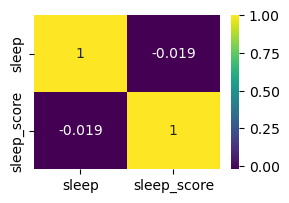

In [50]:
corr_df=data18.iloc[:,:-6].corr(numeric_only=True)
plt.figure(figsize=(3,2))
sns.heatmap(corr_df.loc[['sleep','sleep_score'],['sleep','sleep_score']], cmap='viridis',annot=True)
plt.show()
# 2018년도 수면점수와 주관적 수면 점수는 -0.019로 음의 상관관계를 가지고 있다.

## sleep score 기준 이진 분류
- origin : 0.555
    - 기준 : sleep score 88.0846325 (중앙값)
- origin/total sleep time : 0.555
    - 기준 : sleep score/total sleep time 0.004045307441314554 (중앙값)

### origin

In [77]:
data=pd.read_csv('../total1819.csv').drop(['Unnamed: 0.1','Unnamed: 0'],axis=1)
data=data.fillna(-1)
data18=data[data['device']=='Fitbit']
data18=data18.drop(['waso', 'wakeupcount','aal','movement_index','fragmentation_index', 'sleep_frag_index','userId', 'night_inputDt', 'amCaffeine','pmCaffeine','alcohol','device','inputDt','date','date_m','startDt', 'endDt'],axis=1)
data18['sleep_classes'] = data18['sleep_score'].apply(lambda x: 1 if x>=88.0846325 else 0)
data18['sleep_score'].median()

88.0846325

In [78]:
data18.value_counts('sleep_classes')

sleep_classes
1    109
0    108
dtype: int64

,pmEmotion,pmStress,ifUnusual,breakfast,lunch,dinner,lateSnack,amCaffAmount,pmCaffAmount,aAmount,sleep,sleepProblem,dream,amCondition,amEmotion,total_CaffAmount,sleep_score,total_sleep_time,time_in_bed,sleep_classes
0,3.0,1.0,2.0,1.0,3.0,3.0,4.0,-1.0,-1.0,-1.0,3.0,3.0,2.0,4.0,5.0,-1.0,90.800478,22800,25110,1
1,5.0,4.0,2.0,1.0,3.0,3.0,-1.0,2.0,-1.0,-1.0,3.0,0.0,4.0,3.0,4.0,-1.0,91.984231,21000,22830,1
2,3.0,2.0,2.0,2.0,3.0,3.0,4.0,-1.0,1.0,-1.0,4.0,6.0,4.0,2.0,2.0,-1.0,88.482385,19590,22140,1
3,4.0,2.0,2.0,2.0,3.0,3.0,4.0,1.0,1.0,-1.0,3.0,0.0,4.0,1.0,5.0,2.0,88.781665,22080,24870,1
4,3.0,2.0,2.0,1.0,3.0,3.0,2.0,-1.0,-1.0,-1.0,4.0,0.0,4.0,1.0,2.0,-1.0,92.403101,17880,19350,1


1. total_sleep_time (0.146984)
2. time_in_bed (0.133609)
3. dream (0.064125)
4. amEmotion (0.062271)
5. breakfast (0.060961)
6. dinner (0.054907)
7. sleepProblem (0.052901)
8. pmStress (0.051643)
9. sleep (0.050969)
10. amCondition (0.050134)
11. lunch (0.046661)
12. pmCaffAmount (0.043543)
13. pmEmotion (0.042977)
14. lateSnack (0.042520)
15. amCaffAmount (0.032688)
16. ifUnusual (0.025470)
17. total_CaffAmount (0.022932)
18. aAmount (0.014703)


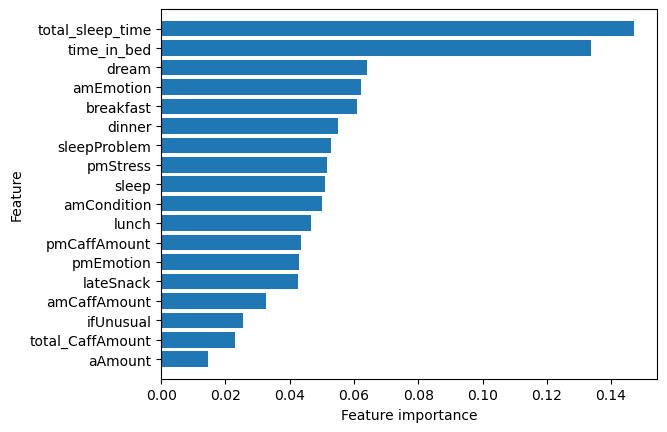

---------------------------------
정확도 :  0.5555555555555556


In [79]:
data=pd.read_csv('../total1819.csv').drop(['Unnamed: 0.1','Unnamed: 0'],axis=1)
data=data.fillna(-1)
data18=data[data['device']=='Fitbit']
data18=data18.drop(['waso', 'wakeupcount','aal','movement_index','fragmentation_index', 'sleep_frag_index','userId', 'night_inputDt', 'amCaffeine','pmCaffeine','alcohol','device','inputDt','date','date_m','startDt', 'endDt'],axis=1)
data18['sleep_classes'] = data18['sleep_score'].apply(lambda x: 1 if x>=88.0846325 else 0)
display(data18.head())
col=data18.columns[:-1]
X=data18[col]
X=X.drop(['sleep_score'],axis=1)
y=data18['sleep_classes']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

#변수 중요도
model = RandomForestClassifier(random_state=100)
model.fit(X_train, y_train)

# 변수 중요도를 계산합니다.
importances = model.feature_importances_
# 변수 중요도를 내림차순으로 정렬합니다.
indices = np.argsort(importances)[::-1]

# 변수 중요도 및 변수 이름을 출력합니다.
for f in range(X_train.shape[1]):
    print("%d. %s (%f)" % (f + 1, X_train.columns[indices[f]], importances[indices[f]]))
n_features = X_train.shape[1]
plt.barh(np.arange(n_features),sorted(model.feature_importances_),align='center')
plt.yticks(np.arange(n_features)[::-1],X.columns[indices])
plt.xlabel("Feature importance")
plt.ylabel('Feature')
plt.ylim(-1,n_features)
plt.show()

predictions=model.predict(X_test)
print("---------------------------------")
print('정확도 : ', accuracy_score(y_test,predictions)) ## 테스트 성능 평가 점수(Accuracy)

### origin/total

In [80]:
data18=data[data['device']=='Fitbit']
data18=data18.drop(['waso', 'wakeupcount','aal','movement_index','fragmentation_index', 'sleep_frag_index','userId', 'night_inputDt', 'amCaffeine','pmCaffeine','alcohol','device','inputDt','date','date_m','startDt', 'endDt'],axis=1)
for x in ['time_in_bed','sleep_score']:
    data18[x]=data18[x]/data18['total_sleep_time']
data18['sleep_score'].median()

0.004045307441314554

,pmEmotion,pmStress,ifUnusual,breakfast,lunch,dinner,lateSnack,amCaffAmount,pmCaffAmount,aAmount,sleep,sleepProblem,dream,amCondition,amEmotion,total_CaffAmount,sleep_score,total_sleep_time,time_in_bed,sleep_classes
0,3.0,1.0,2.0,1.0,3.0,3.0,4.0,-1.0,-1.0,-1.0,3.0,3.0,2.0,4.0,5.0,-1.0,0.003982,22800,1.101316,0
1,5.0,4.0,2.0,1.0,3.0,3.0,-1.0,2.0,-1.0,-1.0,3.0,0.0,4.0,3.0,4.0,-1.0,0.004380,21000,1.087143,1
2,3.0,2.0,2.0,2.0,3.0,3.0,4.0,-1.0,1.0,-1.0,4.0,6.0,4.0,2.0,2.0,-1.0,0.004517,19590,1.130168,1
3,4.0,2.0,2.0,2.0,3.0,3.0,4.0,1.0,1.0,-1.0,3.0,0.0,4.0,1.0,5.0,2.0,0.004021,22080,1.126359,0
4,3.0,2.0,2.0,1.0,3.0,3.0,2.0,-1.0,-1.0,-1.0,4.0,0.0,4.0,1.0,2.0,-1.0,0.005168,17880,1.082215,1


sleep_classes
1    109
0    108
dtype: int64

1. time_in_bed (0.200192)
2. sleepProblem (0.084043)
3. amEmotion (0.082468)
4. sleep (0.069309)
5. pmStress (0.063944)
6. amCondition (0.063620)
7. dinner (0.061775)
8. lateSnack (0.057063)
9. breakfast (0.052301)
10. pmEmotion (0.048379)
11. dream (0.043702)
12. lunch (0.040248)
13. pmCaffAmount (0.038560)
14. ifUnusual (0.031294)
15. amCaffAmount (0.027727)
16. total_CaffAmount (0.026785)
17. aAmount (0.008590)


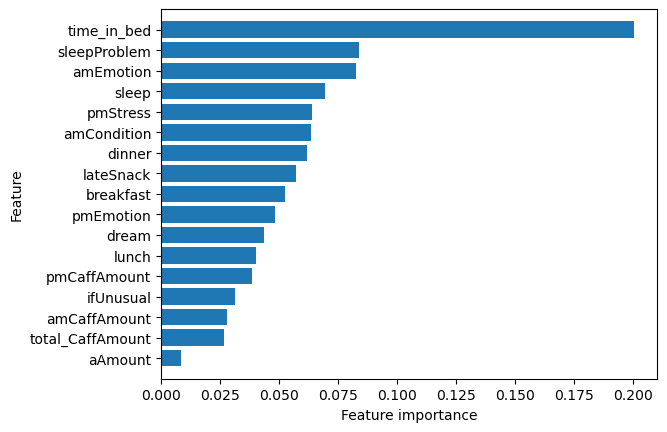

---------------------------------
정확도 :  0.5555555555555556


In [81]:
data=pd.read_csv('../total1819.csv').drop(['Unnamed: 0.1','Unnamed: 0'],axis=1)
data=data.fillna(-1)
data18=data[data['device']=='Fitbit']
data18=data18.drop(['waso', 'wakeupcount','aal','movement_index','fragmentation_index', 'sleep_frag_index','userId', 'night_inputDt', 'amCaffeine','pmCaffeine','alcohol','device','inputDt','date','date_m','startDt', 'endDt'],axis=1)
for x in ['time_in_bed','sleep_score']:
    data18[x]=data18[x]/data18['total_sleep_time']
data18['sleep_classes'] = data18['sleep_score'].apply(lambda x: 1 if x>=0.004045307441314554 else 0)
display(data18.head())
display(data18.value_counts('sleep_classes'))
    
col=data18.columns[:-1]
X=data18[col]
X=X.drop(['sleep_score','total_sleep_time'],axis=1)
y=data18['sleep_classes']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

#from imblearn.over_sampling import SMOTE

#smote = SMOTE(random_state=42)
#X_train_over, y_train_over = smote.fit_resample(X_train, y_train)

#변수 중요도
model = RandomForestClassifier(random_state=100)
model.fit(X_train, y_train)

# 변수 중요도를 계산합니다.
importances = model.feature_importances_
# 변수 중요도를 내림차순으로 정렬합니다.
indices = np.argsort(importances)[::-1]

# 변수 중요도 및 변수 이름을 출력합니다.
for f in range(X_train.shape[1]):
    print("%d. %s (%f)" % (f + 1, X_train.columns[indices[f]], importances[indices[f]]))
n_features = X_train.shape[1]
plt.barh(np.arange(n_features),sorted(model.feature_importances_),align='center')
plt.yticks(np.arange(n_features)[::-1],X.columns[indices])
plt.xlabel("Feature importance")
plt.ylabel('Feature')
plt.ylim(-1,n_features)
plt.show()

predictions=model.predict(X_test)
print("---------------------------------")
print('정확도 : ', accuracy_score(y_test,predictions)) ## 테스트 성능 평가 점수(Accuracy)

## sleepProblem 기준 이진분류
- origin : 0.625
    - 기준 : sleepProblem 1 (중앙값)
- origin/total sleep time : 0.555
    - 기준 : sleepProblem 1 (중앙값)

### origin

In [82]:
data=pd.read_csv('../total1819.csv').drop(['Unnamed: 0.1','Unnamed: 0'],axis=1)
data=data.fillna(-1)
data18=data[data['device']=='Fitbit']
data18=data18.drop(['waso', 'wakeupcount','aal','movement_index','fragmentation_index', 'sleep_frag_index','userId', 'night_inputDt', 'amCaffeine','pmCaffeine','alcohol','device','inputDt','date','date_m','startDt', 'endDt'],axis=1)
data18['sleepProblem'].median()

1.0

sleep_classes
1    123
0     94
dtype: int64

1. total_sleep_time (0.158355)
2. time_in_bed (0.146354)
3. sleep (0.077978)
4. lunch (0.071988)
5. pmStress (0.067730)
6. amEmotion (0.060458)
7. dinner (0.059163)
8. dream (0.057588)
9. pmEmotion (0.050466)
10. breakfast (0.048021)
11. lateSnack (0.047317)
12. amCondition (0.037234)
13. pmCaffAmount (0.029965)
14. amCaffAmount (0.025068)
15. total_CaffAmount (0.022528)
16. ifUnusual (0.022078)
17. aAmount (0.017710)


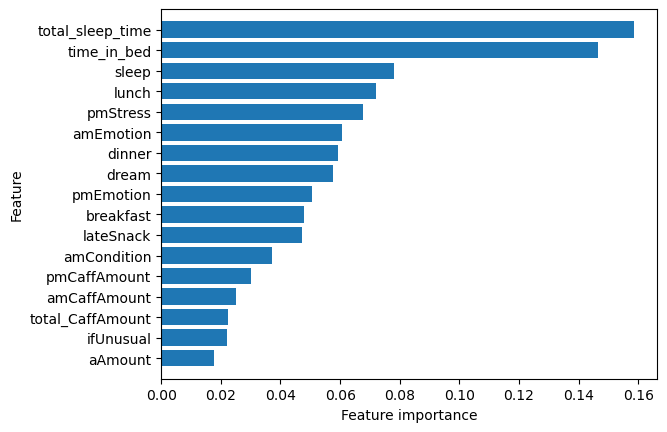

---------------------------------
정확도 :  0.625


In [83]:
data=pd.read_csv('../total1819.csv').drop(['Unnamed: 0.1','Unnamed: 0'],axis=1)
data=data.fillna(-1)
data18=data[data['device']=='Fitbit']
data18=data18.drop(['waso', 'wakeupcount','aal','movement_index','fragmentation_index', 'sleep_frag_index','userId', 'night_inputDt', 'amCaffeine','pmCaffeine','alcohol','device','inputDt','date','date_m','startDt', 'endDt'],axis=1)
data18['sleep_classes'] = data18['sleepProblem'].apply(lambda x: 1 if x>=1 else 0)
display(data18.value_counts('sleep_classes'))
    
col=data18.columns[:-1]
X=data18[col]
X=X.drop(['sleep_score','sleepProblem'],axis=1)
y=data18['sleep_classes']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

model = RandomForestClassifier(random_state=100)
model.fit(X_train, y_train)

# 변수 중요도를 계산합니다.
importances = model.feature_importances_
# 변수 중요도를 내림차순으로 정렬합니다.
indices = np.argsort(importances)[::-1]

# 변수 중요도 및 변수 이름을 출력합니다.
for f in range(X_train.shape[1]):
    print("%d. %s (%f)" % (f + 1, X_train.columns[indices[f]], importances[indices[f]]))
n_features = X_train.shape[1]
plt.barh(np.arange(n_features),sorted(model.feature_importances_),align='center')
plt.yticks(np.arange(n_features)[::-1],X_train.columns[indices])
plt.xlabel("Feature importance")
plt.ylabel('Feature')
plt.ylim(-1,n_features)
plt.show()

predictions=model.predict(X_test)
print("---------------------------------")
print('정확도 : ', accuracy_score(y_test,predictions)) ## 테스트 성능 평가 점수(Accuracy)

### origin/total

sleep_classes
1    123
0     94
dtype: int64

1. time_in_bed (0.199546)
2. sleep (0.098108)
3. pmStress (0.074242)
4. lunch (0.066581)
5. dinner (0.066439)
6. dream (0.065513)
7. amEmotion (0.061252)
8. pmEmotion (0.060949)
9. lateSnack (0.060661)
10. amCondition (0.050642)
11. breakfast (0.047390)
12. pmCaffAmount (0.040667)
13. amCaffAmount (0.036756)
14. ifUnusual (0.026122)
15. total_CaffAmount (0.023966)
16. aAmount (0.021167)


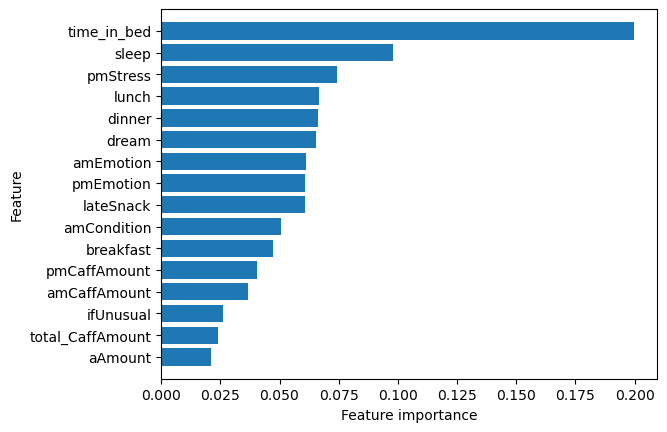

---------------------------------
정확도 :  0.5555555555555556


In [32]:
data=pd.read_csv('../total1819.csv').drop(['Unnamed: 0.1','Unnamed: 0'],axis=1)
data=data.fillna(-1)
data18=data[data['device']=='Fitbit']
data18=data18.drop(['waso', 'wakeupcount','aal','movement_index','fragmentation_index', 'sleep_frag_index','userId', 'night_inputDt', 'amCaffeine','pmCaffeine','alcohol','device','inputDt','date','date_m','startDt', 'endDt'],axis=1)
for x in ['time_in_bed','total_sleep_time']:
    data18[x]=data18[x]/data18['total_sleep_time']
data18['sleep_classes'] = data18['sleepProblem'].apply(lambda x: 1 if x>=1 else 0)

display(data18.value_counts('sleep_classes'))
    
col=data18.columns[:-1]
X=data18[col]
X=X.drop(['sleep_score','sleepProblem','total_sleep_time'],axis=1)
y=data18['sleep_classes']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

model = RandomForestClassifier(random_state=100)
model.fit(X_train, y_train)

# 변수 중요도를 계산합니다.
importances = model.feature_importances_
# 변수 중요도를 내림차순으로 정렬합니다.
indices = np.argsort(importances)[::-1]

# 변수 중요도 및 변수 이름을 출력합니다.
for f in range(X_train.shape[1]):
    print("%d. %s (%f)" % (f + 1, X_train.columns[indices[f]], importances[indices[f]]))
n_features = X_train.shape[1]
plt.barh(np.arange(n_features),sorted(model.feature_importances_),align='center')
plt.yticks(np.arange(n_features)[::-1],X_train.columns[indices])
plt.xlabel("Feature importance")
plt.ylabel('Feature')
plt.ylim(-1,n_features)
plt.show()

predictions=model.predict(X_test)
print("---------------------------------")
print('정확도 : ', accuracy_score(y_test,predictions)) ## 테스트 성능 평가 점수(Accuracy)

# 2019

In [53]:
data=pd.read_csv('../total1819.csv').drop(['Unnamed: 0.1','Unnamed: 0'],axis=1)
data=data.fillna(-1)
data19=data[data['device']=='Actigraph']

### 수면 점수 분포 확인

In [54]:
data19['sleep_score'].min(),data19['sleep_score'].max()
# 전처리된 수면 점수는 71점에서 100점까지 분포되어있다.

(71.19, 100.0)

### 수면 점수와 주관적 수면 점수 상호상관도 시각화

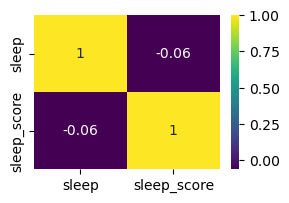

In [55]:
corr_df=data19.corr(numeric_only=True)
plt.figure(figsize=(3,2))
sns.heatmap(corr_df.loc[['sleep','sleep_score'],['sleep','sleep_score']], cmap='viridis',annot=True)
plt.show()
# 2019년도 수면점수와 주관적 수면 점수는 -0.06로 음의 상관관계를 가지고 있다.

## sleep score 기준 이진분류
- origin : 0.968
    - 기준 : sleep_score 96.45 (중앙값)
- origin/total sleep time : 0.915
    - 기준 : sleep_score/total sleep time 0.0032971272770871973 (중앙값)

### origin

In [69]:
data=pd.read_csv('../total1819.csv').drop(['Unnamed: 0.1','Unnamed: 0'],axis=1)
data=data.fillna(-1)
data19=data[data['device']=='Actigraph']
data19['sleep_score'].median()

96.45

,pmEmotion,pmStress,ifUnusual,breakfast,lunch,dinner,lateSnack,amCaffAmount,pmCaffAmount,aAmount,...,sleep_score,total_sleep_time,time_in_bed,waso,wakeupcount,aal,movement_index,fragmentation_index,sleep_frag_index,sleep_classes
217,4.0,5.0,1.0,3.0,3.0,3.0,3.0,-1.0,-1.0,-1.0,...,82.44,26760,32460,5700.0,3.0,31.67,6.412,25.0,31.412,0
218,4.0,5.0,1.0,3.0,3.0,3.0,3.0,-1.0,-1.0,-1.0,...,97.89,36120,36900,780.0,2.0,6.50,12.060,0.0,12.060,1
219,2.0,2.0,2.0,3.0,2.0,4.0,4.0,-1.0,1.0,-1.0,...,96.48,16440,17040,600.0,8.0,1.25,4.930,0.0,4.930,1
220,2.0,2.0,2.0,3.0,2.0,4.0,4.0,-1.0,1.0,-1.0,...,98.03,32880,33540,660.0,4.0,2.75,1.431,0.0,1.431,1
221,3.0,3.0,2.0,3.0,3.0,4.0,4.0,1.0,1.0,-1.0,...,99.53,25320,25440,120.0,2.0,1.00,2.358,0.0,2.358,1


sleep_classes
1    144
0    142
dtype: int64

1. movement_index (0.230267)
2. waso (0.228884)
3. wakeupcount (0.194402)
4. sleep_frag_index (0.103173)
5. aal (0.059403)
6. time_in_bed (0.049695)
7. total_sleep_time (0.046789)
8. fragmentation_index (0.037334)
9. sleep (0.005063)
10. pmStress (0.004731)
11. pmEmotion (0.004283)
12. dinner (0.003970)
13. amEmotion (0.003932)
14. sleepProblem (0.003847)
15. amCondition (0.003843)
16. lunch (0.003782)
17. dream (0.003766)
18. lateSnack (0.003461)
19. breakfast (0.003290)
20. ifUnusual (0.002410)
21. pmCaffAmount (0.001558)
22. aAmount (0.001225)
23. total_CaffAmount (0.000722)
24. amCaffAmount (0.000171)


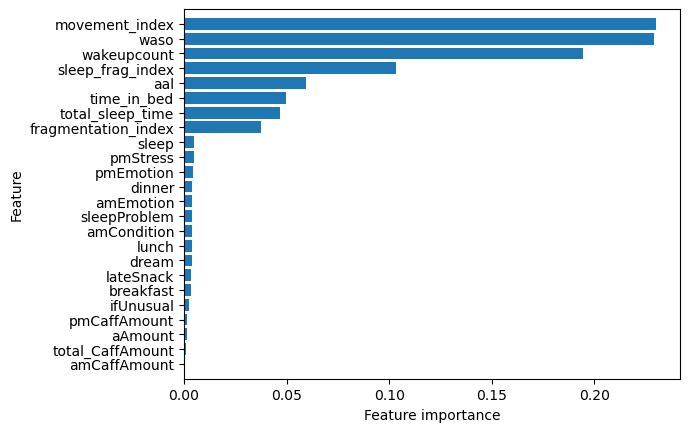

---------------------------------
정확도 :  0.968421052631579


In [70]:
data=pd.read_csv('../total1819.csv').drop(['Unnamed: 0.1','Unnamed: 0'],axis=1)
data=data.fillna(-1)
data19=data[data['device']=='Actigraph']
data19=data19.drop(['userId', 'night_inputDt', 'amCaffeine','pmCaffeine','alcohol','device','inputDt','date','date_m','startDt', 'endDt'],axis=1)
data19['sleep_classes'] = data19['sleep_score'].apply(lambda x: 1 if x>=96.45 else 0)
display(data19.head())
display(data19.value_counts('sleep_classes'))
col=data19.columns[:-1]
X=data19[col]
X=X.drop(['sleep_score'],axis=1)
y=data19['sleep_classes']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

model = RandomForestClassifier(random_state=100)
model.fit(X_train, y_train)

# 변수 중요도를 계산합니다.
importances = model.feature_importances_
# 변수 중요도를 내림차순으로 정렬합니다.
indices = np.argsort(importances)[::-1]

# 변수 중요도 및 변수 이름을 출력합니다.
for f in range(X_train.shape[1]):
    print("%d. %s (%f)" % (f + 1, X_train.columns[indices[f]], importances[indices[f]]))
n_features = X_train.shape[1]
plt.barh(np.arange(n_features),sorted(model.feature_importances_),align='center')
plt.yticks(np.arange(n_features)[::-1],X.columns[indices])
plt.xlabel("Feature importance")
plt.ylabel('Feature')
plt.ylim(-1,n_features)
plt.show()

predictions=model.predict(X_test)
print("---------------------------------")
print('정확도 : ', accuracy_score(y_test,predictions)) ## 테스트 성능 평가 점수(Accuracy)

### origin/total

In [72]:
data=pd.read_csv('../total1819.csv').drop(['Unnamed: 0.1','Unnamed: 0'],axis=1)
data=data.fillna(-1)
data19=data[data['device']=='Actigraph']
data19=data19.drop(['userId', 'night_inputDt', 'amCaffeine','pmCaffeine','alcohol','device','inputDt','date','date_m','startDt', 'endDt'],axis=1)
for x in ['waso','wakeupcount','aal','time_in_bed','sleep_score']:
    data19[x]=data19[x]/data19['total_sleep_time']
data19['sleep_score'].median()

0.0032971272770871973

,pmEmotion,pmStress,ifUnusual,breakfast,lunch,dinner,lateSnack,amCaffAmount,pmCaffAmount,aAmount,...,sleep_score,total_sleep_time,time_in_bed,waso,wakeupcount,aal,movement_index,fragmentation_index,sleep_frag_index,sleep_classes
217,4.0,5.0,1.0,3.0,3.0,3.0,3.0,-1.0,-1.0,-1.0,...,0.003081,26760,1.213004,0.213004,0.000112,0.001183,6.412,25.0,31.412,0
218,4.0,5.0,1.0,3.0,3.0,3.0,3.0,-1.0,-1.0,-1.0,...,0.002710,36120,1.021595,0.021595,0.000055,0.000180,12.060,0.0,12.060,0
219,2.0,2.0,2.0,3.0,2.0,4.0,4.0,-1.0,1.0,-1.0,...,0.005869,16440,1.036496,0.036496,0.000487,0.000076,4.930,0.0,4.930,1
220,2.0,2.0,2.0,3.0,2.0,4.0,4.0,-1.0,1.0,-1.0,...,0.002981,32880,1.020073,0.020073,0.000122,0.000084,1.431,0.0,1.431,0
221,3.0,3.0,2.0,3.0,3.0,4.0,4.0,1.0,1.0,-1.0,...,0.003931,25320,1.004739,0.004739,0.000079,0.000039,2.358,0.0,2.358,1


sleep_classes
0    143
1    143
dtype: int64

1. wakeupcount (0.159921)
2. movement_index (0.157027)
3. aal (0.156466)
4. time_in_bed (0.110558)
5. waso (0.108173)
6. sleep_frag_index (0.093463)
7. fragmentation_index (0.036704)
8. sleepProblem (0.019258)
9. aAmount (0.018161)
10. pmStress (0.015194)
11. dream (0.014456)
12. amCaffAmount (0.014321)
13. amCondition (0.012817)
14. amEmotion (0.011909)
15. breakfast (0.011682)
16. dinner (0.010003)
17. sleep (0.009650)
18. lunch (0.009011)
19. lateSnack (0.008248)
20. pmEmotion (0.007717)
21. pmCaffAmount (0.007105)
22. ifUnusual (0.005279)
23. total_CaffAmount (0.002876)


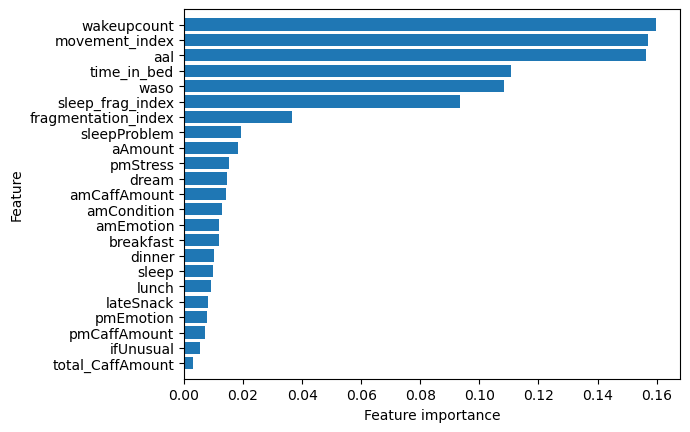

---------------------------------
정확도 :  0.9157894736842105


In [71]:
data=pd.read_csv('../total1819.csv').drop(['Unnamed: 0.1','Unnamed: 0'],axis=1)
data=data.fillna(-1)
data19=data[data['device']=='Actigraph']
data19=data19.drop(['userId', 'night_inputDt', 'amCaffeine','pmCaffeine','alcohol','device','inputDt','date','date_m','startDt', 'endDt'],axis=1)
for x in ['waso','wakeupcount','aal','time_in_bed','sleep_score']:
    data19[x]=data19[x]/data19['total_sleep_time']
data19['sleep_classes'] = data19['sleep_score'].apply(lambda x: 1 if x>=0.0032971272770871973 else 0)
display(data19.head())
display(data19.value_counts('sleep_classes'))
    
col=data19.columns[:-1]
X=data19[col]
X=X.drop(['sleep_score','total_sleep_time'],axis=1)
y=data19['sleep_classes']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

model = RandomForestClassifier(random_state=100)
model.fit(X_train, y_train)

# 변수 중요도를 계산합니다.
importances = model.feature_importances_
# 변수 중요도를 내림차순으로 정렬합니다.
indices = np.argsort(importances)[::-1]

# 변수 중요도 및 변수 이름을 출력합니다.
for f in range(X_train.shape[1]):
    print("%d. %s (%f)" % (f + 1, X_train.columns[indices[f]], importances[indices[f]]))
n_features = X_train.shape[1]
plt.barh(np.arange(n_features),sorted(model.feature_importances_),align='center')
plt.yticks(np.arange(n_features)[::-1],X.columns[indices])
plt.xlabel("Feature importance")
plt.ylabel('Feature')
plt.ylim(-1,n_features)
plt.show()

predictions=model.predict(X_test)
print("---------------------------------")
print('정확도 : ', accuracy_score(y_test,predictions)) ## 테스트 성능 평가 점수(Accuracy)

## waso 기준 이진분류
- origin : 0.936
    - 기준 : waso 1200 (중앙값)
- origin/total sleep time : 0.989
    - 기준 : waso/total sleep time 0.03683036861197604 (중앙값)

### origin

In [73]:
data=pd.read_csv('../total1819.csv').drop(['Unnamed: 0.1','Unnamed: 0'],axis=1)
data=data.fillna(-1)
data19=data[data['device']=='Actigraph']
data19=data19.drop(['userId', 'night_inputDt', 'amCaffeine','pmCaffeine','alcohol','device','inputDt','date','date_m','startDt', 'endDt'],axis=1)
data19['waso'].median()

1200.0

sleep_classes
1    144
0    142
dtype: int64

,pmEmotion,pmStress,ifUnusual,breakfast,lunch,dinner,lateSnack,amCaffAmount,pmCaffAmount,aAmount,...,sleep_score,total_sleep_time,time_in_bed,waso,wakeupcount,aal,movement_index,fragmentation_index,sleep_frag_index,sleep_classes
217,4.0,5.0,1.0,3.0,3.0,3.0,3.0,-1.0,-1.0,-1.0,...,82.44,26760,32460,5700.0,3.0,31.67,6.412,25.0,31.412,1
218,4.0,5.0,1.0,3.0,3.0,3.0,3.0,-1.0,-1.0,-1.0,...,97.89,36120,36900,780.0,2.0,6.50,12.060,0.0,12.060,0
219,2.0,2.0,2.0,3.0,2.0,4.0,4.0,-1.0,1.0,-1.0,...,96.48,16440,17040,600.0,8.0,1.25,4.930,0.0,4.930,0
220,2.0,2.0,2.0,3.0,2.0,4.0,4.0,-1.0,1.0,-1.0,...,98.03,32880,33540,660.0,4.0,2.75,1.431,0.0,1.431,0
221,3.0,3.0,2.0,3.0,3.0,4.0,4.0,1.0,1.0,-1.0,...,99.53,25320,25440,120.0,2.0,1.00,2.358,0.0,2.358,0


1. wakeupcount (0.315201)
2. movement_index (0.190387)
3. sleep_frag_index (0.156776)
4. aal (0.085765)
5. fragmentation_index (0.082762)
6. time_in_bed (0.048765)
7. total_sleep_time (0.043102)
8. sleep (0.011062)
9. dinner (0.009936)
10. pmEmotion (0.009707)
11. amEmotion (0.007589)
12. sleepProblem (0.005821)
13. amCondition (0.005652)
14. lateSnack (0.005592)
15. pmCaffAmount (0.005448)
16. pmStress (0.003627)
17. breakfast (0.003580)
18. lunch (0.003005)
19. ifUnusual (0.002204)
20. dream (0.001349)
21. aAmount (0.001174)
22. amCaffAmount (0.000892)
23. total_CaffAmount (0.000607)


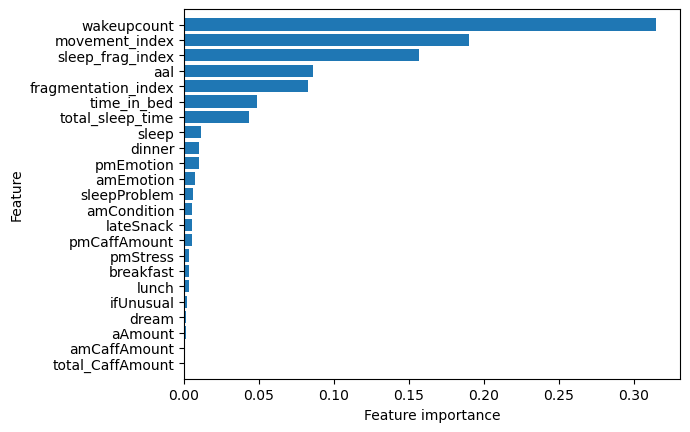

---------------------------------
정확도 :  0.9368421052631579


In [74]:
data=pd.read_csv('../total1819.csv').drop(['Unnamed: 0.1','Unnamed: 0'],axis=1)
data=data.fillna(-1)
data19=data[data['device']=='Actigraph']
data19=data19.drop(['userId', 'night_inputDt', 'amCaffeine','pmCaffeine','alcohol','device','inputDt','date','date_m','startDt', 'endDt'],axis=1)
data19['sleep_classes'] = data19['waso'].apply(lambda x: 1 if x>=1200 else 0)
display(data19.value_counts('sleep_classes'))
display(data19.head())
    
col=data19.columns[:-1]
X=data19[col]
X=X.drop(['sleep_score','waso'],axis=1)
y=data19['sleep_classes']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

model = RandomForestClassifier(random_state=100)
model.fit(X_train, y_train)

# 변수 중요도를 계산합니다.
importances = model.feature_importances_
# 변수 중요도를 내림차순으로 정렬합니다.
indices = np.argsort(importances)[::-1]

# 변수 중요도 및 변수 이름을 출력합니다.
for f in range(X_train.shape[1]):
    print("%d. %s (%f)" % (f + 1, X_train.columns[indices[f]], importances[indices[f]]))
n_features = X_train.shape[1]
plt.barh(np.arange(n_features),sorted(model.feature_importances_),align='center')
plt.yticks(np.arange(n_features)[::-1],X_train.columns[indices])
plt.xlabel("Feature importance")
plt.ylabel('Feature')
plt.ylim(-1,n_features)
plt.show()

predictions=model.predict(X_test)
print("---------------------------------")
print('정확도 : ', accuracy_score(y_test,predictions)) ## 테스트 성능 평가 점수(Accuracy)

### origin/total

In [75]:
data=pd.read_csv('../total1819.csv').drop(['Unnamed: 0.1','Unnamed: 0'],axis=1)
data=data.fillna(-1)
data19=data[data['device']=='Actigraph']
data19=data19.drop(['userId', 'night_inputDt', 'amCaffeine','pmCaffeine','alcohol','device','inputDt','date','date_m','startDt', 'endDt'],axis=1)
for x in ['time_in_bed','aal','wakeupcount','waso']:
    data19[x]=data19[x]/data19['total_sleep_time']
data19['waso'].median()

0.03683036861197604

sleep_classes
0    143
1    143
dtype: int64

,pmEmotion,pmStress,ifUnusual,breakfast,lunch,dinner,lateSnack,amCaffAmount,pmCaffAmount,aAmount,...,sleep_score,total_sleep_time,time_in_bed,waso,wakeupcount,aal,movement_index,fragmentation_index,sleep_frag_index,sleep_classes
217,4.0,5.0,1.0,3.0,3.0,3.0,3.0,-1.0,-1.0,-1.0,...,82.44,26760,1.213004,0.213004,0.000112,0.001183,6.412,25.0,31.412,1
218,4.0,5.0,1.0,3.0,3.0,3.0,3.0,-1.0,-1.0,-1.0,...,97.89,36120,1.021595,0.021595,0.000055,0.000180,12.060,0.0,12.060,0
219,2.0,2.0,2.0,3.0,2.0,4.0,4.0,-1.0,1.0,-1.0,...,96.48,16440,1.036496,0.036496,0.000487,0.000076,4.930,0.0,4.930,0
220,2.0,2.0,2.0,3.0,2.0,4.0,4.0,-1.0,1.0,-1.0,...,98.03,32880,1.020073,0.020073,0.000122,0.000084,1.431,0.0,1.431,0
221,3.0,3.0,2.0,3.0,3.0,4.0,4.0,1.0,1.0,-1.0,...,99.53,25320,1.004739,0.004739,0.000079,0.000039,2.358,0.0,2.358,0


1. time_in_bed (0.341831)
2. wakeupcount (0.200434)
3. movement_index (0.183557)
4. sleep_frag_index (0.125532)
5. fragmentation_index (0.067111)
6. aal (0.038690)
7. amCondition (0.004615)
8. pmEmotion (0.004335)
9. lateSnack (0.004213)
10. dinner (0.003799)
11. sleep (0.003264)
12. amEmotion (0.002712)
13. ifUnusual (0.002677)
14. breakfast (0.002645)
15. dream (0.002623)
16. sleepProblem (0.002602)
17. pmCaffAmount (0.002371)
18. pmStress (0.002191)
19. lunch (0.002077)
20. amCaffAmount (0.001121)
21. aAmount (0.000920)
22. total_CaffAmount (0.000680)


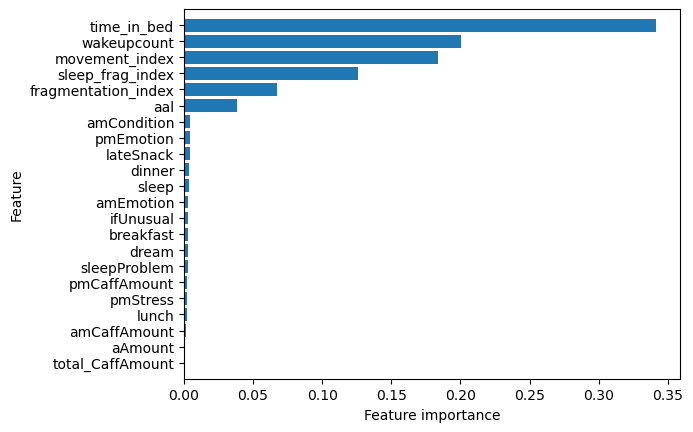

---------------------------------
정확도 :  0.9894736842105263


In [76]:
data=pd.read_csv('../total1819.csv').drop(['Unnamed: 0.1','Unnamed: 0'],axis=1)
data=data.fillna(-1)
data19=data[data['device']=='Actigraph']
data19=data19.drop(['userId', 'night_inputDt', 'amCaffeine','pmCaffeine','alcohol','device','inputDt','date','date_m','startDt', 'endDt'],axis=1)
for x in ['time_in_bed','aal','wakeupcount','waso']:
    data19[x]=data19[x]/data19['total_sleep_time']
data19['sleep_classes'] = data19['waso'].apply(lambda x: 1 if x>=0.03683036861197604 else 0)
display(data19.value_counts('sleep_classes'))
display(data19.head())
    
col=data19.columns[:-1]
X=data19[col]
X=X.drop(['sleep_score','waso','total_sleep_time'],axis=1)
y=data19['sleep_classes']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

model = RandomForestClassifier(random_state=100)
model.fit(X_train, y_train)

# 변수 중요도를 계산합니다.
importances = model.feature_importances_
# 변수 중요도를 내림차순으로 정렬합니다.
indices = np.argsort(importances)[::-1]

# 변수 중요도 및 변수 이름을 출력합니다.
for f in range(X_train.shape[1]):
    print("%d. %s (%f)" % (f + 1, X_train.columns[indices[f]], importances[indices[f]]))
n_features = X_train.shape[1]
plt.barh(np.arange(n_features),sorted(model.feature_importances_),align='center')
plt.yticks(np.arange(n_features)[::-1],X.columns[indices])
plt.xlabel("Feature importance")
plt.ylabel('Feature')
plt.ylim(-1,n_features)
plt.show()

predictions=model.predict(X_test)
print("---------------------------------")
print('정확도 : ', accuracy_score(y_test,predictions)) ## 테스트 성능 평가 점수(Accuracy)